# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from pathlib import Path
from sklearn.model_selection import KFold
import plotly.figure_factory as ff
import plotly.graph_objects as go
import pickle

BATCH_SIZE = 32
# For implementation of ReLock
info_holdout = []
labels_holdout = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [2]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [3]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Ορίζουμε μία κλάση έτσι ώστε το μοντέλο μας να σταματάει νωρίς όταν παρατηρεί ότι το test loss αυξάνεται η μέθοδος αυτή είναι γνωστή και ως early stopping.

In [4]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path

        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"Validation loss decreased to {val_loss:.6f}. Saving model...")
        else:
            self.counter += 1
            
            if self.verbose:
                print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    
    def get_best_loss(self):
        return self.best_loss

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [5]:
def train_test_model(epoch: int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     early_stopper = None,
                     device: torch.device = 'cpu',
                     test: bool = True,
                     verbose: bool = True):

    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    
    if(test):
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Evaluate on test set
            test_loss = test_step(model, test_loader, loss_fn, device)
            test_loss_arr.append(test_loss / len(test_loader))

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')

            # Early stopping check
            early_stopper(test_loss_arr[-1], model)
            if early_stopper.early_stop:
                if verbose == True:
                    print(f"Early stopping at epoch {epochs}")
                break

        # Load the best model weights after stopping
        if early_stopper.path is not None:
            model.load_state_dict(torch.load(early_stopper.path, weights_only= True))
            if verbose == True:
                print(f"Loaded best model from {early_stopper.path}")

        return train_loss_arr, test_loss_arr, early_stopper.get_best_loss(), epochs
    else:
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
        return train_loss_arr

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [6]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               scaler,
               device: torch.device = 'cpu',
               verbose = True):

    model.eval()
    model.to(device)
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            # Move to CPU and collect all predictions and targets
            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Reverse scaling
    y_pred_real = scaler.inverse_transform(all_preds)
    y_true_real = scaler.inverse_transform(all_targets)
    #y_pred_real = all_preds * scaler
    #y_true_real = all_targets * scaler

    # Calculate average Euclidean distance (in cm)
    distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
    mean_distance_error = np.mean(distances)
    std_distance_error = np.std(distances)

    # Plot real data VS predicted 
    plt.figure(figsize=(15, 15))
    number_of_points = 20

    # Plot ground truth points
    plt.scatter(y_true_real[:number_of_points, 0], y_true_real[:number_of_points, 1], color='blue', label='Ground Truth', s=100)

    # Plot predicted points
    plt.scatter(y_pred_real[:number_of_points, 0], y_pred_real[:number_of_points, 1], color='red', label='Predicted', s=100)

    # Draw lines connecting corresponding points
    for i, (gt, pred) in enumerate(zip(y_true_real[:number_of_points], y_pred_real[:number_of_points])):
        plt.plot([gt[0], pred[0]], [gt[1], pred[1]], color='gray', linestyle='--', linewidth=1)
        
        # Calculate the midpoint of the line for placing the text
        mid_x = (gt[0] + pred[0]) / 2
        mid_y = (gt[1] + pred[1]) / 2
        
        # Annotate the line with the corresponding distance from the distances array
        plt.text(mid_x, mid_y, f'{distances[i]:.2f} cm', fontsize=9, ha='center', va='bottom', color='black',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.3))

    # Add labels and legend
    plt.gca().set_aspect('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ground Truth vs Predicted Points\nMean Distance Error: {mean_distance_error:.2f} cm, Std: {std_distance_error:.2f} cm')
    plt.legend()
    plt.grid(True)

    # Show the plot
    if verbose == True:
        plt.show()

    return {
        "model_name": model.__class__.__name__,
        "mean_distance_error_cm": mean_distance_error.item(),
        "std" : std_distance_error.item()
    }


Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [7]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Κάνουμε scale και το Y οπότε σε περίπτωση τυχαίου διανύσματος θα πρέπει να το κάνουμε και αυτό scale, και μετά το output να το επαναφέρουμε.

Έχοντας δοκιμάσει να κανονικοποιήσουμε τα δεδομένα εισόδου σε [-1,1] και τα δεδομένα εξόδου με την χρήση του standardscaler, τα αποτελέσματα είναι **ελαφρώς χειρότερα** από το να κανονικοποιήσουμε και την είσοδο και την έξοδο με τον standard scaler.

Κάνοντας χρήση της μεθόδου [-1,1] τοσο για την είσοδο όσο για την έξοδο τα αποτελέσματα είναι **σαφώς χειρότερα**

Για την ώρα κρατάμε το [-1,1] για την είσοδο και το StandardScaler για την έξοδο.

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [8]:
# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

parent_dir = os.path.join(parent_dir, '..', '..','..', 'Experiments', 'Raw_Data_Single_Antenna_0') 


rfid_label = np.load(f"{parent_dir}\\final_labels.npy")
info_tensor = np.load(f"{parent_dir}\\final_tensor.npy")


info_tensor.shape , rfid_label.shape

((1013, 385, 4), (1013, 3))

Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως **κινήθηκε** και την μέτρηση της **φάσης** του.

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [9]:
#output_len = rfid_label.shape[1]

output_len = 2
input_len = info_tensor.shape[1] * info_tensor.shape[2]

input_len,output_len

(1540, 2)

***

### Heatmap

Δημιουργόυμε ένα plot για να κατανοήσουμε καλύτερα την φύση των δεδομένων που αναζητούμε στο πρόβλημα 2 διαστάσεων.

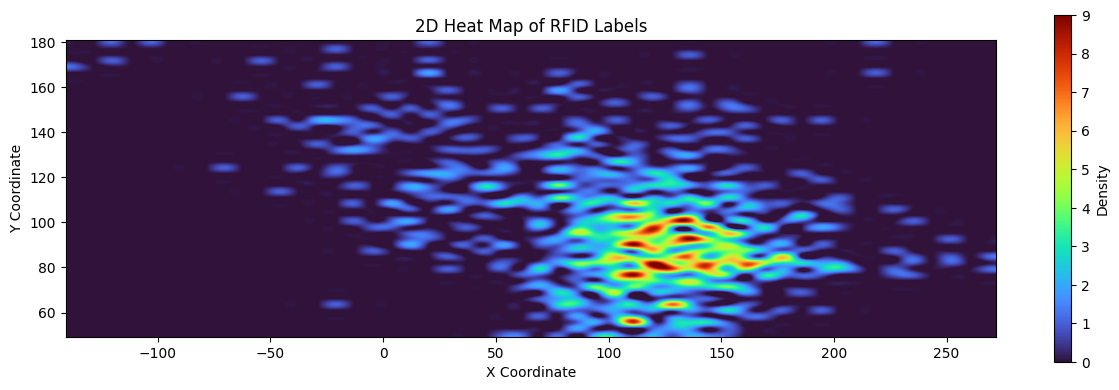

In [226]:
# Create 2D heat-map for better visualization of the expected results, hotter means more tags so we expect the model to have smaller error there.
x = rfid_label[:, 0]
y = rfid_label[:, 1]

# Create a 2D histogram
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)

# Plot the heat map
plt.figure(figsize=(15, 15))
plt.imshow(heatmap.T, origin='lower', cmap='turbo', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='lanczos')
cbar = plt.colorbar(label='Density', shrink=0.3)  # Shrink the colorbar to 80% of its original size
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2D Heat Map of RFID Labels')
plt.grid(False)  # Turn off the grid for better visualization
plt.show()

In [227]:
fig = ff.create_2d_density(
    x, y,
)

fig.update_layout(
    title="2D Density Heatmap of RFID Labels",
    xaxis_title="X Coordinate",
    yaxis_title="Y Coordinate"
)

fig.show()


In [228]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=y,
    mode='markers',
    marker=dict(
        size=5,
        color='red',
        opacity=0.3  # Adjust transparency for density effect
    )
))

fig.update_layout(
    title="2D Scatter Density of RFID Labels",
    xaxis_title="X Coordinate",
    yaxis_title="Y Coordinate"
)

fig.show()


***

### Data Funcs

Η ```data_func_cv``` δέχεται σαν ορίσματα τον πίνακα δεδομένων και τον πίνακα των tags καθώς και τους δείκτες από τους οποίους ξεκινάει το subset του cross_validation, τα κανονικοποιεί και επιστρέφει τα datasets καθώς και τον scaler που χρησιμοποίησε.

In [10]:
def data_func_cv(input_array, labels, train_idx, val_idx, batch_size=32):
    # Trim into subset
    X_train_raw = input_array[train_idx]
    X_test_raw = input_array[val_idx]
    y_train = labels[train_idx, :2]
    y_test = labels[val_idx, :2]

    # Compute abs max PER FEATURE on training data
    abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_train_raw / abs_max  
    X_test_norm = X_test_raw / abs_max  

    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)   

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y


Η ```data_func_eval``` θα χρησιμοποιηθεί για το τελικό μοντέλο που θα προκύψει μετα το CV, κανονικοποιεί τα δεδομένα και επιστρέφει τα datasets και τον scaler.

In [11]:
def data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size = 32):
    # Compute abs max PER FEATURE on training data
    abs_max = np.abs(X_main).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_main / abs_max  # shape (N_train, 500, 4)
    X_test_norm = X_holdout / abs_max    # shape (N_test, 500, 4)


    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_main_scaled = scaler_Y.fit_transform(y_main)
    y_holdout_scaled = scaler_Y.transform(y_holdout)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_main_tensor = torch.tensor(y_main_scaled, dtype=torch.float32)
    y_holdout_tensor = torch.tensor(y_holdout_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_main_tensor)
    test_data = TensorDataset(X_test_tensor, y_holdout_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

***

## Cross Validation 

Η κύρια συνάρτηση, δέχεται όλες τις παραμέτρους του μοντέλου, χωρίζει το dataset σε main και holdout, το main θα χρησιμοποιηθεί για το CV ενώ το holdout για το τελικό evaluation.

Χωρίζει το main dataset σε n_splits subsets , και προπονεί και τεστάρει το μοντέλο σε αυτά τα subsets έτσι ώστε να υπάρχει μία καλύτερη εικόνα των δεδομένων.

Μετά το CV, προπονεί το μοντέλο στο main dataset και το τεστάρει στο holdout που μέχρι τώρα δεν το έχει δει καθόλου το μοντέλο, αντιπροσωπέυοντας την real world case.

In [12]:
def cross_validation(input_array, labels, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_param, early_stopper_param, epochs, device, verbose = True):
    # Hold out 5% of the data for final validation
    X_main, X_holdout, y_main, y_holdout = train_test_split(
        input_array, labels, test_size=0.05, random_state=42
    )

    ################## FOR PHASE RELOCK ################
    global labels_holdout
    global info_holdout
    info_holdout = X_holdout
    labels_holdout = y_holdout
    ####################################################

    y_holdout = y_holdout[:, :2]
    y_main = y_main[:,:2]
    
    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_main)):
        
        print(f"Fold {fold_idx + 1}")

        train_loader, test_loader, _ = data_func_cv(X_main, y_main, train_idx, val_idx, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    
    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result

***

## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [13]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 2.646792 | Loss test: 1.046442 | lr = 0.01
Epoch 10 | Loss train: 0.587278 | Loss test: 1.022950 | lr = 0.01
Epoch 20 | Loss train: 0.917432 | Loss test: 0.823774 | lr = 0.01
Epoch 30 | Loss train: 0.405191 | Loss test: 0.413941 | lr = 0.001
Epoch 40 | Loss train: 0.365207 | Loss test: 0.406609 | lr = 0.001
Epoch 50 | Loss train: 0.383688 | Loss test: 0.418034 | lr = 0.001
Epoch 60 | Loss train: 0.318999 | Loss test: 0.389591 | lr = 0.0001
Epoch 70 | Loss train: 0.314670 | Loss test: 0.390784 | lr = 1e-05
Early stopping at epoch 79
Loaded best model from temp_model.pth


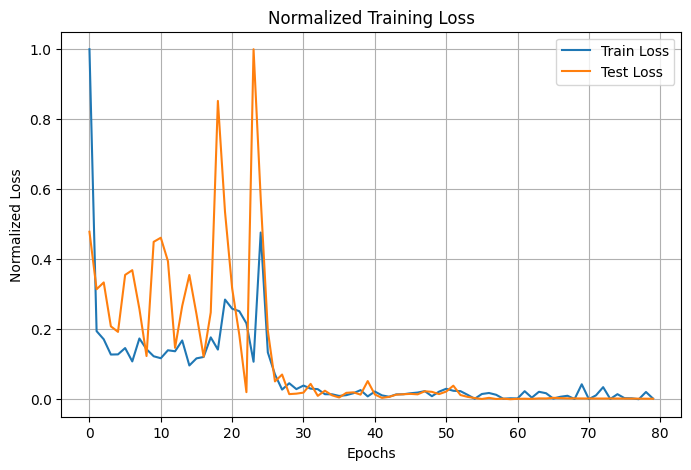

Fold 2
Epoch 0 | Loss train: 2.353954 | Loss test: 0.854867 | lr = 0.01
Epoch 10 | Loss train: 0.469688 | Loss test: 0.508673 | lr = 0.01
Epoch 20 | Loss train: 1.613538 | Loss test: 1.652686 | lr = 0.01
Epoch 30 | Loss train: 0.331499 | Loss test: 0.418959 | lr = 0.001
Epoch 40 | Loss train: 0.343305 | Loss test: 0.478857 | lr = 0.001
Epoch 50 | Loss train: 0.314687 | Loss test: 0.407346 | lr = 0.0001
Epoch 60 | Loss train: 0.316381 | Loss test: 0.407876 | lr = 1e-05
Early stopping at epoch 62
Loaded best model from temp_model.pth


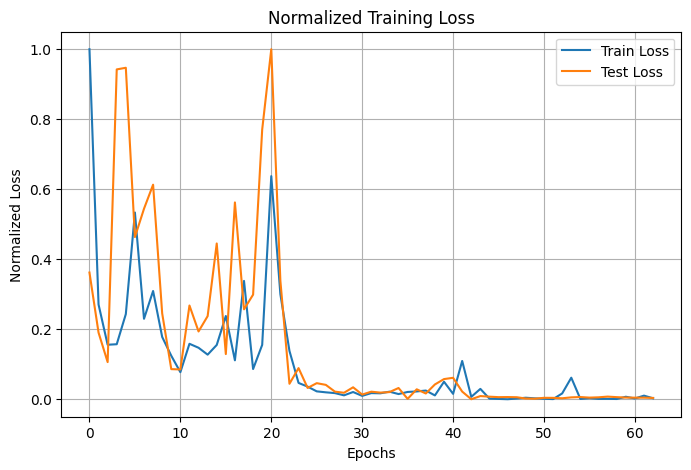

Cross-Validation finished with mean error across 2 subsets = 0.3951248793164268, evaluating final model...
Epoch 0 | Loss train: 2.410780 | lr = 0.01
Epoch 10 | Loss train: 0.684146 | lr = 0.01
Epoch 20 | Loss train: 0.576072 | lr = 0.01
Epoch 30 | Loss train: 0.348916 | lr = 0.001
Epoch 40 | Loss train: 0.352938 | lr = 0.001
Epoch 50 | Loss train: 0.328638 | lr = 0.0001
Epoch 60 | Loss train: 0.322966 | lr = 1e-05
Epoch 70 | Loss train: 0.319949 | lr = 1e-05
Epoch 79 | Loss train: 0.325793 | lr = 1e-05


{'model_name': 'SimpleModel',
 'mean_distance_error_cm': 20.36794090270996,
 'std': 14.103723526000977}

In [14]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 20, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 2
epoch = 100

cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= SimpleModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

Fold 1
Epoch 0 | Loss train: 118.205517 | Loss test: 42.437094 | lr = 0.01
Epoch 10 | Loss train: 5.946892 | Loss test: 11.445892 | lr = 0.01
Epoch 20 | Loss train: 5.438320 | Loss test: 8.333105 | lr = 0.01
Epoch 30 | Loss train: 5.095411 | Loss test: 3.227160 | lr = 0.01
Early stopping at epoch 37
Loaded best model from temp_model.pth


Fold 2
Epoch 0 | Loss train: 97.840614 | Loss test: 45.606744 | lr = 0.01
Epoch 10 | Loss train: 4.958456 | Loss test: 12.572965 | lr = 0.01
Epoch 20 | Loss train: 4.603186 | Loss test: 5.190441 | lr = 0.01
Epoch 30 | Loss train: 5.193130 | Loss test: 7.010174 | lr = 0.01
Epoch 40 | Loss train: 0.426512 | Loss test: 0.402557 | lr = 0.001
Epoch 50 | Loss train: 0.419698 | Loss test: 0.817057 | lr = 0.001
Epoch 60 | Loss train: 0.413082 | Loss test: 0.678353 | lr = 0.001
Epoch 70 | Loss train: 0.357785 | Loss test: 0.359318 | lr = 0.0001
Epoch 80 | Loss train: 0.372953 | Loss test: 0.361620 | lr = 1e-05
Epoch 90 | Loss train: 0.369657 | Loss test: 0.364067 | lr = 1e-05
Early stopping at epoch 96
Loaded best model from temp_model.pth


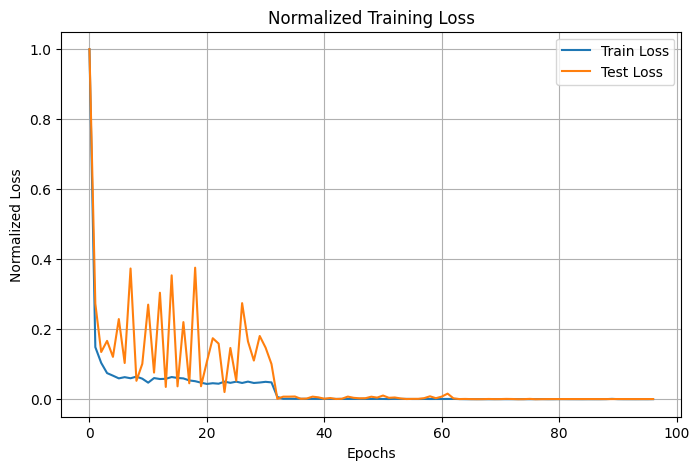

Fold 3
Epoch 0 | Loss train: 117.923474 | Loss test: 42.393337 | lr = 0.01
Epoch 10 | Loss train: 5.378667 | Loss test: 6.069932 | lr = 0.01
Epoch 20 | Loss train: 5.070761 | Loss test: 5.362300 | lr = 0.01
Early stopping at epoch 27
Loaded best model from temp_model.pth


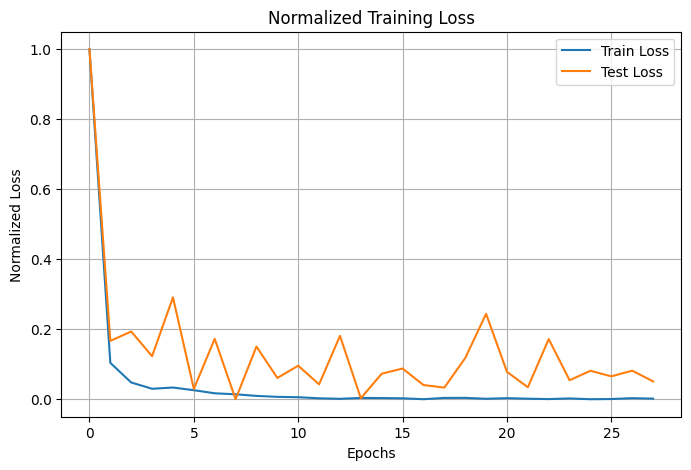

Fold 4
Epoch 0 | Loss train: 96.684657 | Loss test: 57.100201 | lr = 0.01
Epoch 10 | Loss train: 5.318850 | Loss test: 5.766078 | lr = 0.01
Epoch 20 | Loss train: 4.984009 | Loss test: 7.230887 | lr = 0.01
Early stopping at epoch 23
Loaded best model from temp_model.pth


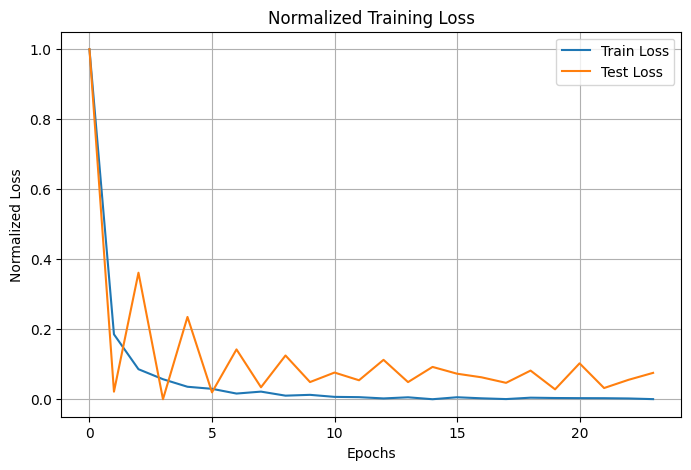

Fold 5
Epoch 0 | Loss train: 99.840082 | Loss test: 38.822153 | lr = 0.01
Epoch 10 | Loss train: 5.716782 | Loss test: 1.370274 | lr = 0.01
Epoch 20 | Loss train: 5.193259 | Loss test: 3.508377 | lr = 0.01
Early stopping at epoch 25
Loaded best model from temp_model.pth


Cross-Validation finished with mean error across 5 subsets = 1.3050034544297628, evaluating final model...
Epoch 0 | Loss train: 96.476774 | lr = 0.01
Epoch 10 | Loss train: 5.252109 | lr = 0.01
Epoch 20 | Loss train: 4.863857 | lr = 0.01
Epoch 30 | Loss train: 0.430918 | lr = 0.001
Epoch 40 | Loss train: 0.427976 | lr = 0.001
Epoch 50 | Loss train: 0.413938 | lr = 0.001
Epoch 60 | Loss train: 0.414878 | lr = 0.001
Epoch 70 | Loss train: 0.401077 | lr = 0.001
Epoch 80 | Loss train: 0.388661 | lr = 0.001
Epoch 90 | Loss train: 0.390038 | lr = 0.001
Epoch 96 | Loss train: 0.346892 | lr = 0.0001


{'model_name': 'SimpleModel',
 'mean_distance_error_cm': 22.260461807250977,
 'std': 14.857197761535645}

In [15]:
loss_fn = nn.MSELoss()
optim = torch.optim.RMSprop
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 20, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 100

cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= SimpleModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

Fold 1
Epoch 0 | Loss train: 0.638795 | Loss test: 0.612731 | lr = 0.01
Epoch 10 | Loss train: 0.474719 | Loss test: 0.491916 | lr = 0.01
Epoch 20 | Loss train: 0.447976 | Loss test: 0.477288 | lr = 0.01
Epoch 30 | Loss train: 0.420645 | Loss test: 0.464077 | lr = 0.01
Epoch 40 | Loss train: 0.371583 | Loss test: 0.454405 | lr = 0.001
Epoch 50 | Loss train: 0.369211 | Loss test: 0.424499 | lr = 0.0001
Early stopping at epoch 58
Loaded best model from temp_model.pth


Fold 2
Epoch 0 | Loss train: 0.675128 | Loss test: 0.483461 | lr = 0.01
Epoch 10 | Loss train: 0.452875 | Loss test: 0.386299 | lr = 0.01
Epoch 20 | Loss train: 0.443194 | Loss test: 0.436172 | lr = 0.01
Epoch 30 | Loss train: 0.417563 | Loss test: 0.422971 | lr = 0.01
Epoch 40 | Loss train: 0.386550 | Loss test: 0.412456 | lr = 0.01
Epoch 50 | Loss train: 0.395557 | Loss test: 0.472049 | lr = 0.01
Epoch 60 | Loss train: 0.435590 | Loss test: 0.530448 | lr = 0.01
Epoch 70 | Loss train: 0.353522 | Loss test: 0.312985 | lr = 0.01
Epoch 80 | Loss train: 0.505052 | Loss test: 0.509469 | lr = 0.01
Early stopping at epoch 82
Loaded best model from temp_model.pth


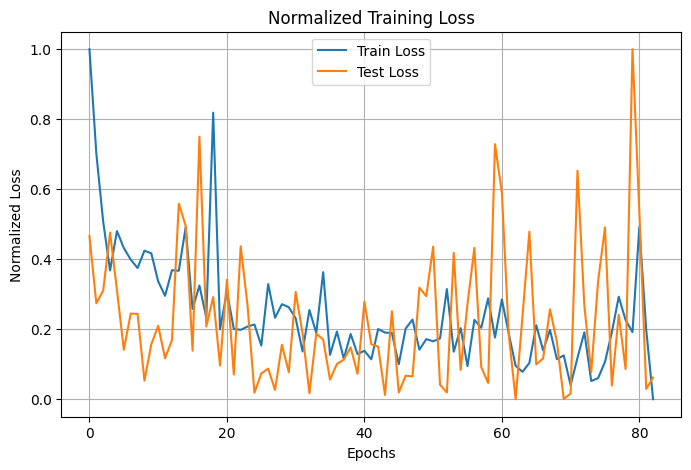

Fold 3
Epoch 0 | Loss train: 0.691252 | Loss test: 0.754878 | lr = 0.01
Epoch 10 | Loss train: 0.487028 | Loss test: 0.518107 | lr = 0.01
Epoch 20 | Loss train: 0.442139 | Loss test: 0.419704 | lr = 0.01
Epoch 30 | Loss train: 0.411946 | Loss test: 0.427702 | lr = 0.01
Epoch 40 | Loss train: 0.396227 | Loss test: 0.417165 | lr = 0.01
Epoch 50 | Loss train: 0.386460 | Loss test: 0.424225 | lr = 0.01
Epoch 60 | Loss train: 0.371211 | Loss test: 0.370217 | lr = 0.01
Epoch 70 | Loss train: 0.372837 | Loss test: 0.397461 | lr = 0.01
Epoch 80 | Loss train: 0.412431 | Loss test: 0.436238 | lr = 0.01
Early stopping at epoch 80
Loaded best model from temp_model.pth


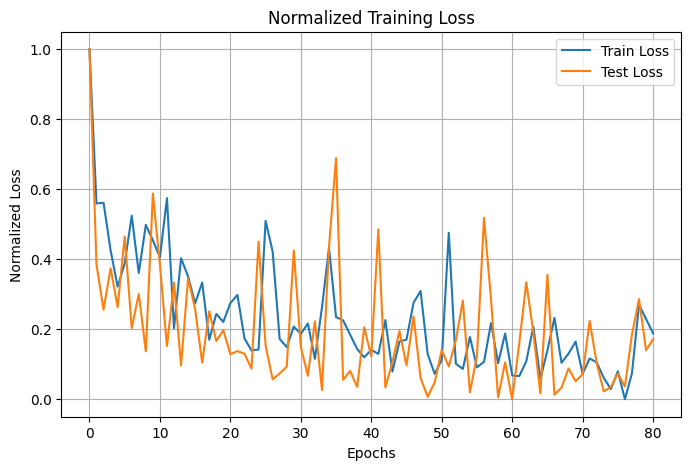

Fold 4
Epoch 0 | Loss train: 0.713541 | Loss test: 0.761277 | lr = 0.01
Epoch 10 | Loss train: 0.421757 | Loss test: 0.506790 | lr = 0.01
Epoch 20 | Loss train: 0.413127 | Loss test: 0.514533 | lr = 0.01
Epoch 30 | Loss train: 0.448508 | Loss test: 0.467872 | lr = 0.01
Epoch 40 | Loss train: 0.409046 | Loss test: 0.413715 | lr = 0.001
Epoch 50 | Loss train: 0.368479 | Loss test: 0.417559 | lr = 0.001
Epoch 60 | Loss train: 0.373239 | Loss test: 0.413562 | lr = 0.0001
Epoch 70 | Loss train: 0.361460 | Loss test: 0.415998 | lr = 0.0001
Early stopping at epoch 74
Loaded best model from temp_model.pth


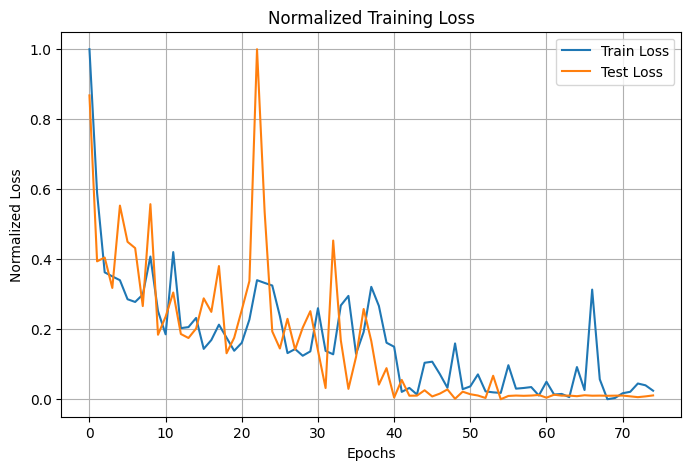

Fold 5
Epoch 0 | Loss train: 0.716914 | Loss test: 0.684406 | lr = 0.01
Epoch 10 | Loss train: 0.418155 | Loss test: 0.545773 | lr = 0.01
Epoch 20 | Loss train: 0.415424 | Loss test: 0.421589 | lr = 0.01
Epoch 30 | Loss train: 0.400391 | Loss test: 0.513033 | lr = 0.01
Epoch 40 | Loss train: 0.371768 | Loss test: 0.388888 | lr = 0.001
Epoch 50 | Loss train: 0.385923 | Loss test: 0.411316 | lr = 0.001
Epoch 60 | Loss train: 0.378686 | Loss test: 0.385871 | lr = 0.001
Epoch 70 | Loss train: 0.347431 | Loss test: 0.389400 | lr = 0.0001
Epoch 80 | Loss train: 0.356755 | Loss test: 0.384550 | lr = 0.0001
Early stopping at epoch 85
Loaded best model from temp_model.pth


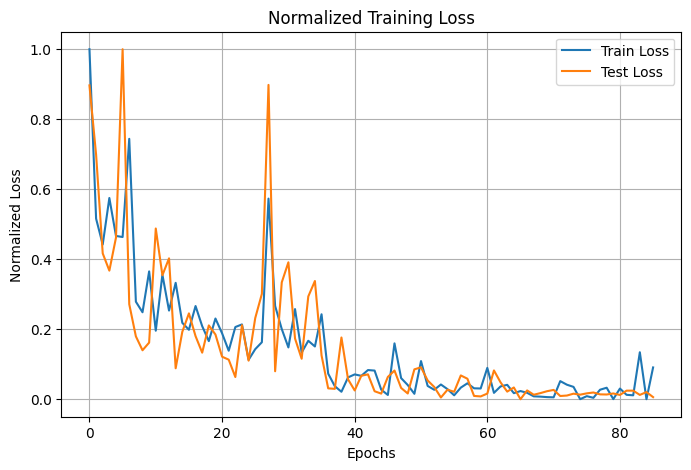

Cross-Validation finished with mean error across 5 subsets = 0.37852584524523647, evaluating final model...
Epoch 0 | Loss train: 0.703797 | lr = 0.01
Epoch 10 | Loss train: 0.428615 | lr = 0.01
Epoch 20 | Loss train: 0.408911 | lr = 0.01
Epoch 30 | Loss train: 0.411872 | lr = 0.01
Epoch 40 | Loss train: 0.460109 | lr = 0.01
Epoch 50 | Loss train: 0.364968 | lr = 0.001
Epoch 60 | Loss train: 0.354949 | lr = 0.0001
Epoch 70 | Loss train: 0.347433 | lr = 0.0001
Epoch 80 | Loss train: 0.345335 | lr = 1e-05
Epoch 85 | Loss train: 0.345873 | lr = 1e-05


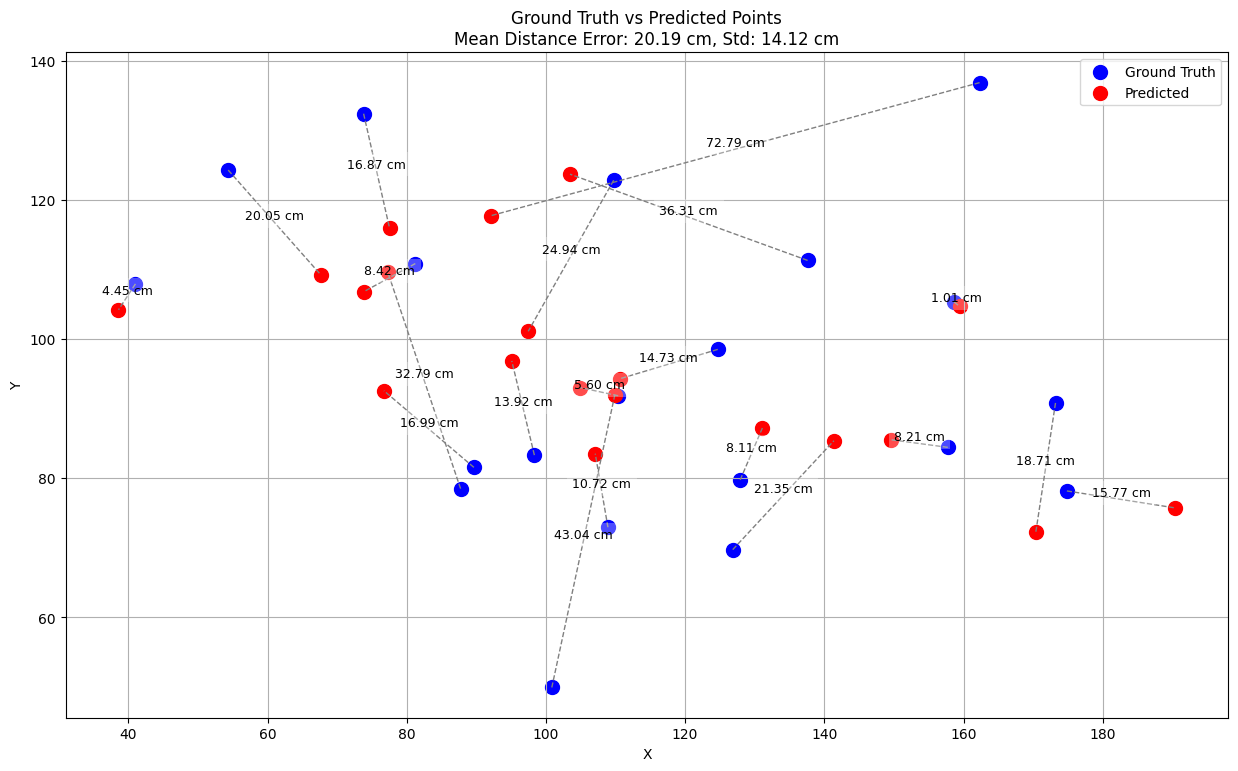

{'model_name': 'SimpleModel',
 'mean_distance_error_cm': 20.187002182006836,
 'std': 14.124776840209961}

In [30]:
loss_fn = nn.MSELoss()
optim = torch.optim.SGD
optimizer_params = {'lr':1e-2, 'momentum': 0.9}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 20, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 100

cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= SimpleModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [28]:
# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 2.870530 | Loss test: 1.229822 | lr = 0.01
Epoch 10 | Loss train: 0.362307 | Loss test: 0.548018 | lr = 0.01
Epoch 20 | Loss train: 0.286600 | Loss test: 0.356069 | lr = 0.01
Epoch 30 | Loss train: 0.262473 | Loss test: 0.376353 | lr = 0.01
Epoch 40 | Loss train: 0.181898 | Loss test: 0.300974 | lr = 0.001
Epoch 50 | Loss train: 0.165524 | Loss test: 0.308633 | lr = 0.001
Epoch 60 | Loss train: 0.180069 | Loss test: 0.294555 | lr = 0.001
Epoch 70 | Loss train: 0.151122 | Loss test: 0.278214 | lr = 0.001
Epoch 80 | Loss train: 0.141872 | Loss test: 0.274897 | lr = 0.001
Epoch 90 | Loss train: 0.139758 | Loss test: 0.284624 | lr = 0.001
Epoch 100 | Loss train: 0.130160 | Loss test: 0.256523 | lr = 0.001
Epoch 110 | Loss train: 0.137115 | Loss test: 0.253221 | lr = 0.001
Epoch 120 | Loss train: 0.124288 | Loss test: 0.256403 | lr = 0.001
Epoch 130 | Loss train: 0.119421 | Loss test: 0.255231 | lr = 0.001
Epoch 140 | Loss train: 0.133133 | Loss test: 0.274746 |

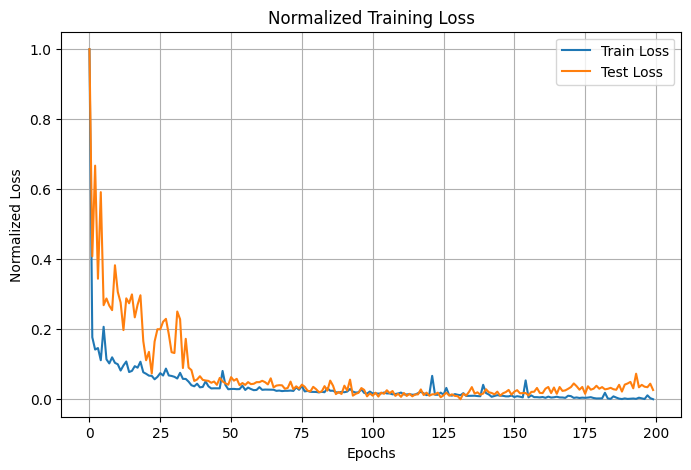

Fold 2
Epoch 0 | Loss train: 1.536266 | Loss test: 0.499760 | lr = 0.01
Epoch 10 | Loss train: 0.364557 | Loss test: 0.379436 | lr = 0.01
Epoch 20 | Loss train: 0.281956 | Loss test: 0.408555 | lr = 0.01
Epoch 30 | Loss train: 0.232366 | Loss test: 0.298980 | lr = 0.01
Epoch 40 | Loss train: 0.203194 | Loss test: 0.219524 | lr = 0.01
Epoch 50 | Loss train: 0.199980 | Loss test: 0.287661 | lr = 0.01
Epoch 60 | Loss train: 0.212431 | Loss test: 0.266533 | lr = 0.01
Epoch 70 | Loss train: 0.189157 | Loss test: 0.206158 | lr = 0.01
Epoch 80 | Loss train: 0.243739 | Loss test: 0.233321 | lr = 0.01
Epoch 90 | Loss train: 0.119808 | Loss test: 0.200065 | lr = 0.001
Epoch 100 | Loss train: 0.116394 | Loss test: 0.200659 | lr = 0.001
Epoch 110 | Loss train: 0.117209 | Loss test: 0.210130 | lr = 0.001
Epoch 120 | Loss train: 0.134244 | Loss test: 0.198288 | lr = 0.001
Epoch 130 | Loss train: 0.108253 | Loss test: 0.226417 | lr = 0.001
Epoch 140 | Loss train: 0.104903 | Loss test: 0.223244 | lr =

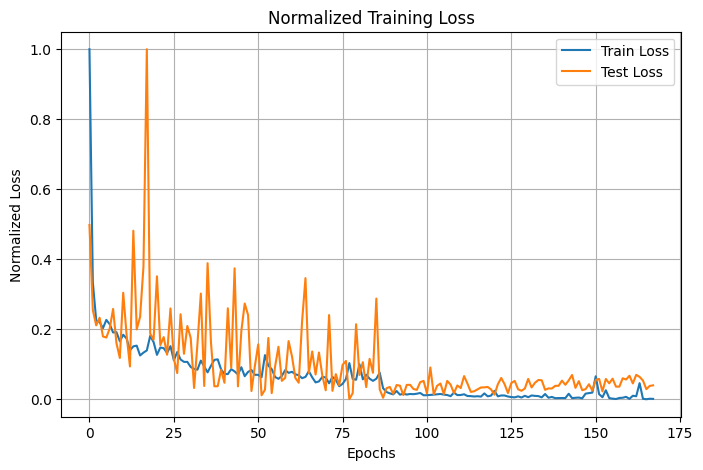

Fold 3
Epoch 0 | Loss train: 1.305800 | Loss test: 0.505281 | lr = 0.01
Epoch 10 | Loss train: 0.381297 | Loss test: 0.406693 | lr = 0.01
Epoch 20 | Loss train: 0.292536 | Loss test: 0.357598 | lr = 0.01
Epoch 30 | Loss train: 0.222142 | Loss test: 0.322864 | lr = 0.01
Epoch 40 | Loss train: 0.275318 | Loss test: 0.379369 | lr = 0.01
Epoch 50 | Loss train: 0.226710 | Loss test: 0.332910 | lr = 0.01
Epoch 60 | Loss train: 0.211793 | Loss test: 0.310111 | lr = 0.01
Epoch 70 | Loss train: 0.141863 | Loss test: 0.321943 | lr = 0.01
Epoch 80 | Loss train: 0.182069 | Loss test: 0.326208 | lr = 0.01
Epoch 90 | Loss train: 0.110168 | Loss test: 0.301150 | lr = 0.001
Epoch 100 | Loss train: 0.091563 | Loss test: 0.304374 | lr = 0.001
Epoch 110 | Loss train: 0.100588 | Loss test: 0.307053 | lr = 0.001
Epoch 120 | Loss train: 0.088860 | Loss test: 0.308119 | lr = 0.001
Epoch 130 | Loss train: 0.085773 | Loss test: 0.309408 | lr = 0.001
Epoch 140 | Loss train: 0.078478 | Loss test: 0.309990 | lr =

Fold 4
Epoch 0 | Loss train: 1.933189 | Loss test: 0.609972 | lr = 0.01
Epoch 10 | Loss train: 0.346052 | Loss test: 0.407510 | lr = 0.01
Epoch 20 | Loss train: 0.262641 | Loss test: 0.376752 | lr = 0.01
Epoch 30 | Loss train: 0.302897 | Loss test: 0.432080 | lr = 0.01
Epoch 40 | Loss train: 0.280950 | Loss test: 0.321642 | lr = 0.01
Epoch 50 | Loss train: 0.252257 | Loss test: 0.327347 | lr = 0.01
Epoch 60 | Loss train: 0.163488 | Loss test: 0.236154 | lr = 0.001
Epoch 70 | Loss train: 0.154558 | Loss test: 0.232706 | lr = 0.001
Epoch 80 | Loss train: 0.143329 | Loss test: 0.234866 | lr = 0.001
Epoch 90 | Loss train: 0.146578 | Loss test: 0.233405 | lr = 0.001
Epoch 100 | Loss train: 0.139586 | Loss test: 0.229966 | lr = 0.001
Epoch 110 | Loss train: 0.135795 | Loss test: 0.234157 | lr = 0.001
Epoch 120 | Loss train: 0.131184 | Loss test: 0.227916 | lr = 0.001
Epoch 130 | Loss train: 0.133549 | Loss test: 0.238359 | lr = 0.001
Epoch 140 | Loss train: 0.128245 | Loss test: 0.237390 | l

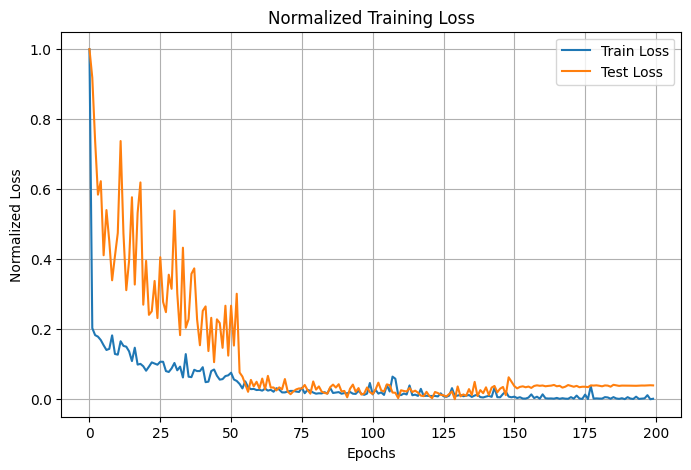

Fold 5
Epoch 0 | Loss train: 1.126520 | Loss test: 0.434937 | lr = 0.01
Epoch 10 | Loss train: 0.342582 | Loss test: 0.337093 | lr = 0.01
Epoch 20 | Loss train: 0.300870 | Loss test: 0.403870 | lr = 0.01
Epoch 30 | Loss train: 0.209177 | Loss test: 0.384630 | lr = 0.01
Epoch 40 | Loss train: 0.218788 | Loss test: 0.379347 | lr = 0.01
Epoch 50 | Loss train: 0.196380 | Loss test: 0.345016 | lr = 0.01
Epoch 60 | Loss train: 0.206631 | Loss test: 0.317795 | lr = 0.01
Epoch 70 | Loss train: 0.132814 | Loss test: 0.276136 | lr = 0.001
Epoch 80 | Loss train: 0.131371 | Loss test: 0.270982 | lr = 0.001
Epoch 90 | Loss train: 0.127227 | Loss test: 0.274437 | lr = 0.001
Epoch 100 | Loss train: 0.117247 | Loss test: 0.281988 | lr = 0.001
Epoch 110 | Loss train: 0.116220 | Loss test: 0.269975 | lr = 0.001
Epoch 120 | Loss train: 0.110613 | Loss test: 0.277534 | lr = 0.001
Epoch 130 | Loss train: 0.106749 | Loss test: 0.279262 | lr = 0.001
Epoch 140 | Loss train: 0.102988 | Loss test: 0.269620 | lr

Cross-Validation finished with mean error across 5 subsets = 0.24234793544746935, evaluating final model...
Epoch 0 | Loss train: 1.911218 | lr = 0.01
Epoch 10 | Loss train: 0.351396 | lr = 0.01
Epoch 20 | Loss train: 0.269477 | lr = 0.01
Epoch 30 | Loss train: 0.234120 | lr = 0.01
Epoch 40 | Loss train: 0.224675 | lr = 0.01
Epoch 50 | Loss train: 0.222491 | lr = 0.01
Epoch 60 | Loss train: 0.182782 | lr = 0.01
Epoch 70 | Loss train: 0.163779 | lr = 0.001
Epoch 80 | Loss train: 0.131308 | lr = 0.001
Epoch 90 | Loss train: 0.126291 | lr = 0.001
Epoch 100 | Loss train: 0.117496 | lr = 0.001
Epoch 110 | Loss train: 0.130306 | lr = 0.001
Epoch 120 | Loss train: 0.120096 | lr = 0.001
Epoch 130 | Loss train: 0.108110 | lr = 0.0001
Epoch 140 | Loss train: 0.109038 | lr = 0.0001
Epoch 150 | Loss train: 0.107972 | lr = 0.0001
Epoch 160 | Loss train: 0.109652 | lr = 0.0001
Epoch 170 | Loss train: 0.114308 | lr = 0.0001
Epoch 180 | Loss train: 0.124585 | lr = 1e-05
Epoch 190 | Loss train: 0.13987

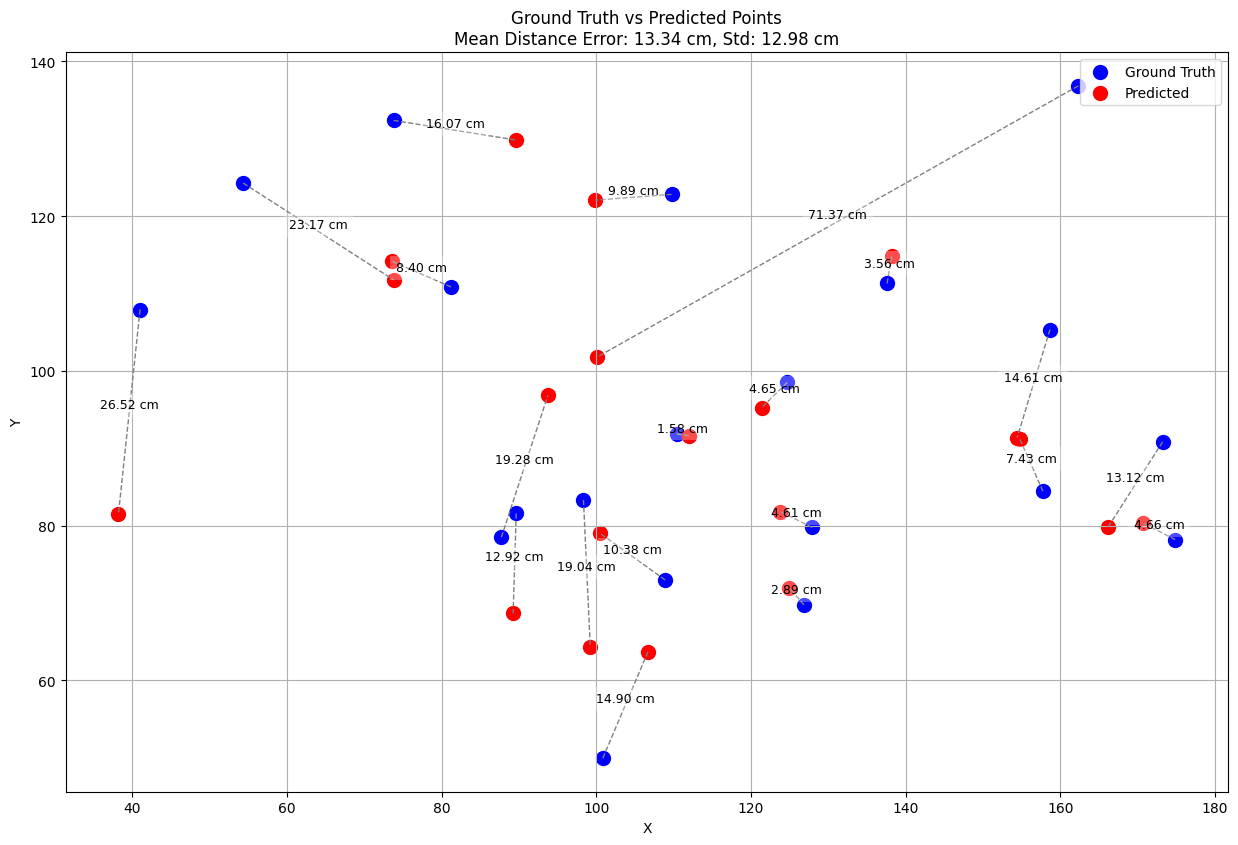

In [29]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

relu_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= ReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [18]:
relu_model

{'model_name': 'ReLUModel',
 'mean_distance_error_cm': 12.10204792022705,
 'std': 10.484224319458008}

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική. **NOT**

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

Fold 1
Epoch 0 | Loss train: 4.173470 | Loss test: 0.700633 | lr = 0.01
Epoch 10 | Loss train: 0.415650 | Loss test: 0.634210 | lr = 0.01
Epoch 20 | Loss train: 0.306913 | Loss test: 0.433295 | lr = 0.01
Epoch 30 | Loss train: 0.267394 | Loss test: 0.345203 | lr = 0.01
Epoch 40 | Loss train: 0.251069 | Loss test: 0.394850 | lr = 0.01
Epoch 50 | Loss train: 0.223697 | Loss test: 0.310773 | lr = 0.01
Epoch 60 | Loss train: 0.205996 | Loss test: 0.296246 | lr = 0.01
Epoch 70 | Loss train: 0.199266 | Loss test: 0.355809 | lr = 0.01
Epoch 80 | Loss train: 0.177837 | Loss test: 0.383779 | lr = 0.01
Epoch 90 | Loss train: 0.182260 | Loss test: 0.313029 | lr = 0.01
Epoch 100 | Loss train: 0.130189 | Loss test: 0.298054 | lr = 0.001
Epoch 110 | Loss train: 0.131008 | Loss test: 0.301282 | lr = 0.001
Epoch 120 | Loss train: 0.124921 | Loss test: 0.288695 | lr = 0.001
Epoch 130 | Loss train: 0.120734 | Loss test: 0.298978 | lr = 0.001
Epoch 140 | Loss train: 0.119484 | Loss test: 0.293714 | lr = 

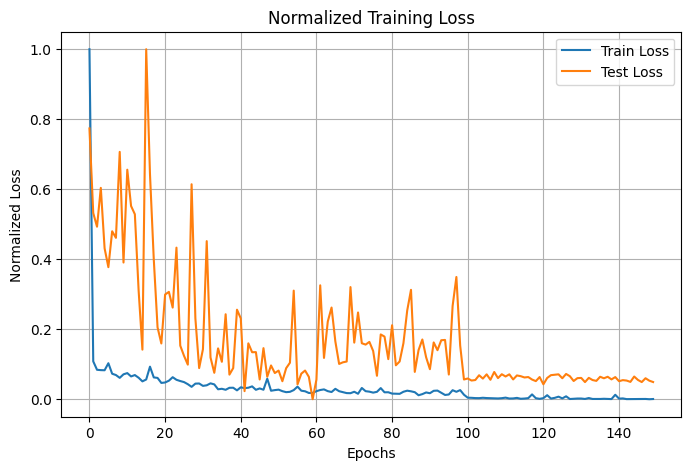

Fold 2
Epoch 0 | Loss train: 4.197922 | Loss test: 0.544527 | lr = 0.01
Epoch 10 | Loss train: 0.350203 | Loss test: 0.302759 | lr = 0.01
Epoch 20 | Loss train: 0.295505 | Loss test: 0.258210 | lr = 0.01
Epoch 30 | Loss train: 0.269148 | Loss test: 0.344771 | lr = 0.01
Epoch 40 | Loss train: 0.247756 | Loss test: 0.266703 | lr = 0.01
Epoch 50 | Loss train: 0.248155 | Loss test: 0.233377 | lr = 0.01
Epoch 60 | Loss train: 0.167918 | Loss test: 0.215935 | lr = 0.001
Epoch 70 | Loss train: 0.158419 | Loss test: 0.227488 | lr = 0.001
Epoch 80 | Loss train: 0.165245 | Loss test: 0.243473 | lr = 0.001
Epoch 90 | Loss train: 0.156916 | Loss test: 0.221545 | lr = 0.001
Epoch 100 | Loss train: 0.148845 | Loss test: 0.228049 | lr = 0.001
Epoch 110 | Loss train: 0.157582 | Loss test: 0.229974 | lr = 0.001
Epoch 120 | Loss train: 0.154367 | Loss test: 0.244233 | lr = 0.001
Epoch 130 | Loss train: 0.146677 | Loss test: 0.227400 | lr = 0.001
Epoch 140 | Loss train: 0.137152 | Loss test: 0.228686 | l

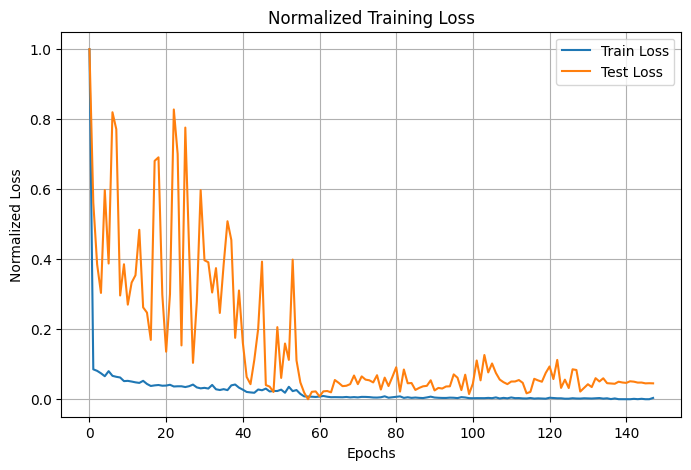

Fold 3
Epoch 0 | Loss train: 10.547764 | Loss test: 0.557201 | lr = 0.01
Epoch 10 | Loss train: 0.407350 | Loss test: 0.463378 | lr = 0.01
Epoch 20 | Loss train: 0.293126 | Loss test: 0.375443 | lr = 0.01
Epoch 30 | Loss train: 0.292974 | Loss test: 0.317274 | lr = 0.01
Epoch 40 | Loss train: 0.222339 | Loss test: 0.339520 | lr = 0.01
Epoch 50 | Loss train: 0.237843 | Loss test: 0.355826 | lr = 0.01
Epoch 60 | Loss train: 0.235146 | Loss test: 0.358924 | lr = 0.01
Epoch 70 | Loss train: 0.199256 | Loss test: 0.366956 | lr = 0.01
Epoch 80 | Loss train: 0.201190 | Loss test: 0.303983 | lr = 0.01
Epoch 90 | Loss train: 0.179259 | Loss test: 0.363371 | lr = 0.01
Epoch 100 | Loss train: 0.150457 | Loss test: 0.276981 | lr = 0.001
Epoch 110 | Loss train: 0.135973 | Loss test: 0.289900 | lr = 0.001
Epoch 120 | Loss train: 0.127501 | Loss test: 0.280508 | lr = 0.001
Epoch 130 | Loss train: 0.124830 | Loss test: 0.283847 | lr = 0.001
Epoch 140 | Loss train: 0.123376 | Loss test: 0.277393 | lr =

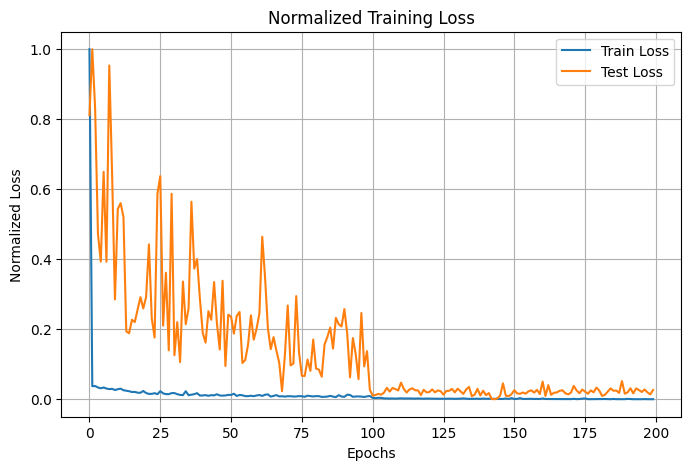

Fold 4
Epoch 0 | Loss train: 8.597273 | Loss test: 0.736252 | lr = 0.01
Epoch 10 | Loss train: 0.370264 | Loss test: 0.430817 | lr = 0.01
Epoch 20 | Loss train: 0.288567 | Loss test: 0.327151 | lr = 0.01
Epoch 30 | Loss train: 0.331716 | Loss test: 0.548618 | lr = 0.01
Epoch 40 | Loss train: 0.267671 | Loss test: 0.307363 | lr = 0.01
Epoch 50 | Loss train: 0.231448 | Loss test: 0.217724 | lr = 0.01
Epoch 60 | Loss train: 0.240350 | Loss test: 0.434761 | lr = 0.01
Epoch 70 | Loss train: 0.156895 | Loss test: 0.237170 | lr = 0.001
Epoch 80 | Loss train: 0.145758 | Loss test: 0.234874 | lr = 0.001
Epoch 90 | Loss train: 0.146042 | Loss test: 0.230448 | lr = 0.001
Epoch 100 | Loss train: 0.141123 | Loss test: 0.230987 | lr = 0.001
Epoch 110 | Loss train: 0.138560 | Loss test: 0.241495 | lr = 0.001
Epoch 120 | Loss train: 0.135595 | Loss test: 0.253548 | lr = 0.001
Epoch 130 | Loss train: 0.136339 | Loss test: 0.265162 | lr = 0.001
Epoch 140 | Loss train: 0.139440 | Loss test: 0.241563 | lr

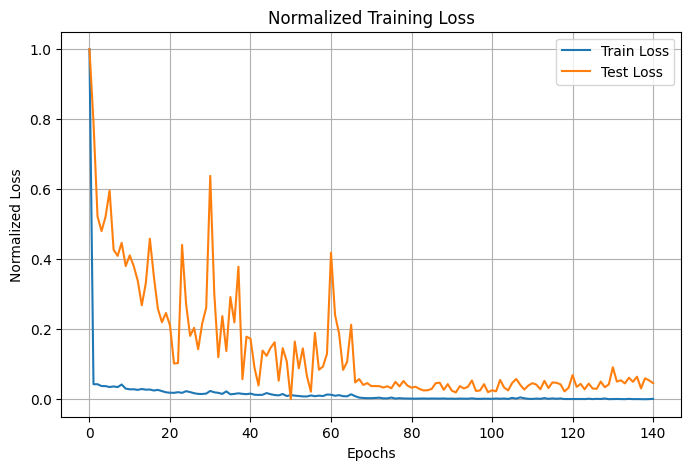

Fold 5
Epoch 0 | Loss train: 8.256300 | Loss test: 0.563386 | lr = 0.01
Epoch 10 | Loss train: 0.346308 | Loss test: 0.351461 | lr = 0.01
Epoch 20 | Loss train: 0.311690 | Loss test: 0.346559 | lr = 0.01
Epoch 30 | Loss train: 0.228590 | Loss test: 0.581208 | lr = 0.01
Epoch 40 | Loss train: 0.234839 | Loss test: 0.325843 | lr = 0.01
Epoch 50 | Loss train: 0.212371 | Loss test: 0.305698 | lr = 0.01
Epoch 60 | Loss train: 0.199618 | Loss test: 0.248025 | lr = 0.01
Epoch 70 | Loss train: 0.184766 | Loss test: 0.289472 | lr = 0.01
Epoch 80 | Loss train: 0.190241 | Loss test: 0.290893 | lr = 0.01
Epoch 90 | Loss train: 0.189996 | Loss test: 0.355097 | lr = 0.001
Epoch 100 | Loss train: 0.121765 | Loss test: 0.266863 | lr = 0.001
Epoch 110 | Loss train: 0.117253 | Loss test: 0.262648 | lr = 0.001
Epoch 120 | Loss train: 0.113821 | Loss test: 0.263465 | lr = 0.001
Epoch 130 | Loss train: 0.112415 | Loss test: 0.264732 | lr = 0.001
Epoch 140 | Loss train: 0.108593 | Loss test: 0.278193 | lr =

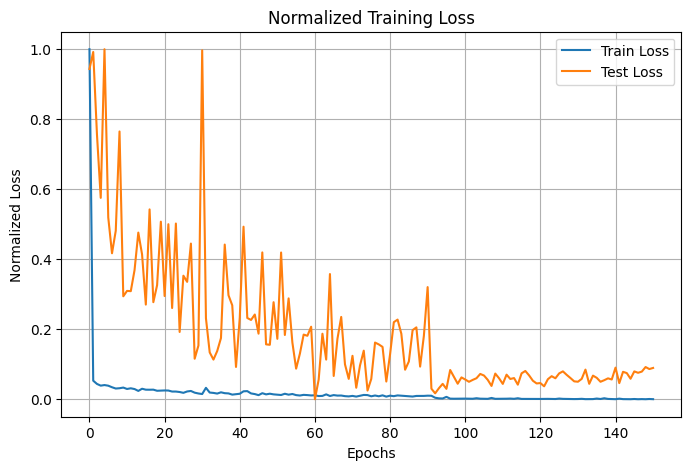

Cross-Validation finished with mean error across 5 subsets = 0.2433936645232496, evaluating final model...
Epoch 0 | Loss train: 2.498805 | lr = 0.01
Epoch 10 | Loss train: 0.352335 | lr = 0.01
Epoch 20 | Loss train: 0.266578 | lr = 0.01
Epoch 30 | Loss train: 0.241129 | lr = 0.01
Epoch 40 | Loss train: 0.231199 | lr = 0.01
Epoch 50 | Loss train: 0.223436 | lr = 0.01
Epoch 60 | Loss train: 0.203226 | lr = 0.01
Epoch 70 | Loss train: 0.194978 | lr = 0.01
Epoch 80 | Loss train: 0.181317 | lr = 0.01
Epoch 90 | Loss train: 0.194298 | lr = 0.01
Epoch 100 | Loss train: 0.135988 | lr = 0.001
Epoch 110 | Loss train: 0.137582 | lr = 0.001
Epoch 120 | Loss train: 0.134793 | lr = 0.001
Epoch 130 | Loss train: 0.127998 | lr = 0.0001
Epoch 140 | Loss train: 0.129587 | lr = 0.0001
Epoch 150 | Loss train: 0.127794 | lr = 0.0001
Epoch 160 | Loss train: 0.126223 | lr = 0.0001
Epoch 170 | Loss train: 0.129168 | lr = 0.0001
Epoch 180 | Loss train: 0.137721 | lr = 0.0001
Epoch 190 | Loss train: 0.137942 |

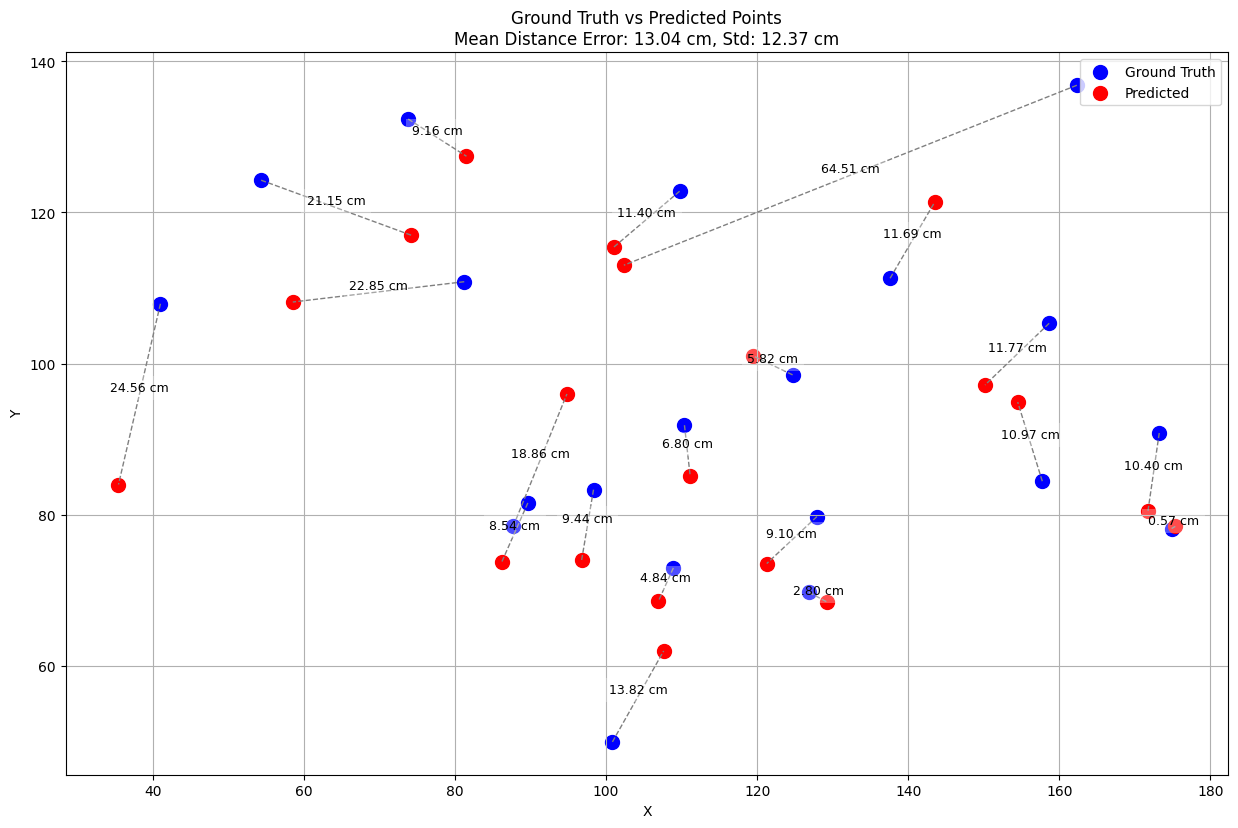

In [19]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 256}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

relu_model_256 = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= ReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [20]:
relu_model_256, relu_model

({'model_name': 'ReLUModel',
  'mean_distance_error_cm': 13.043754577636719,
  'std': 12.366006851196289},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 12.10204792022705,
  'std': 10.484224319458008})

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι καλύτερα, δοκιμάζουμε τέλος με 64. **NOT**

Fold 1
Epoch 0 | Loss train: 0.809176 | Loss test: 0.565425 | lr = 0.01
Epoch 10 | Loss train: 0.379984 | Loss test: 0.425221 | lr = 0.01
Epoch 20 | Loss train: 0.304863 | Loss test: 0.403082 | lr = 0.01
Epoch 30 | Loss train: 0.285322 | Loss test: 0.326960 | lr = 0.01
Epoch 40 | Loss train: 0.226107 | Loss test: 0.334537 | lr = 0.01
Epoch 50 | Loss train: 0.215406 | Loss test: 0.277055 | lr = 0.01
Epoch 60 | Loss train: 0.187280 | Loss test: 0.320560 | lr = 0.01
Epoch 70 | Loss train: 0.188471 | Loss test: 0.369967 | lr = 0.001
Epoch 80 | Loss train: 0.135315 | Loss test: 0.295219 | lr = 0.001
Epoch 90 | Loss train: 0.132368 | Loss test: 0.303533 | lr = 0.001
Epoch 100 | Loss train: 0.129122 | Loss test: 0.304216 | lr = 0.001
Epoch 110 | Loss train: 0.136076 | Loss test: 0.305934 | lr = 0.001
Epoch 120 | Loss train: 0.133705 | Loss test: 0.309537 | lr = 0.001
Epoch 130 | Loss train: 0.130500 | Loss test: 0.321734 | lr = 0.001
Epoch 140 | Loss train: 0.127889 | Loss test: 0.321986 | lr

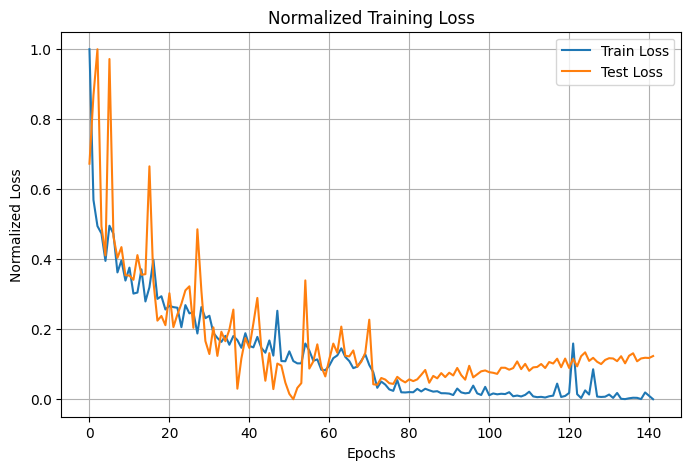

Fold 2
Epoch 0 | Loss train: 0.626422 | Loss test: 0.437542 | lr = 0.01
Epoch 10 | Loss train: 0.319625 | Loss test: 0.290145 | lr = 0.01
Epoch 20 | Loss train: 0.289299 | Loss test: 0.294674 | lr = 0.01
Epoch 30 | Loss train: 0.247359 | Loss test: 0.367007 | lr = 0.01
Epoch 40 | Loss train: 0.234248 | Loss test: 0.301446 | lr = 0.01
Epoch 50 | Loss train: 0.183493 | Loss test: 0.255413 | lr = 0.001
Epoch 60 | Loss train: 0.159379 | Loss test: 0.235620 | lr = 0.001
Epoch 70 | Loss train: 0.153970 | Loss test: 0.242697 | lr = 0.001
Epoch 80 | Loss train: 0.157399 | Loss test: 0.258219 | lr = 0.001
Epoch 90 | Loss train: 0.155743 | Loss test: 0.235406 | lr = 0.001
Epoch 100 | Loss train: 0.139357 | Loss test: 0.236791 | lr = 0.001
Epoch 110 | Loss train: 0.136418 | Loss test: 0.231423 | lr = 0.001
Epoch 120 | Loss train: 0.144746 | Loss test: 0.240828 | lr = 0.001
Epoch 130 | Loss train: 0.134488 | Loss test: 0.227360 | lr = 0.001
Epoch 140 | Loss train: 0.126742 | Loss test: 0.233270 | 

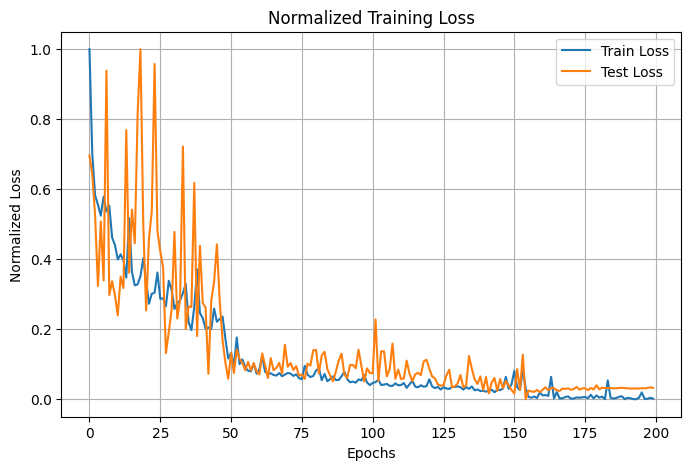

Fold 3
Epoch 0 | Loss train: 0.971261 | Loss test: 0.484097 | lr = 0.01
Epoch 10 | Loss train: 0.339039 | Loss test: 0.376072 | lr = 0.01
Epoch 20 | Loss train: 0.316792 | Loss test: 0.355105 | lr = 0.01
Epoch 30 | Loss train: 0.253472 | Loss test: 0.327600 | lr = 0.01
Epoch 40 | Loss train: 0.270913 | Loss test: 0.325412 | lr = 0.01
Epoch 50 | Loss train: 0.175218 | Loss test: 0.286096 | lr = 0.001
Epoch 60 | Loss train: 0.166004 | Loss test: 0.287847 | lr = 0.001
Epoch 70 | Loss train: 0.154173 | Loss test: 0.299233 | lr = 0.001
Epoch 80 | Loss train: 0.149685 | Loss test: 0.288405 | lr = 0.001
Epoch 90 | Loss train: 0.156358 | Loss test: 0.298021 | lr = 0.001
Epoch 100 | Loss train: 0.145498 | Loss test: 0.287815 | lr = 0.001
Epoch 110 | Loss train: 0.149335 | Loss test: 0.297904 | lr = 0.001
Epoch 120 | Loss train: 0.143033 | Loss test: 0.293620 | lr = 0.001
Epoch 130 | Loss train: 0.136587 | Loss test: 0.294264 | lr = 0.0001
Epoch 140 | Loss train: 0.134558 | Loss test: 0.297902 |

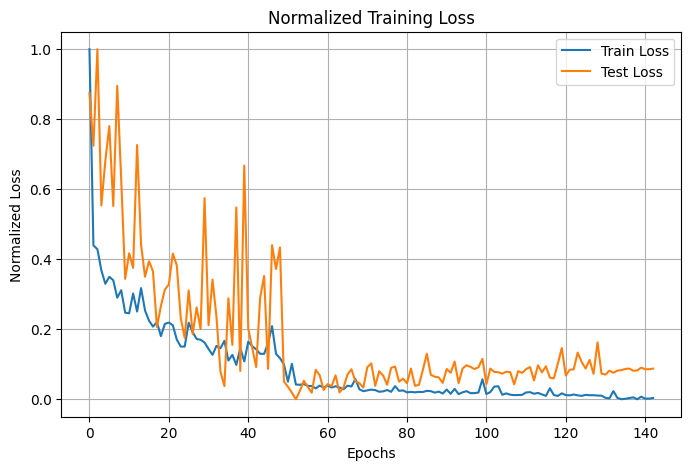

Fold 4
Epoch 0 | Loss train: 0.676395 | Loss test: 0.579997 | lr = 0.01
Epoch 10 | Loss train: 0.351483 | Loss test: 0.350605 | lr = 0.01
Epoch 20 | Loss train: 0.312230 | Loss test: 0.331650 | lr = 0.01
Epoch 30 | Loss train: 0.336684 | Loss test: 0.388042 | lr = 0.01
Epoch 40 | Loss train: 0.278249 | Loss test: 0.319841 | lr = 0.01
Epoch 50 | Loss train: 0.265118 | Loss test: 0.329745 | lr = 0.01
Epoch 60 | Loss train: 0.242371 | Loss test: 0.363136 | lr = 0.01
Epoch 70 | Loss train: 0.168264 | Loss test: 0.262736 | lr = 0.001
Epoch 80 | Loss train: 0.151014 | Loss test: 0.260448 | lr = 0.001
Epoch 90 | Loss train: 0.150424 | Loss test: 0.254908 | lr = 0.001
Epoch 100 | Loss train: 0.146311 | Loss test: 0.240230 | lr = 0.001
Epoch 110 | Loss train: 0.140851 | Loss test: 0.244194 | lr = 0.001
Epoch 120 | Loss train: 0.138969 | Loss test: 0.250707 | lr = 0.001
Epoch 130 | Loss train: 0.136487 | Loss test: 0.257099 | lr = 0.001
Epoch 140 | Loss train: 0.138127 | Loss test: 0.231886 | lr

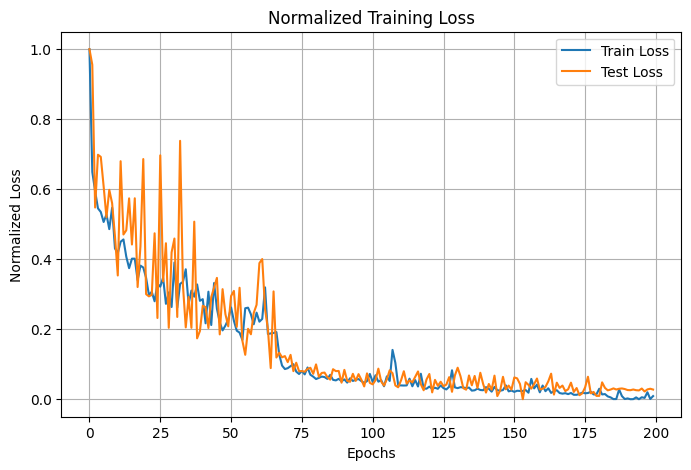

Fold 5
Epoch 0 | Loss train: 0.686261 | Loss test: 0.483896 | lr = 0.01
Epoch 10 | Loss train: 0.330860 | Loss test: 0.480044 | lr = 0.01
Epoch 20 | Loss train: 0.295393 | Loss test: 0.334160 | lr = 0.01
Epoch 30 | Loss train: 0.267550 | Loss test: 0.296740 | lr = 0.01
Epoch 40 | Loss train: 0.272269 | Loss test: 0.277698 | lr = 0.01
Epoch 50 | Loss train: 0.233178 | Loss test: 0.282502 | lr = 0.01
Epoch 60 | Loss train: 0.197070 | Loss test: 0.287274 | lr = 0.01
Epoch 70 | Loss train: 0.189606 | Loss test: 0.260653 | lr = 0.01
Epoch 80 | Loss train: 0.194980 | Loss test: 0.278497 | lr = 0.01
Epoch 90 | Loss train: 0.147912 | Loss test: 0.247272 | lr = 0.001
Epoch 100 | Loss train: 0.145681 | Loss test: 0.251793 | lr = 0.001
Epoch 110 | Loss train: 0.137599 | Loss test: 0.249747 | lr = 0.0001
Epoch 120 | Loss train: 0.137313 | Loss test: 0.248464 | lr = 0.0001
Epoch 130 | Loss train: 0.136422 | Loss test: 0.247461 | lr = 0.0001
Epoch 140 | Loss train: 0.135725 | Loss test: 0.247826 | l

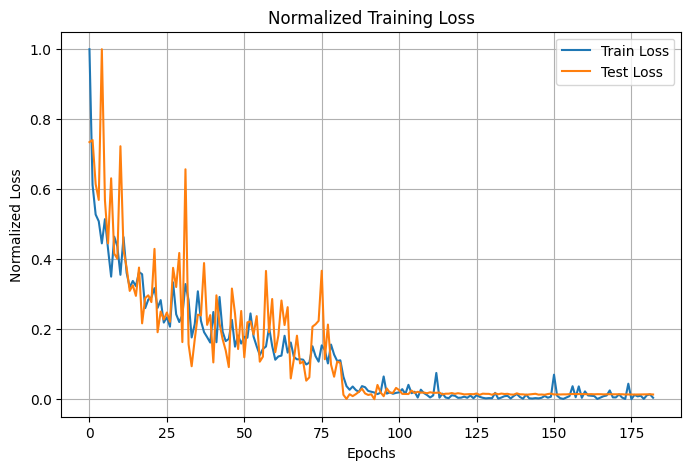

Cross-Validation finished with mean error across 5 subsets = 0.24583031428711752, evaluating final model...
Epoch 0 | Loss train: 0.721736 | lr = 0.01
Epoch 10 | Loss train: 0.347033 | lr = 0.01
Epoch 20 | Loss train: 0.305695 | lr = 0.01
Epoch 30 | Loss train: 0.267709 | lr = 0.01
Epoch 40 | Loss train: 0.273334 | lr = 0.01
Epoch 50 | Loss train: 0.222599 | lr = 0.01
Epoch 60 | Loss train: 0.243051 | lr = 0.01
Epoch 70 | Loss train: 0.220356 | lr = 0.01
Epoch 80 | Loss train: 0.161887 | lr = 0.001
Epoch 90 | Loss train: 0.160099 | lr = 0.001
Epoch 100 | Loss train: 0.154079 | lr = 0.001
Epoch 110 | Loss train: 0.157961 | lr = 0.001
Epoch 120 | Loss train: 0.151836 | lr = 0.001
Epoch 130 | Loss train: 0.145003 | lr = 0.0001
Epoch 140 | Loss train: 0.144462 | lr = 0.0001
Epoch 150 | Loss train: 0.142880 | lr = 0.0001
Epoch 160 | Loss train: 0.141429 | lr = 1e-05
Epoch 170 | Loss train: 0.155794 | lr = 1e-05
Epoch 180 | Loss train: 0.153489 | lr = 1e-05
Epoch 190 | Loss train: 0.156703 |

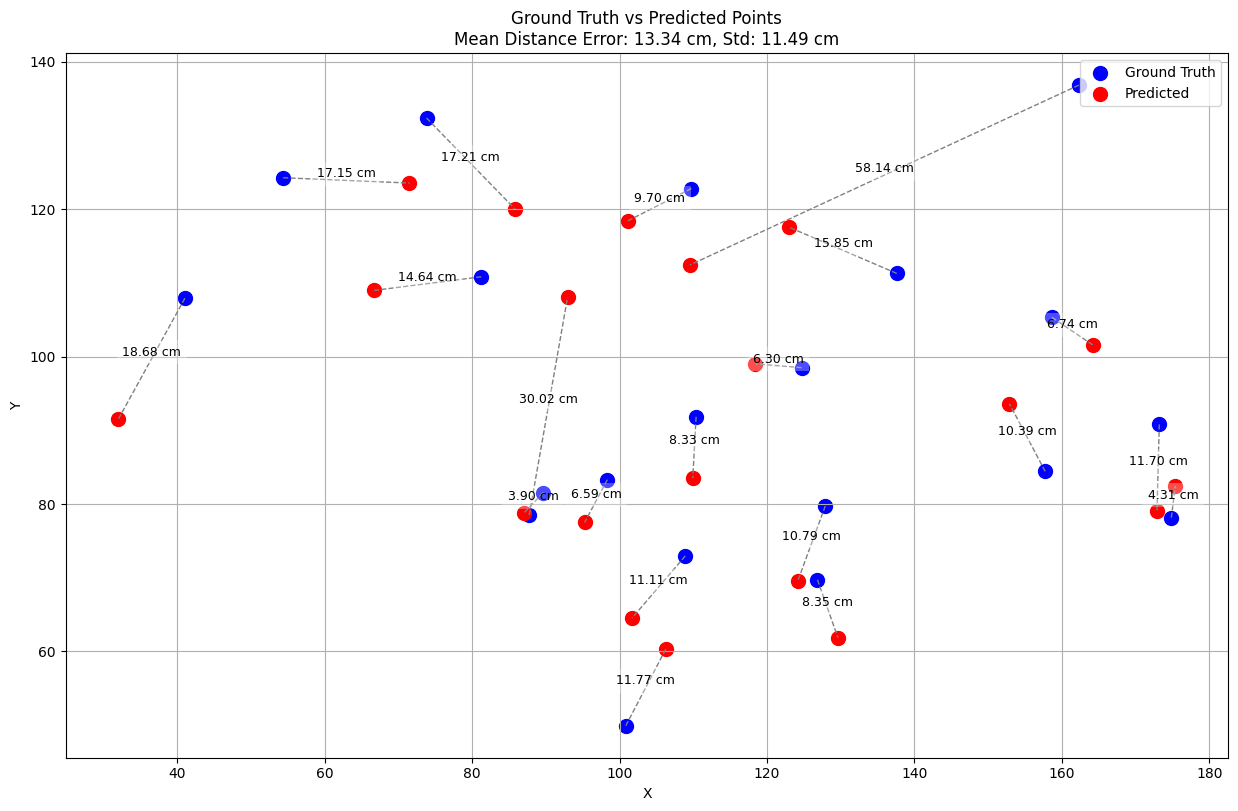

In [21]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

relu_model_64 = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= ReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [22]:
relu_model_256, relu_model_64, relu_model

({'model_name': 'ReLUModel',
  'mean_distance_error_cm': 13.043754577636719,
  'std': 12.366006851196289},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 13.343581199645996,
  'std': 11.486533164978027},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 12.10204792022705,
  'std': 10.484224319458008})

Η καλύτερη περίπτωση φαίνεται να είναι με 64 ```hidden_units```

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [23]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units/2)),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= int(hidden_units/2), out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 2.238700 | Loss test: 0.656819 | lr = 0.01
Epoch 10 | Loss train: 0.406712 | Loss test: 0.394508 | lr = 0.01
Epoch 20 | Loss train: 0.361966 | Loss test: 0.431599 | lr = 0.01
Epoch 30 | Loss train: 0.307782 | Loss test: 0.321813 | lr = 0.01
Epoch 40 | Loss train: 0.240119 | Loss test: 0.347159 | lr = 0.01
Epoch 50 | Loss train: 0.237009 | Loss test: 0.392888 | lr = 0.01
Epoch 60 | Loss train: 0.210081 | Loss test: 0.552338 | lr = 0.01
Epoch 70 | Loss train: 0.311530 | Loss test: 0.476636 | lr = 0.01
Epoch 80 | Loss train: 0.184107 | Loss test: 0.422322 | lr = 0.01
Epoch 90 | Loss train: 0.189548 | Loss test: 0.408834 | lr = 0.01
Epoch 100 | Loss train: 0.188434 | Loss test: 0.345876 | lr = 0.01
Epoch 110 | Loss train: 0.194498 | Loss test: 0.389123 | lr = 0.01
Epoch 120 | Loss train: 0.171322 | Loss test: 0.414092 | lr = 0.001
Epoch 130 | Loss train: 0.114894 | Loss test: 0.336678 | lr = 0.001
Epoch 140 | Loss train: 0.103334 | Loss test: 0.329329 | lr = 0.

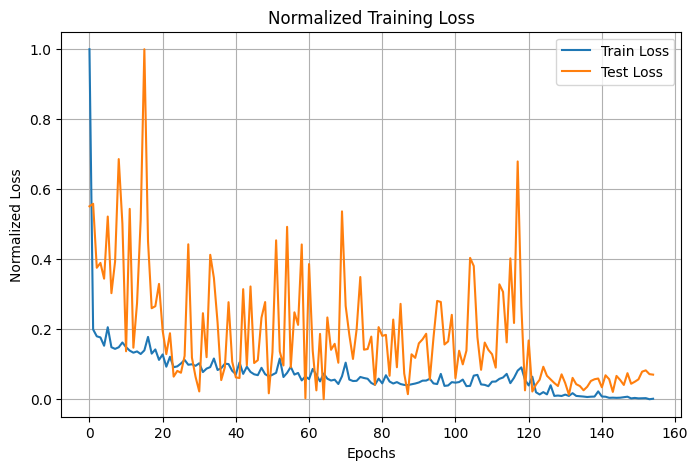

Fold 2
Epoch 0 | Loss train: 1.962766 | Loss test: 1.127323 | lr = 0.01
Epoch 10 | Loss train: 0.384071 | Loss test: 0.312497 | lr = 0.01
Epoch 20 | Loss train: 0.318503 | Loss test: 0.282859 | lr = 0.01
Epoch 30 | Loss train: 0.287102 | Loss test: 0.770999 | lr = 0.01
Epoch 40 | Loss train: 0.246658 | Loss test: 0.270821 | lr = 0.01
Epoch 50 | Loss train: 0.219358 | Loss test: 0.279790 | lr = 0.01
Epoch 60 | Loss train: 0.218211 | Loss test: 0.432315 | lr = 0.01
Epoch 70 | Loss train: 0.229540 | Loss test: 0.372899 | lr = 0.01
Epoch 80 | Loss train: 0.164819 | Loss test: 0.305137 | lr = 0.001
Epoch 90 | Loss train: 0.129613 | Loss test: 0.327832 | lr = 0.001
Epoch 100 | Loss train: 0.124414 | Loss test: 0.351672 | lr = 0.001
Epoch 110 | Loss train: 0.120860 | Loss test: 0.361904 | lr = 0.001
Epoch 120 | Loss train: 0.120253 | Loss test: 0.406149 | lr = 0.001
Epoch 130 | Loss train: 0.102068 | Loss test: 0.393465 | lr = 0.001
Early stopping at epoch 139
Loaded best model from temp_mode

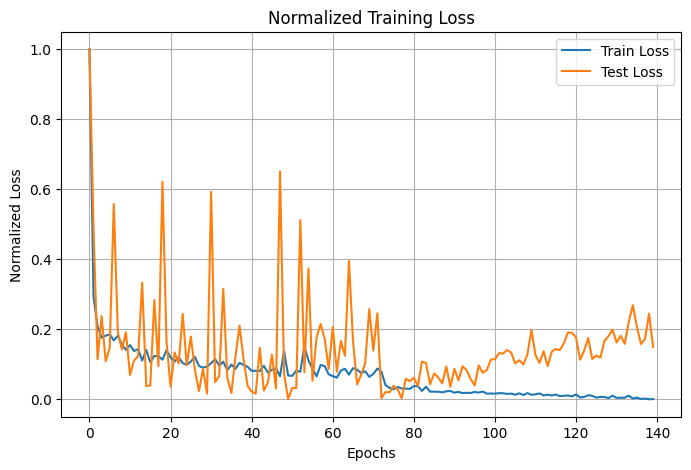

Fold 3
Epoch 0 | Loss train: 4.910162 | Loss test: 0.528040 | lr = 0.01
Epoch 10 | Loss train: 0.419223 | Loss test: 0.553792 | lr = 0.01
Epoch 20 | Loss train: 0.338021 | Loss test: 0.511386 | lr = 0.01
Epoch 30 | Loss train: 0.270511 | Loss test: 0.338843 | lr = 0.01
Epoch 40 | Loss train: 0.331883 | Loss test: 0.294007 | lr = 0.01
Epoch 50 | Loss train: 0.257782 | Loss test: 0.454426 | lr = 0.01
Epoch 60 | Loss train: 0.212277 | Loss test: 0.530007 | lr = 0.01
Epoch 70 | Loss train: 0.230976 | Loss test: 0.409970 | lr = 0.01
Epoch 80 | Loss train: 0.188142 | Loss test: 0.300987 | lr = 0.01
Epoch 90 | Loss train: 0.209205 | Loss test: 0.486158 | lr = 0.01
Epoch 100 | Loss train: 0.127284 | Loss test: 0.275186 | lr = 0.001
Epoch 110 | Loss train: 0.118651 | Loss test: 0.262349 | lr = 0.001
Epoch 120 | Loss train: 0.107607 | Loss test: 0.270330 | lr = 0.001
Epoch 130 | Loss train: 0.104814 | Loss test: 0.277797 | lr = 0.001
Epoch 140 | Loss train: 0.097229 | Loss test: 0.277141 | lr = 

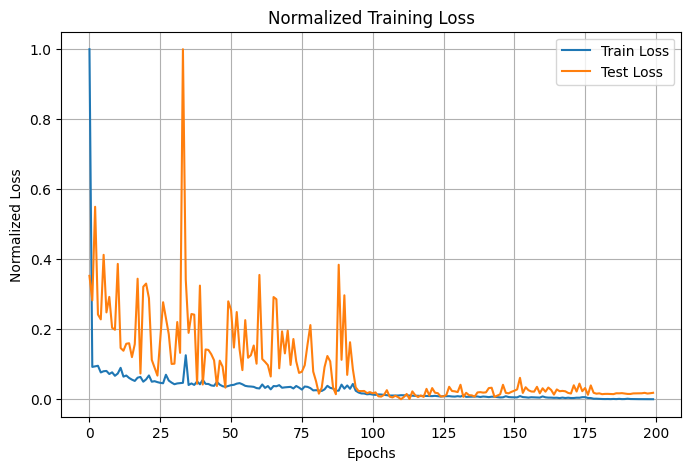

Fold 4
Epoch 0 | Loss train: 1.529381 | Loss test: 1.315737 | lr = 0.01
Epoch 10 | Loss train: 0.401200 | Loss test: 0.373072 | lr = 0.01
Epoch 20 | Loss train: 0.345330 | Loss test: 0.463819 | lr = 0.01
Epoch 30 | Loss train: 0.306473 | Loss test: 0.541425 | lr = 0.01
Epoch 40 | Loss train: 0.335302 | Loss test: 0.335702 | lr = 0.01
Epoch 50 | Loss train: 0.256509 | Loss test: 0.360863 | lr = 0.01
Epoch 60 | Loss train: 0.204923 | Loss test: 0.371545 | lr = 0.01
Epoch 70 | Loss train: 0.214765 | Loss test: 0.290706 | lr = 0.01
Epoch 80 | Loss train: 0.143264 | Loss test: 0.391154 | lr = 0.001
Epoch 90 | Loss train: 0.129038 | Loss test: 0.339345 | lr = 0.001
Epoch 100 | Loss train: 0.125464 | Loss test: 0.364193 | lr = 0.001
Epoch 110 | Loss train: 0.108719 | Loss test: 0.373413 | lr = 0.001
Epoch 120 | Loss train: 0.100898 | Loss test: 0.379901 | lr = 0.001
Epoch 130 | Loss train: 0.091185 | Loss test: 0.407517 | lr = 0.001
Early stopping at epoch 131
Loaded best model from temp_mode

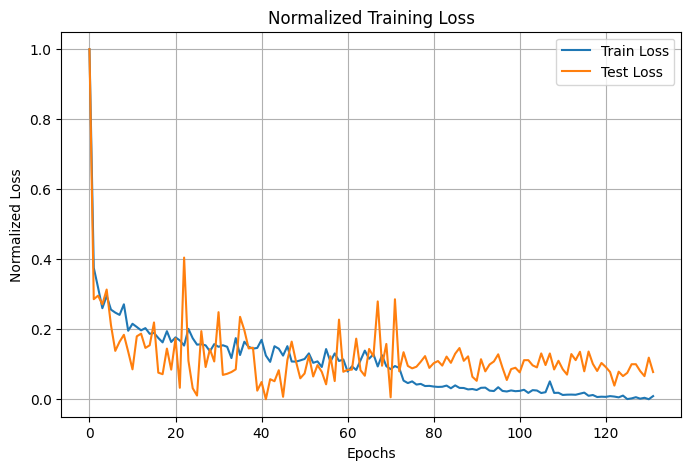

Fold 5
Epoch 0 | Loss train: 2.010692 | Loss test: 0.504588 | lr = 0.01
Epoch 10 | Loss train: 0.399487 | Loss test: 0.497692 | lr = 0.01
Epoch 20 | Loss train: 0.420949 | Loss test: 0.425089 | lr = 0.01
Epoch 30 | Loss train: 0.275214 | Loss test: 0.719887 | lr = 0.01
Epoch 40 | Loss train: 0.291543 | Loss test: 0.309958 | lr = 0.01
Epoch 50 | Loss train: 0.261284 | Loss test: 0.295405 | lr = 0.01
Epoch 60 | Loss train: 0.209216 | Loss test: 0.309729 | lr = 0.01
Epoch 70 | Loss train: 0.137205 | Loss test: 0.269016 | lr = 0.001
Epoch 80 | Loss train: 0.137697 | Loss test: 0.272693 | lr = 0.001
Epoch 90 | Loss train: 0.129584 | Loss test: 0.254803 | lr = 0.001
Epoch 100 | Loss train: 0.116428 | Loss test: 0.263644 | lr = 0.001
Epoch 110 | Loss train: 0.108465 | Loss test: 0.246108 | lr = 0.001
Epoch 120 | Loss train: 0.106923 | Loss test: 0.238712 | lr = 0.001
Epoch 130 | Loss train: 0.099177 | Loss test: 0.258511 | lr = 0.001
Epoch 140 | Loss train: 0.091453 | Loss test: 0.248092 | lr

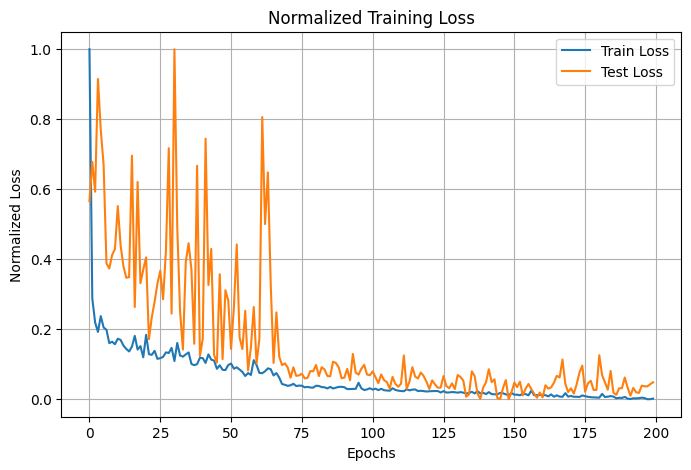

Cross-Validation finished with mean error across 5 subsets = 0.26618712498318586, evaluating final model...
Epoch 0 | Loss train: 1.486744 | lr = 0.01
Epoch 10 | Loss train: 0.365390 | lr = 0.01
Epoch 20 | Loss train: 0.311742 | lr = 0.01
Epoch 30 | Loss train: 0.275088 | lr = 0.01
Epoch 40 | Loss train: 0.224022 | lr = 0.01
Epoch 50 | Loss train: 0.226045 | lr = 0.01
Epoch 60 | Loss train: 0.217627 | lr = 0.01
Epoch 70 | Loss train: 0.139165 | lr = 0.001
Epoch 80 | Loss train: 0.125994 | lr = 0.001
Epoch 90 | Loss train: 0.123343 | lr = 0.001
Epoch 100 | Loss train: 0.107911 | lr = 0.001
Epoch 110 | Loss train: 0.099199 | lr = 0.001
Epoch 120 | Loss train: 0.101478 | lr = 0.001
Epoch 130 | Loss train: 0.091822 | lr = 0.001
Epoch 140 | Loss train: 0.084259 | lr = 0.001
Epoch 150 | Loss train: 0.078810 | lr = 0.001
Epoch 160 | Loss train: 0.077966 | lr = 0.001
Epoch 170 | Loss train: 0.076038 | lr = 0.001
Epoch 180 | Loss train: 0.081107 | lr = 0.001
Epoch 190 | Loss train: 0.078169 | l

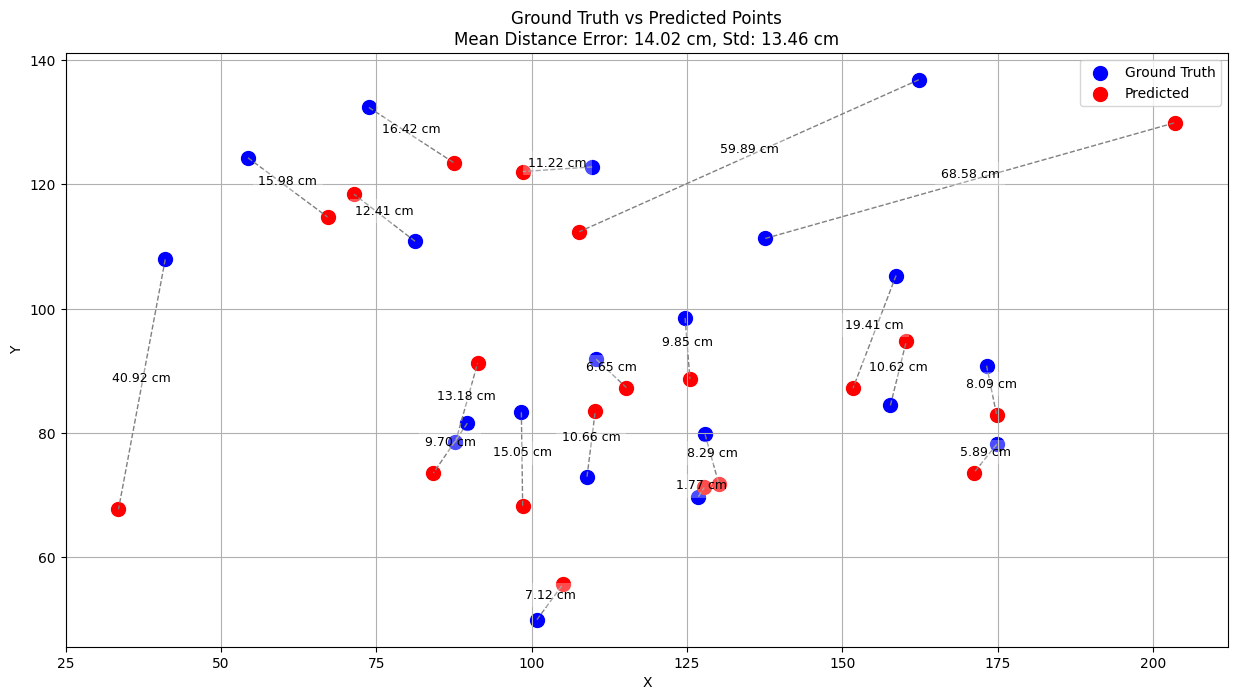

In [24]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 128}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= LeakyReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [25]:
leakyrelu

{'model_name': 'LeakyReLUModel',
 'mean_distance_error_cm': 14.022871017456055,
 'std': 13.459556579589844}

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [41]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 0.686302 | Loss test: 0.632578 | lr = 0.01
Epoch 10 | Loss train: 0.525261 | Loss test: 0.550769 | lr = 0.01
Epoch 20 | Loss train: 0.447337 | Loss test: 0.636868 | lr = 0.01
Epoch 30 | Loss train: 0.436277 | Loss test: 0.533587 | lr = 0.01
Epoch 40 | Loss train: 0.412904 | Loss test: 0.736313 | lr = 0.01
Epoch 50 | Loss train: 0.387682 | Loss test: 0.630004 | lr = 0.01
Epoch 60 | Loss train: 0.353735 | Loss test: 0.424035 | lr = 0.001
Epoch 70 | Loss train: 0.333714 | Loss test: 0.452008 | lr = 0.001
Epoch 80 | Loss train: 0.323626 | Loss test: 0.462515 | lr = 0.001
Epoch 90 | Loss train: 0.314511 | Loss test: 0.462688 | lr = 0.001
Epoch 100 | Loss train: 0.309718 | Loss test: 0.458819 | lr = 0.001
Epoch 110 | Loss train: 0.320366 | Loss test: 0.458161 | lr = 0.001
Epoch 120 | Loss train: 0.312056 | Loss test: 0.454468 | lr = 0.001
Epoch 130 | Loss train: 0.288214 | Loss test: 0.454691 | lr = 0.0001
Epoch 140 | Loss train: 0.300142 | Loss test: 0.454837 | 

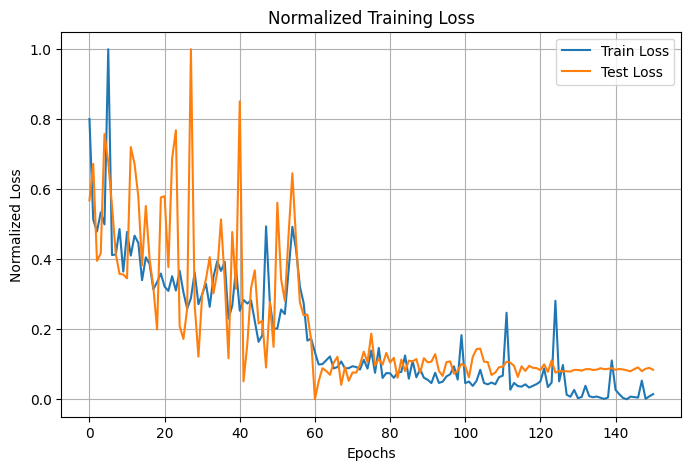

Fold 2
Epoch 0 | Loss train: 0.636450 | Loss test: 0.532948 | lr = 0.01
Epoch 10 | Loss train: 0.498044 | Loss test: 0.366085 | lr = 0.01
Epoch 20 | Loss train: 0.473501 | Loss test: 0.434052 | lr = 0.01
Epoch 30 | Loss train: 0.389753 | Loss test: 0.336679 | lr = 0.001
Epoch 40 | Loss train: 0.354515 | Loss test: 0.323093 | lr = 0.001
Epoch 50 | Loss train: 0.344056 | Loss test: 0.311106 | lr = 0.001
Epoch 60 | Loss train: 0.299290 | Loss test: 0.318725 | lr = 0.001
Epoch 70 | Loss train: 0.277358 | Loss test: 0.310976 | lr = 0.001
Epoch 80 | Loss train: 0.282869 | Loss test: 0.322698 | lr = 0.001
Epoch 90 | Loss train: 0.276559 | Loss test: 0.348590 | lr = 0.001
Epoch 100 | Loss train: 0.242102 | Loss test: 0.348730 | lr = 0.001
Epoch 110 | Loss train: 0.229757 | Loss test: 0.279025 | lr = 0.001
Epoch 120 | Loss train: 0.238349 | Loss test: 0.346820 | lr = 0.001
Epoch 130 | Loss train: 0.207892 | Loss test: 0.280046 | lr = 0.001
Epoch 140 | Loss train: 0.204240 | Loss test: 0.294080 

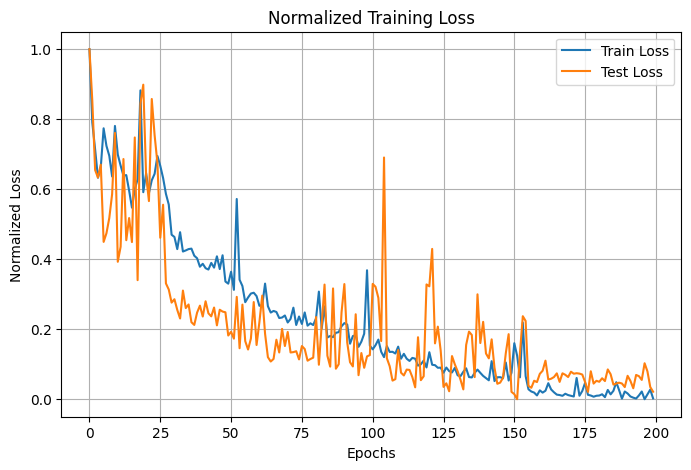

Fold 3
Epoch 0 | Loss train: 0.852985 | Loss test: 0.705048 | lr = 0.01
Epoch 10 | Loss train: 0.531556 | Loss test: 0.501836 | lr = 0.01
Epoch 20 | Loss train: 0.473189 | Loss test: 0.461859 | lr = 0.001
Epoch 30 | Loss train: 0.463172 | Loss test: 0.475095 | lr = 0.001
Epoch 40 | Loss train: 0.460922 | Loss test: 0.465710 | lr = 0.001
Epoch 50 | Loss train: 0.440330 | Loss test: 0.467107 | lr = 0.001
Epoch 60 | Loss train: 0.469107 | Loss test: 0.454091 | lr = 0.001
Epoch 70 | Loss train: 0.395414 | Loss test: 0.435360 | lr = 0.001
Epoch 80 | Loss train: 0.378005 | Loss test: 0.430345 | lr = 0.001
Epoch 90 | Loss train: 0.401654 | Loss test: 0.404755 | lr = 0.001
Epoch 100 | Loss train: 0.353342 | Loss test: 0.397451 | lr = 0.001
Epoch 110 | Loss train: 0.329066 | Loss test: 0.409719 | lr = 0.001
Epoch 120 | Loss train: 0.323288 | Loss test: 0.376074 | lr = 0.001
Epoch 130 | Loss train: 0.286579 | Loss test: 0.346336 | lr = 0.001
Epoch 140 | Loss train: 0.264440 | Loss test: 0.346103

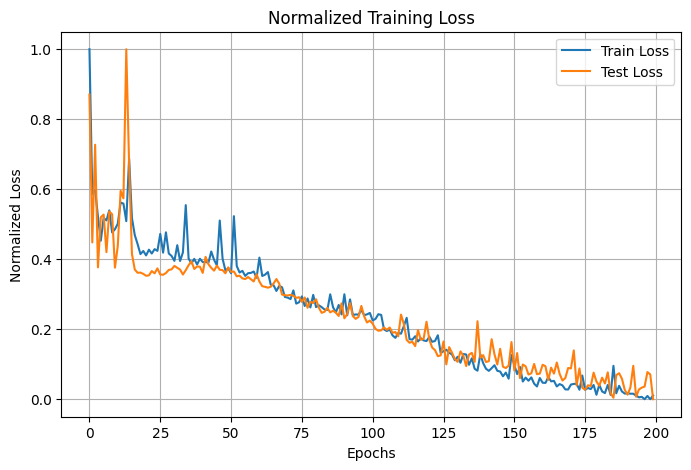

Fold 4
Epoch 0 | Loss train: 0.772712 | Loss test: 0.654562 | lr = 0.01
Epoch 10 | Loss train: 0.501021 | Loss test: 0.556204 | lr = 0.01
Epoch 20 | Loss train: 0.517935 | Loss test: 0.613127 | lr = 0.01
Epoch 30 | Loss train: 0.490727 | Loss test: 0.507234 | lr = 0.001
Epoch 40 | Loss train: 0.428464 | Loss test: 0.463470 | lr = 0.001
Epoch 50 | Loss train: 0.382366 | Loss test: 0.446164 | lr = 0.001
Epoch 60 | Loss train: 0.370177 | Loss test: 0.461217 | lr = 0.001
Epoch 70 | Loss train: 0.357129 | Loss test: 0.433381 | lr = 0.001
Epoch 80 | Loss train: 0.349761 | Loss test: 0.453541 | lr = 0.001
Epoch 90 | Loss train: 0.344120 | Loss test: 0.441611 | lr = 0.001
Epoch 100 | Loss train: 0.335058 | Loss test: 0.434207 | lr = 0.001
Epoch 110 | Loss train: 0.326812 | Loss test: 0.425736 | lr = 0.001
Epoch 120 | Loss train: 0.321096 | Loss test: 0.437092 | lr = 0.001
Epoch 130 | Loss train: 0.297139 | Loss test: 0.426934 | lr = 0.001
Epoch 140 | Loss train: 0.308865 | Loss test: 0.390460 

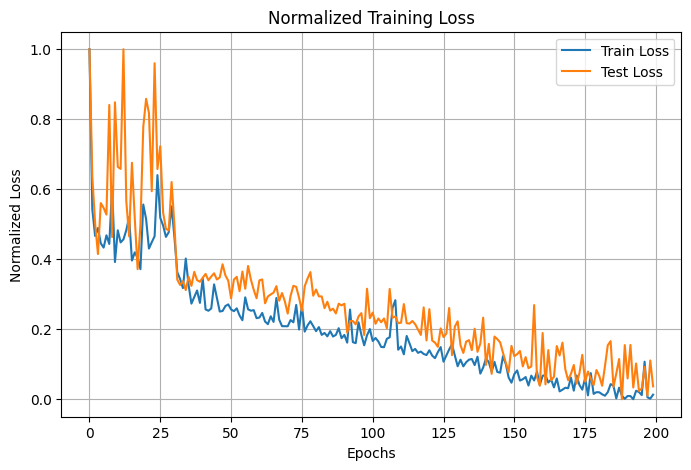

Fold 5
Epoch 0 | Loss train: 0.664948 | Loss test: 0.549500 | lr = 0.01
Epoch 10 | Loss train: 0.441000 | Loss test: 0.518101 | lr = 0.01
Epoch 20 | Loss train: 0.477534 | Loss test: 0.469416 | lr = 0.01
Epoch 30 | Loss train: 0.363353 | Loss test: 0.429188 | lr = 0.001
Epoch 40 | Loss train: 0.323276 | Loss test: 0.400117 | lr = 0.001
Epoch 50 | Loss train: 0.319217 | Loss test: 0.404834 | lr = 0.001
Epoch 60 | Loss train: 0.299842 | Loss test: 0.390313 | lr = 0.001
Epoch 70 | Loss train: 0.289528 | Loss test: 0.371032 | lr = 0.001
Epoch 80 | Loss train: 0.283618 | Loss test: 0.389568 | lr = 0.001
Epoch 90 | Loss train: 0.288603 | Loss test: 0.368879 | lr = 0.001
Epoch 100 | Loss train: 0.260889 | Loss test: 0.368479 | lr = 0.001
Epoch 110 | Loss train: 0.260678 | Loss test: 0.358775 | lr = 0.001
Epoch 120 | Loss train: 0.242231 | Loss test: 0.353792 | lr = 0.001
Epoch 130 | Loss train: 0.241075 | Loss test: 0.367219 | lr = 0.001
Epoch 140 | Loss train: 0.226077 | Loss test: 0.362468 

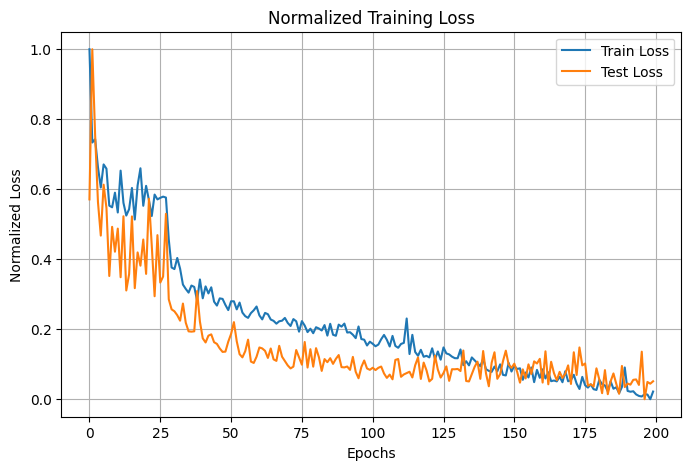

Cross-Validation finished with mean error across 5 subsets = 0.3349550084698768, evaluating final model...
Epoch 0 | Loss train: 0.724072 | lr = 0.01
Epoch 10 | Loss train: 0.483091 | lr = 0.01
Epoch 20 | Loss train: 0.442095 | lr = 0.01
Epoch 30 | Loss train: 0.427626 | lr = 0.001
Epoch 40 | Loss train: 0.364113 | lr = 0.001
Epoch 50 | Loss train: 0.362575 | lr = 0.001
Epoch 60 | Loss train: 0.339555 | lr = 0.001
Epoch 70 | Loss train: 0.324340 | lr = 0.001
Epoch 80 | Loss train: 0.318820 | lr = 0.001
Epoch 90 | Loss train: 0.325524 | lr = 0.001
Epoch 100 | Loss train: 0.294660 | lr = 0.001
Epoch 110 | Loss train: 0.370936 | lr = 0.001
Epoch 120 | Loss train: 0.294337 | lr = 0.001
Epoch 130 | Loss train: 0.284014 | lr = 0.001
Epoch 140 | Loss train: 0.282404 | lr = 0.001
Epoch 150 | Loss train: 0.276038 | lr = 0.001
Epoch 160 | Loss train: 0.263341 | lr = 0.001
Epoch 170 | Loss train: 0.253434 | lr = 0.001
Epoch 180 | Loss train: 0.260614 | lr = 0.001
Epoch 190 | Loss train: 0.249862 

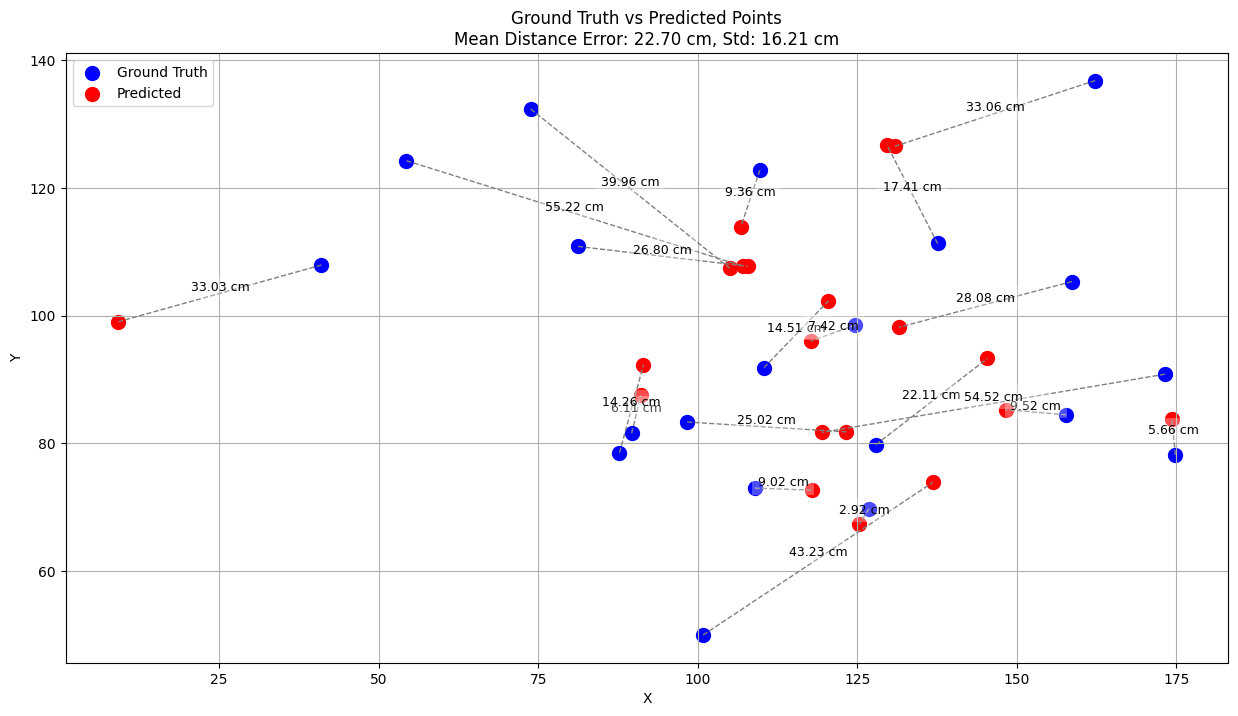

In [42]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

tanh_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= tanhModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [43]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 0.636063 | Loss test: 0.613090 | lr = 0.01
Epoch 10 | Loss train: 0.424623 | Loss test: 0.584393 | lr = 0.01
Epoch 20 | Loss train: 0.343463 | Loss test: 0.447677 | lr = 0.01
Epoch 30 | Loss train: 0.317512 | Loss test: 0.393409 | lr = 0.01
Epoch 40 | Loss train: 0.292605 | Loss test: 0.441469 | lr = 0.01
Epoch 50 | Loss train: 0.304702 | Loss test: 0.438998 | lr = 0.01
Epoch 60 | Loss train: 0.281435 | Loss test: 0.456034 | lr = 0.01
Epoch 70 | Loss train: 0.228772 | Loss test: 0.411168 | lr = 0.001
Epoch 80 | Loss train: 0.219825 | Loss test: 0.397362 | lr = 0.001
Epoch 90 | Loss train: 0.207675 | Loss test: 0.399472 | lr = 0.001
Epoch 100 | Loss train: 0.200867 | Loss test: 0.401079 | lr = 0.001
Epoch 110 | Loss train: 0.215024 | Loss test: 0.399342 | lr = 0.001
Epoch 120 | Loss train: 0.210892 | Loss test: 0.405479 | lr = 0.001
Epoch 130 | Loss train: 0.196329 | Loss test: 0.408025 | lr = 0.001
Epoch 140 | Loss train: 0.207664 | Loss test: 0.408696 | lr

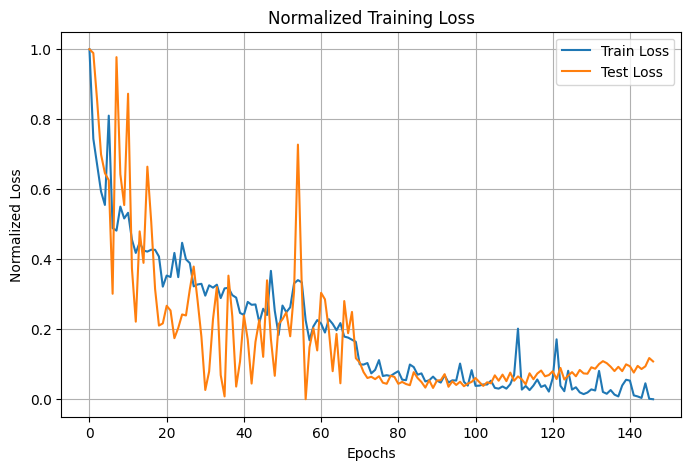

Fold 2
Epoch 0 | Loss train: 0.658652 | Loss test: 0.444880 | lr = 0.01
Epoch 10 | Loss train: 0.378366 | Loss test: 0.320221 | lr = 0.01
Epoch 20 | Loss train: 0.339234 | Loss test: 0.434251 | lr = 0.01
Epoch 30 | Loss train: 0.314468 | Loss test: 0.355200 | lr = 0.01
Epoch 40 | Loss train: 0.281479 | Loss test: 0.324784 | lr = 0.01
Epoch 50 | Loss train: 0.274948 | Loss test: 0.382677 | lr = 0.01
Epoch 60 | Loss train: 0.244067 | Loss test: 0.355164 | lr = 0.001
Epoch 70 | Loss train: 0.227017 | Loss test: 0.349150 | lr = 0.001
Epoch 80 | Loss train: 0.248764 | Loss test: 0.346446 | lr = 0.001
Epoch 90 | Loss train: 0.214375 | Loss test: 0.356022 | lr = 0.001
Epoch 100 | Loss train: 0.211047 | Loss test: 0.347726 | lr = 0.001
Epoch 110 | Loss train: 0.211338 | Loss test: 0.353906 | lr = 0.001
Early stopping at epoch 113
Loaded best model from temp_model.pth


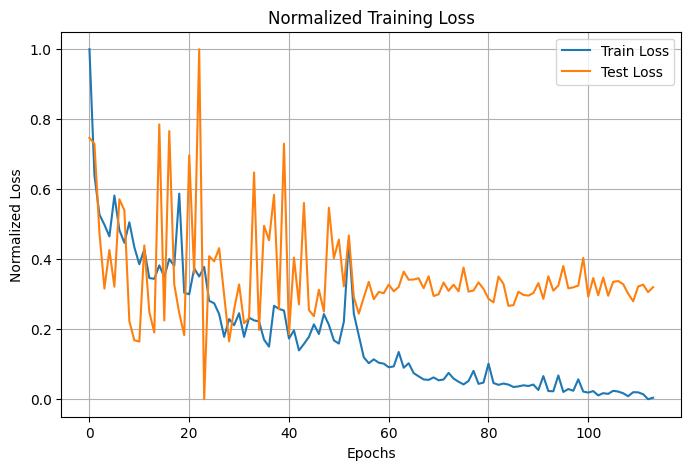

Fold 3
Epoch 0 | Loss train: 0.938189 | Loss test: 0.585577 | lr = 0.01
Epoch 10 | Loss train: 0.422220 | Loss test: 0.421299 | lr = 0.01
Epoch 20 | Loss train: 0.360393 | Loss test: 0.375441 | lr = 0.01
Epoch 30 | Loss train: 0.313889 | Loss test: 0.378702 | lr = 0.01
Epoch 40 | Loss train: 0.344550 | Loss test: 0.345571 | lr = 0.01
Epoch 50 | Loss train: 0.267956 | Loss test: 0.349082 | lr = 0.001
Epoch 60 | Loss train: 0.258099 | Loss test: 0.337715 | lr = 0.001
Epoch 70 | Loss train: 0.237576 | Loss test: 0.337073 | lr = 0.001
Epoch 80 | Loss train: 0.232103 | Loss test: 0.339222 | lr = 0.001
Epoch 90 | Loss train: 0.242582 | Loss test: 0.337828 | lr = 0.001
Epoch 100 | Loss train: 0.221181 | Loss test: 0.341006 | lr = 0.001
Epoch 110 | Loss train: 0.222713 | Loss test: 0.339730 | lr = 0.001
Epoch 120 | Loss train: 0.214516 | Loss test: 0.341106 | lr = 0.001
Epoch 130 | Loss train: 0.201898 | Loss test: 0.339078 | lr = 0.001
Epoch 140 | Loss train: 0.196702 | Loss test: 0.343514 | 

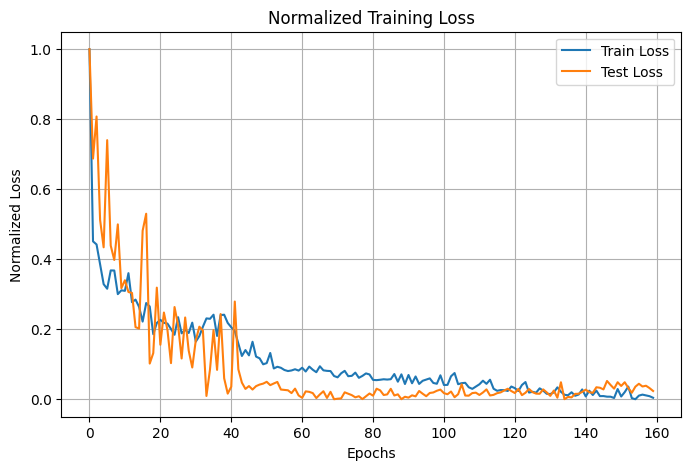

Fold 4
Epoch 0 | Loss train: 0.759109 | Loss test: 0.591339 | lr = 0.01
Epoch 10 | Loss train: 0.381865 | Loss test: 0.444433 | lr = 0.01
Epoch 20 | Loss train: 0.346252 | Loss test: 0.430883 | lr = 0.01
Epoch 30 | Loss train: 0.347624 | Loss test: 0.478671 | lr = 0.01
Epoch 40 | Loss train: 0.326823 | Loss test: 0.358821 | lr = 0.001
Epoch 50 | Loss train: 0.253819 | Loss test: 0.334433 | lr = 0.001
Epoch 60 | Loss train: 0.239316 | Loss test: 0.325103 | lr = 0.001
Epoch 70 | Loss train: 0.233030 | Loss test: 0.327997 | lr = 0.001
Epoch 80 | Loss train: 0.227736 | Loss test: 0.327643 | lr = 0.001
Epoch 90 | Loss train: 0.220721 | Loss test: 0.331553 | lr = 0.001
Epoch 100 | Loss train: 0.217866 | Loss test: 0.321140 | lr = 0.001
Epoch 110 | Loss train: 0.222769 | Loss test: 0.330315 | lr = 0.001
Epoch 120 | Loss train: 0.210361 | Loss test: 0.325436 | lr = 0.001
Epoch 130 | Loss train: 0.211127 | Loss test: 0.320823 | lr = 0.001
Epoch 140 | Loss train: 0.213550 | Loss test: 0.325165 |

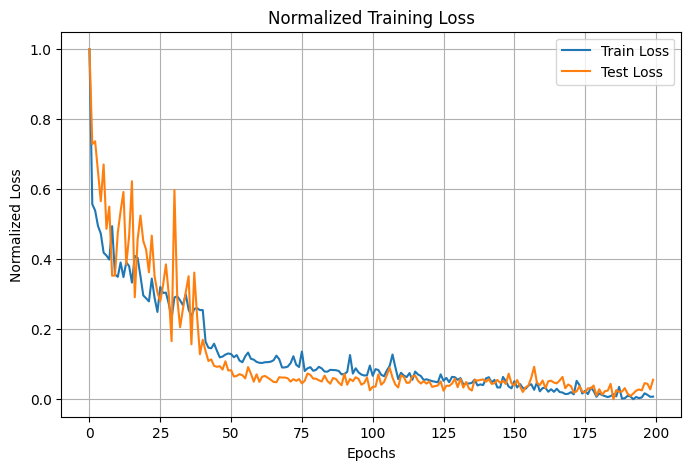

Fold 5
Epoch 0 | Loss train: 0.636546 | Loss test: 0.546317 | lr = 0.01
Epoch 10 | Loss train: 0.395577 | Loss test: 0.428090 | lr = 0.01
Epoch 20 | Loss train: 0.341437 | Loss test: 0.395361 | lr = 0.01
Epoch 30 | Loss train: 0.281516 | Loss test: 0.352361 | lr = 0.01
Epoch 40 | Loss train: 0.295501 | Loss test: 0.348711 | lr = 0.01
Epoch 50 | Loss train: 0.221651 | Loss test: 0.339235 | lr = 0.001
Epoch 60 | Loss train: 0.212509 | Loss test: 0.333484 | lr = 0.001
Epoch 70 | Loss train: 0.202459 | Loss test: 0.330391 | lr = 0.001
Epoch 80 | Loss train: 0.198579 | Loss test: 0.322878 | lr = 0.001
Epoch 90 | Loss train: 0.206169 | Loss test: 0.315588 | lr = 0.001
Epoch 100 | Loss train: 0.190612 | Loss test: 0.319795 | lr = 0.001
Epoch 110 | Loss train: 0.187406 | Loss test: 0.317294 | lr = 0.001
Epoch 120 | Loss train: 0.180022 | Loss test: 0.315600 | lr = 0.001
Epoch 130 | Loss train: 0.179425 | Loss test: 0.318040 | lr = 0.001
Epoch 140 | Loss train: 0.172438 | Loss test: 0.318082 | 

Cross-Validation finished with mean error across 5 subsets = 0.32582170746865724, evaluating final model...
Epoch 0 | Loss train: 0.648874 | lr = 0.01
Epoch 10 | Loss train: 0.378530 | lr = 0.01
Epoch 20 | Loss train: 0.382707 | lr = 0.01
Epoch 30 | Loss train: 0.283380 | lr = 0.001
Epoch 40 | Loss train: 0.263523 | lr = 0.001
Epoch 50 | Loss train: 0.257017 | lr = 0.001
Epoch 60 | Loss train: 0.245623 | lr = 0.001
Epoch 70 | Loss train: 0.239908 | lr = 0.001
Epoch 80 | Loss train: 0.229331 | lr = 0.001
Epoch 90 | Loss train: 0.247281 | lr = 0.001
Epoch 100 | Loss train: 0.213204 | lr = 0.001
Epoch 110 | Loss train: 0.223952 | lr = 0.001
Epoch 120 | Loss train: 0.203268 | lr = 0.001
Epoch 130 | Loss train: 0.196127 | lr = 0.001
Epoch 140 | Loss train: 0.189341 | lr = 0.001
Epoch 150 | Loss train: 0.187117 | lr = 0.001
Epoch 160 | Loss train: 0.177042 | lr = 0.001
Epoch 170 | Loss train: 0.176899 | lr = 0.001
Epoch 180 | Loss train: 0.182847 | lr = 0.001
Epoch 190 | Loss train: 0.176080

In [44]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

sigmoid_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= sigmoidModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

### Αρχιτεκτονική 3

#### +1 Layer

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [26]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 0.673209 | Loss test: 0.585360 | lr = 0.01
Epoch 10 | Loss train: 0.423984 | Loss test: 0.490858 | lr = 0.01
Epoch 20 | Loss train: 0.275675 | Loss test: 0.408890 | lr = 0.01
Epoch 30 | Loss train: 0.293990 | Loss test: 0.454901 | lr = 0.01
Epoch 40 | Loss train: 0.231225 | Loss test: 0.357155 | lr = 0.01
Epoch 50 | Loss train: 0.215242 | Loss test: 0.350654 | lr = 0.01
Epoch 60 | Loss train: 0.191948 | Loss test: 0.412501 | lr = 0.01
Epoch 70 | Loss train: 0.250385 | Loss test: 0.345909 | lr = 0.01
Epoch 80 | Loss train: 0.128971 | Loss test: 0.300094 | lr = 0.001
Epoch 90 | Loss train: 0.112118 | Loss test: 0.291705 | lr = 0.001
Epoch 100 | Loss train: 0.099271 | Loss test: 0.297636 | lr = 0.001
Epoch 110 | Loss train: 0.095498 | Loss test: 0.305127 | lr = 0.001
Epoch 120 | Loss train: 0.086679 | Loss test: 0.319397 | lr = 0.001
Epoch 130 | Loss train: 0.078433 | Loss test: 0.342909 | lr = 0.001
Early stopping at epoch 139
Loaded best model from temp_mode

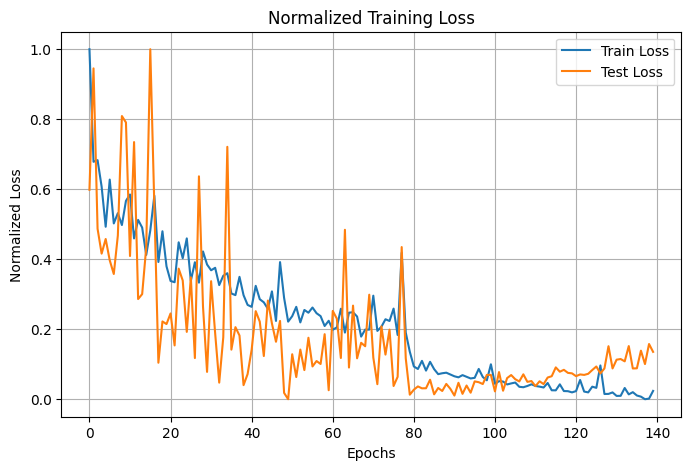

Fold 2
Epoch 0 | Loss train: 0.824150 | Loss test: 0.427792 | lr = 0.01
Epoch 10 | Loss train: 0.346818 | Loss test: 0.270542 | lr = 0.01
Epoch 20 | Loss train: 0.291008 | Loss test: 0.397593 | lr = 0.01
Epoch 30 | Loss train: 0.253273 | Loss test: 0.461195 | lr = 0.01
Epoch 40 | Loss train: 0.287619 | Loss test: 0.286178 | lr = 0.01
Epoch 50 | Loss train: 0.209052 | Loss test: 0.270617 | lr = 0.01
Epoch 60 | Loss train: 0.191118 | Loss test: 0.379677 | lr = 0.01
Epoch 70 | Loss train: 0.238144 | Loss test: 0.357324 | lr = 0.01
Epoch 80 | Loss train: 0.144032 | Loss test: 0.249496 | lr = 0.001
Epoch 90 | Loss train: 0.119484 | Loss test: 0.226556 | lr = 0.001
Epoch 100 | Loss train: 0.114159 | Loss test: 0.238841 | lr = 0.001
Epoch 110 | Loss train: 0.107780 | Loss test: 0.202222 | lr = 0.001
Epoch 120 | Loss train: 0.102745 | Loss test: 0.239348 | lr = 0.001
Epoch 130 | Loss train: 0.088658 | Loss test: 0.233744 | lr = 0.001
Epoch 140 | Loss train: 0.080286 | Loss test: 0.264955 | lr 

Fold 3
Epoch 0 | Loss train: 0.805024 | Loss test: 0.560508 | lr = 0.01
Epoch 10 | Loss train: 0.396999 | Loss test: 0.457519 | lr = 0.01
Epoch 20 | Loss train: 0.317611 | Loss test: 0.334689 | lr = 0.01
Epoch 30 | Loss train: 0.242501 | Loss test: 0.308423 | lr = 0.01
Epoch 40 | Loss train: 0.218641 | Loss test: 0.365354 | lr = 0.01
Epoch 50 | Loss train: 0.234741 | Loss test: 0.350744 | lr = 0.01
Epoch 60 | Loss train: 0.139714 | Loss test: 0.282492 | lr = 0.001
Epoch 70 | Loss train: 0.121388 | Loss test: 0.278685 | lr = 0.001
Epoch 80 | Loss train: 0.117139 | Loss test: 0.298621 | lr = 0.001
Epoch 90 | Loss train: 0.113229 | Loss test: 0.289321 | lr = 0.001
Epoch 100 | Loss train: 0.095262 | Loss test: 0.297782 | lr = 0.001
Epoch 110 | Loss train: 0.096180 | Loss test: 0.301267 | lr = 0.001
Epoch 120 | Loss train: 0.083539 | Loss test: 0.329136 | lr = 0.001
Epoch 130 | Loss train: 0.072380 | Loss test: 0.319191 | lr = 0.001
Epoch 140 | Loss train: 0.069903 | Loss test: 0.317057 | l

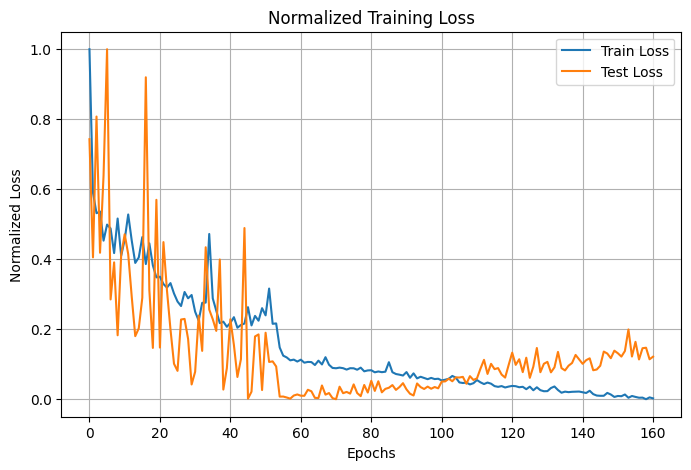

Fold 4
Epoch 0 | Loss train: 0.673452 | Loss test: 1.301414 | lr = 0.01
Epoch 10 | Loss train: 0.380241 | Loss test: 0.369941 | lr = 0.01
Epoch 20 | Loss train: 0.329447 | Loss test: 0.333500 | lr = 0.01
Epoch 30 | Loss train: 0.299265 | Loss test: 0.276558 | lr = 0.01
Epoch 40 | Loss train: 0.316676 | Loss test: 0.310826 | lr = 0.01
Epoch 50 | Loss train: 0.277256 | Loss test: 0.266520 | lr = 0.01
Epoch 60 | Loss train: 0.199153 | Loss test: 0.326035 | lr = 0.01
Epoch 70 | Loss train: 0.200395 | Loss test: 0.233247 | lr = 0.01
Epoch 80 | Loss train: 0.131375 | Loss test: 0.226356 | lr = 0.001
Epoch 90 | Loss train: 0.119596 | Loss test: 0.219713 | lr = 0.001
Epoch 100 | Loss train: 0.109413 | Loss test: 0.270777 | lr = 0.001
Epoch 110 | Loss train: 0.097777 | Loss test: 0.283006 | lr = 0.001
Epoch 120 | Loss train: 0.085094 | Loss test: 0.291194 | lr = 0.001
Epoch 130 | Loss train: 0.073191 | Loss test: 0.358752 | lr = 0.001
Epoch 140 | Loss train: 0.074661 | Loss test: 0.296019 | lr 

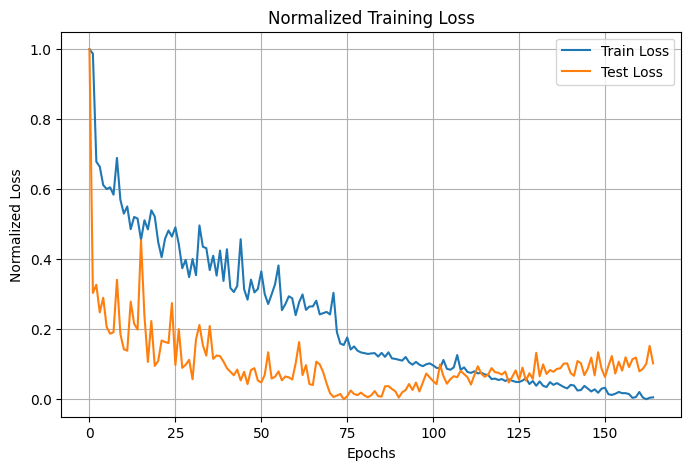

Fold 5
Epoch 0 | Loss train: 0.681007 | Loss test: 0.643617 | lr = 0.01
Epoch 10 | Loss train: 0.339898 | Loss test: 0.383965 | lr = 0.01
Epoch 20 | Loss train: 0.330702 | Loss test: 0.395298 | lr = 0.01
Epoch 30 | Loss train: 0.249338 | Loss test: 0.470304 | lr = 0.01
Epoch 40 | Loss train: 0.272911 | Loss test: 0.349966 | lr = 0.01
Epoch 50 | Loss train: 0.160337 | Loss test: 0.280558 | lr = 0.001
Epoch 60 | Loss train: 0.141417 | Loss test: 0.291638 | lr = 0.001
Epoch 70 | Loss train: 0.135635 | Loss test: 0.262907 | lr = 0.001
Epoch 80 | Loss train: 0.129988 | Loss test: 0.275729 | lr = 0.001
Epoch 90 | Loss train: 0.122495 | Loss test: 0.260401 | lr = 0.001
Epoch 100 | Loss train: 0.118553 | Loss test: 0.270878 | lr = 0.001
Epoch 110 | Loss train: 0.110928 | Loss test: 0.267647 | lr = 0.001
Epoch 120 | Loss train: 0.092072 | Loss test: 0.254052 | lr = 0.001
Epoch 130 | Loss train: 0.095389 | Loss test: 0.273901 | lr = 0.001
Epoch 140 | Loss train: 0.084054 | Loss test: 0.266805 | 

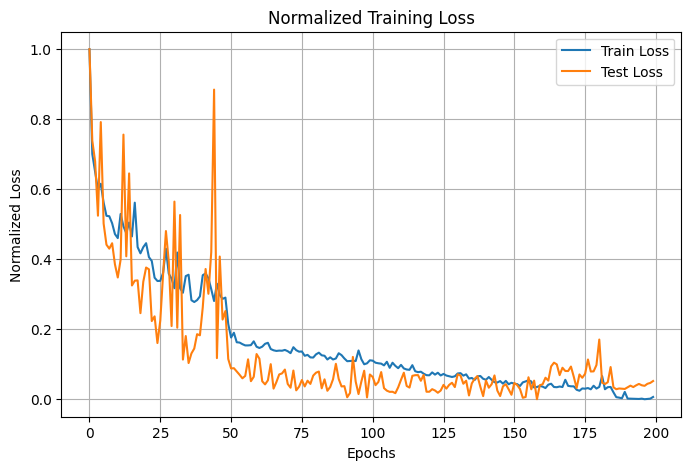

Cross-Validation finished with mean error across 5 subsets = 0.2446322869686853, evaluating final model...
Epoch 0 | Loss train: 0.748805 | lr = 0.01
Epoch 10 | Loss train: 0.386016 | lr = 0.01
Epoch 20 | Loss train: 0.257127 | lr = 0.01
Epoch 30 | Loss train: 0.248892 | lr = 0.01
Epoch 40 | Loss train: 0.248500 | lr = 0.01
Epoch 50 | Loss train: 0.214039 | lr = 0.01
Epoch 60 | Loss train: 0.199769 | lr = 0.01
Epoch 70 | Loss train: 0.213662 | lr = 0.01
Epoch 80 | Loss train: 0.128568 | lr = 0.001
Epoch 90 | Loss train: 0.112567 | lr = 0.001
Epoch 100 | Loss train: 0.099885 | lr = 0.001
Epoch 110 | Loss train: 0.096787 | lr = 0.001
Epoch 120 | Loss train: 0.089996 | lr = 0.001
Epoch 130 | Loss train: 0.086409 | lr = 0.001
Epoch 140 | Loss train: 0.076745 | lr = 0.001
Epoch 150 | Loss train: 0.073334 | lr = 0.001
Epoch 160 | Loss train: 0.070052 | lr = 0.001
Epoch 170 | Loss train: 0.063508 | lr = 0.001
Epoch 180 | Loss train: 0.062917 | lr = 0.001
Epoch 190 | Loss train: 0.063577 | lr 

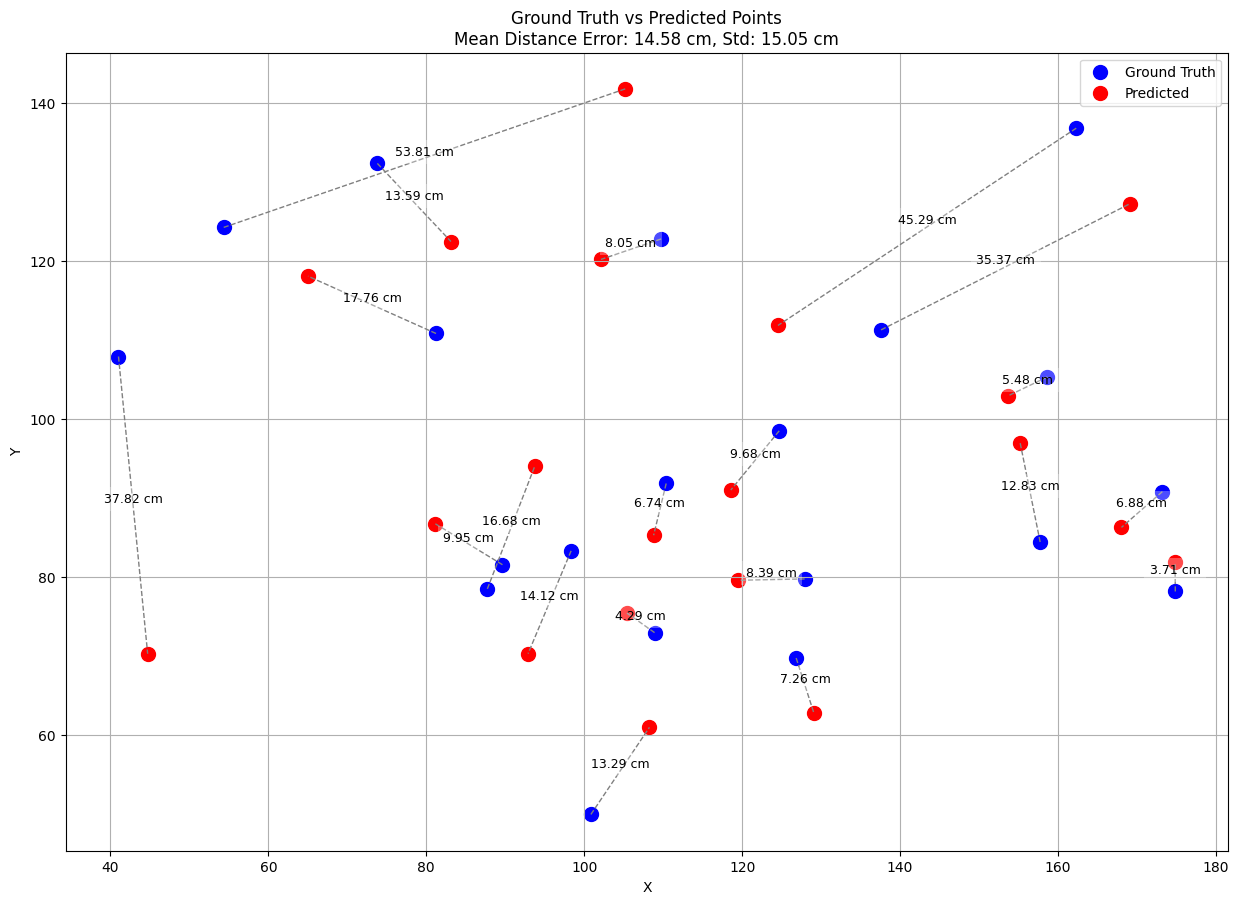

In [27]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu_4 = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= LeakyReLUModel4, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

#### -1 Layer

In [28]:
class LeakyReLUModel2(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 1.676619 | Loss test: 0.581956 | lr = 0.01
Epoch 10 | Loss train: 0.394542 | Loss test: 0.484587 | lr = 0.01
Epoch 20 | Loss train: 0.313778 | Loss test: 0.355582 | lr = 0.01
Epoch 30 | Loss train: 0.382495 | Loss test: 0.401448 | lr = 0.01
Epoch 40 | Loss train: 0.278937 | Loss test: 0.312906 | lr = 0.01
Epoch 50 | Loss train: 0.253587 | Loss test: 0.421410 | lr = 0.01
Epoch 60 | Loss train: 0.295378 | Loss test: 0.329082 | lr = 0.001
Epoch 70 | Loss train: 0.174383 | Loss test: 0.288009 | lr = 0.001
Epoch 80 | Loss train: 0.156633 | Loss test: 0.288247 | lr = 0.001
Epoch 90 | Loss train: 0.151232 | Loss test: 0.276845 | lr = 0.001
Epoch 100 | Loss train: 0.138997 | Loss test: 0.287145 | lr = 0.001
Epoch 110 | Loss train: 0.147804 | Loss test: 0.285552 | lr = 0.001
Epoch 120 | Loss train: 0.131335 | Loss test: 0.309046 | lr = 0.001
Epoch 130 | Loss train: 0.130600 | Loss test: 0.323228 | lr = 0.001
Epoch 140 | Loss train: 0.111049 | Loss test: 0.312181 | l

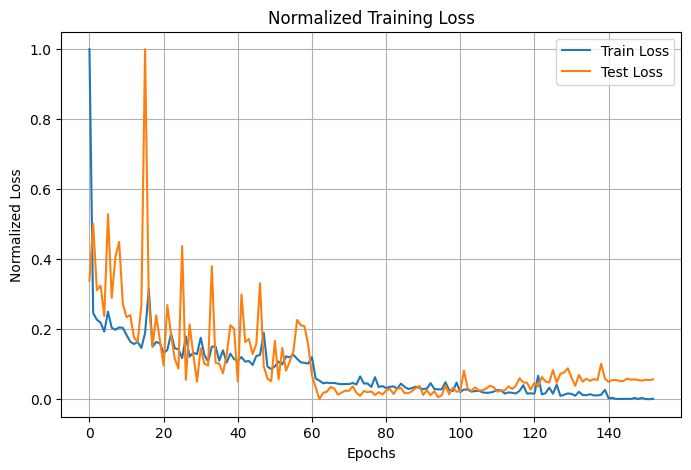

Fold 2
Epoch 0 | Loss train: 1.619665 | Loss test: 0.625902 | lr = 0.01
Epoch 10 | Loss train: 0.351596 | Loss test: 0.387272 | lr = 0.01
Epoch 20 | Loss train: 0.359547 | Loss test: 0.517888 | lr = 0.01
Epoch 30 | Loss train: 0.283541 | Loss test: 0.536512 | lr = 0.01
Epoch 40 | Loss train: 0.198658 | Loss test: 0.309880 | lr = 0.001
Epoch 50 | Loss train: 0.208102 | Loss test: 0.318885 | lr = 0.001
Epoch 60 | Loss train: 0.177320 | Loss test: 0.269980 | lr = 0.001
Epoch 70 | Loss train: 0.174655 | Loss test: 0.293505 | lr = 0.001
Epoch 80 | Loss train: 0.180960 | Loss test: 0.271272 | lr = 0.001
Epoch 90 | Loss train: 0.148158 | Loss test: 0.264645 | lr = 0.0001
Epoch 100 | Loss train: 0.147370 | Loss test: 0.263333 | lr = 0.0001
Epoch 110 | Loss train: 0.147334 | Loss test: 0.261738 | lr = 0.0001
Epoch 120 | Loss train: 0.166576 | Loss test: 0.257844 | lr = 0.0001
Epoch 130 | Loss train: 0.148496 | Loss test: 0.258292 | lr = 0.0001
Epoch 140 | Loss train: 0.143563 | Loss test: 0.257

Fold 3
Epoch 0 | Loss train: 5.446779 | Loss test: 0.816887 | lr = 0.01
Epoch 10 | Loss train: 0.387367 | Loss test: 0.411111 | lr = 0.01
Epoch 20 | Loss train: 0.330866 | Loss test: 0.444993 | lr = 0.01
Epoch 30 | Loss train: 0.323408 | Loss test: 0.386523 | lr = 0.01
Epoch 40 | Loss train: 0.298743 | Loss test: 0.421566 | lr = 0.01
Epoch 50 | Loss train: 0.273513 | Loss test: 0.443990 | lr = 0.01
Epoch 60 | Loss train: 0.192406 | Loss test: 0.304055 | lr = 0.001
Epoch 70 | Loss train: 0.164747 | Loss test: 0.306800 | lr = 0.001
Epoch 80 | Loss train: 0.161449 | Loss test: 0.298824 | lr = 0.001
Epoch 90 | Loss train: 0.161611 | Loss test: 0.297382 | lr = 0.001
Epoch 100 | Loss train: 0.147311 | Loss test: 0.301369 | lr = 0.001
Epoch 110 | Loss train: 0.143950 | Loss test: 0.311633 | lr = 0.001
Epoch 120 | Loss train: 0.142978 | Loss test: 0.317569 | lr = 0.001
Epoch 130 | Loss train: 0.129920 | Loss test: 0.326067 | lr = 0.001
Epoch 140 | Loss train: 0.123106 | Loss test: 0.332463 | l

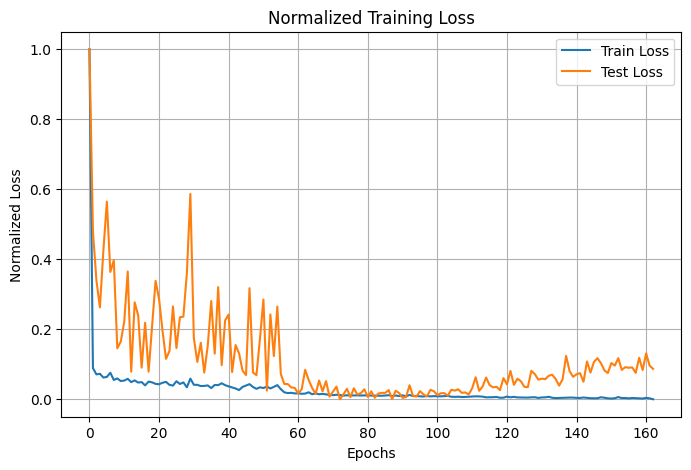

Fold 4
Epoch 0 | Loss train: 3.143862 | Loss test: 0.626041 | lr = 0.01
Epoch 10 | Loss train: 0.415564 | Loss test: 0.596960 | lr = 0.01
Epoch 20 | Loss train: 0.342285 | Loss test: 0.442256 | lr = 0.01
Epoch 30 | Loss train: 0.318457 | Loss test: 0.343781 | lr = 0.01
Epoch 40 | Loss train: 0.366353 | Loss test: 0.388171 | lr = 0.01
Epoch 50 | Loss train: 0.233000 | Loss test: 0.280000 | lr = 0.001
Epoch 60 | Loss train: 0.196744 | Loss test: 0.253675 | lr = 0.001
Epoch 70 | Loss train: 0.183709 | Loss test: 0.255403 | lr = 0.001
Epoch 80 | Loss train: 0.178697 | Loss test: 0.264397 | lr = 0.001
Epoch 90 | Loss train: 0.179049 | Loss test: 0.251883 | lr = 0.001
Epoch 100 | Loss train: 0.177322 | Loss test: 0.256458 | lr = 0.001
Epoch 110 | Loss train: 0.160820 | Loss test: 0.259883 | lr = 0.001
Epoch 120 | Loss train: 0.157424 | Loss test: 0.264555 | lr = 0.001
Epoch 130 | Loss train: 0.149003 | Loss test: 0.257508 | lr = 0.001
Epoch 140 | Loss train: 0.153389 | Loss test: 0.267043 | 

Fold 5
Epoch 0 | Loss train: 1.194980 | Loss test: 1.100716 | lr = 0.01
Epoch 10 | Loss train: 0.395959 | Loss test: 0.404277 | lr = 0.01
Epoch 20 | Loss train: 0.316369 | Loss test: 0.491491 | lr = 0.01
Epoch 30 | Loss train: 0.261034 | Loss test: 0.445309 | lr = 0.01
Epoch 40 | Loss train: 0.280406 | Loss test: 0.302962 | lr = 0.01
Epoch 50 | Loss train: 0.300580 | Loss test: 0.370604 | lr = 0.01
Epoch 60 | Loss train: 0.269557 | Loss test: 0.358708 | lr = 0.01
Epoch 70 | Loss train: 0.245964 | Loss test: 0.329135 | lr = 0.01
Epoch 80 | Loss train: 0.231263 | Loss test: 0.360502 | lr = 0.01
Epoch 90 | Loss train: 0.225117 | Loss test: 0.328438 | lr = 0.001
Epoch 100 | Loss train: 0.155431 | Loss test: 0.268534 | lr = 0.001
Epoch 110 | Loss train: 0.151752 | Loss test: 0.274009 | lr = 0.001
Epoch 120 | Loss train: 0.138681 | Loss test: 0.274802 | lr = 0.001
Epoch 130 | Loss train: 0.140543 | Loss test: 0.286534 | lr = 0.001
Epoch 140 | Loss train: 0.130832 | Loss test: 0.276555 | lr =

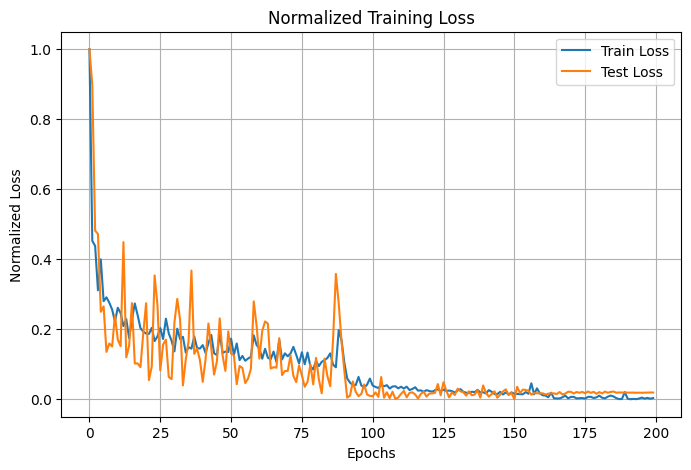

Cross-Validation finished with mean error across 5 subsets = 0.2639414332807064, evaluating final model...
Epoch 0 | Loss train: 1.172951 | lr = 0.01
Epoch 10 | Loss train: 0.382524 | lr = 0.01
Epoch 20 | Loss train: 0.326939 | lr = 0.01
Epoch 30 | Loss train: 0.292600 | lr = 0.01
Epoch 40 | Loss train: 0.309857 | lr = 0.01
Epoch 50 | Loss train: 0.270301 | lr = 0.01
Epoch 60 | Loss train: 0.245566 | lr = 0.001
Epoch 70 | Loss train: 0.172354 | lr = 0.001
Epoch 80 | Loss train: 0.168404 | lr = 0.001
Epoch 90 | Loss train: 0.163661 | lr = 0.001
Epoch 100 | Loss train: 0.157967 | lr = 0.001
Epoch 110 | Loss train: 0.175859 | lr = 0.001
Epoch 120 | Loss train: 0.138905 | lr = 0.001
Epoch 130 | Loss train: 0.146873 | lr = 0.001
Epoch 140 | Loss train: 0.132120 | lr = 0.001
Epoch 150 | Loss train: 0.125664 | lr = 0.001
Epoch 160 | Loss train: 0.126785 | lr = 0.001
Epoch 170 | Loss train: 0.127076 | lr = 0.001
Epoch 180 | Loss train: 0.126630 | lr = 0.001
Epoch 190 | Loss train: 0.138581 | l

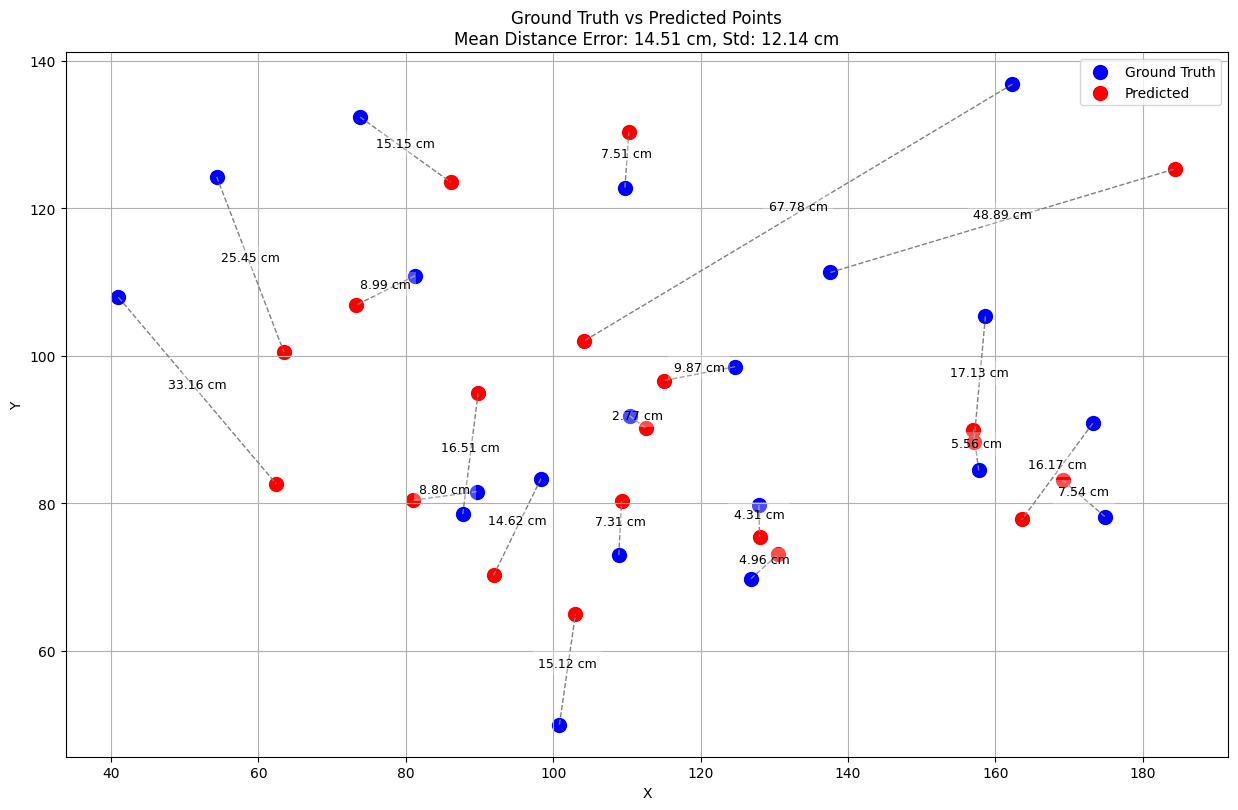

In [29]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu_2 = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= LeakyReLUModel2, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

#### -1 Layer rmsprop

In [30]:
class LeakyReLUModel2_RMS(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2_RMS, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 182.013952 | Loss test: 3.110361 | lr = 0.01
Epoch 10 | Loss train: 1.328119 | Loss test: 0.670423 | lr = 0.01
Epoch 20 | Loss train: 0.682177 | Loss test: 0.789824 | lr = 0.01
Epoch 30 | Loss train: 0.354802 | Loss test: 0.437527 | lr = 0.001
Epoch 40 | Loss train: 0.246962 | Loss test: 0.354654 | lr = 0.001
Epoch 50 | Loss train: 0.229823 | Loss test: 0.342938 | lr = 0.001
Epoch 60 | Loss train: 0.210930 | Loss test: 0.398386 | lr = 0.001
Epoch 70 | Loss train: 0.199867 | Loss test: 0.354662 | lr = 0.001
Epoch 80 | Loss train: 0.186770 | Loss test: 0.317572 | lr = 0.001
Epoch 90 | Loss train: 0.177333 | Loss test: 0.315683 | lr = 0.001
Epoch 100 | Loss train: 0.164898 | Loss test: 0.302400 | lr = 0.001
Epoch 110 | Loss train: 0.147336 | Loss test: 0.281832 | lr = 0.0001
Epoch 120 | Loss train: 0.135305 | Loss test: 0.286333 | lr = 0.0001
Epoch 130 | Loss train: 0.132394 | Loss test: 0.288821 | lr = 0.0001
Epoch 140 | Loss train: 0.130220 | Loss test: 0.28

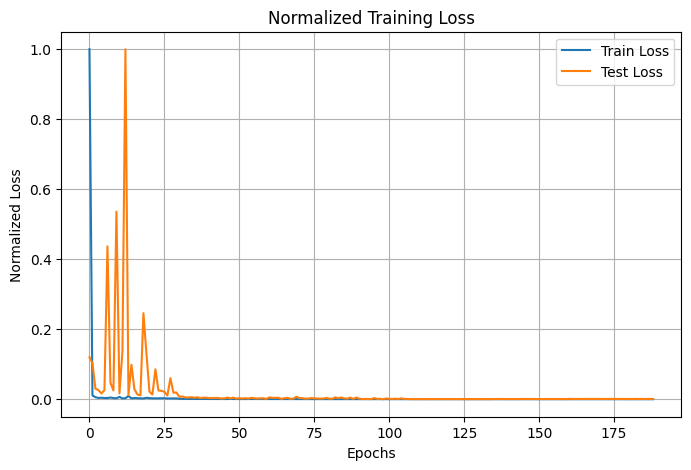

Fold 2
Epoch 0 | Loss train: 568.646947 | Loss test: 2.219694 | lr = 0.01
Epoch 10 | Loss train: 0.568758 | Loss test: 0.455934 | lr = 0.01
Epoch 20 | Loss train: 0.639615 | Loss test: 14.525151 | lr = 0.01
Epoch 30 | Loss train: 0.293611 | Loss test: 0.332332 | lr = 0.001
Epoch 40 | Loss train: 0.247925 | Loss test: 0.281845 | lr = 0.001
Epoch 50 | Loss train: 0.252858 | Loss test: 0.282104 | lr = 0.001
Epoch 60 | Loss train: 0.215593 | Loss test: 0.548245 | lr = 0.001
Epoch 70 | Loss train: 0.197009 | Loss test: 0.322994 | lr = 0.001
Epoch 80 | Loss train: 0.205375 | Loss test: 0.434109 | lr = 0.001
Epoch 90 | Loss train: 0.192399 | Loss test: 0.274230 | lr = 0.001
Epoch 100 | Loss train: 0.177873 | Loss test: 0.291986 | lr = 0.001
Epoch 110 | Loss train: 0.192969 | Loss test: 0.252924 | lr = 0.001
Epoch 120 | Loss train: 0.199699 | Loss test: 0.264079 | lr = 0.001
Epoch 130 | Loss train: 0.171219 | Loss test: 0.301257 | lr = 0.001
Epoch 140 | Loss train: 0.161033 | Loss test: 0.3069

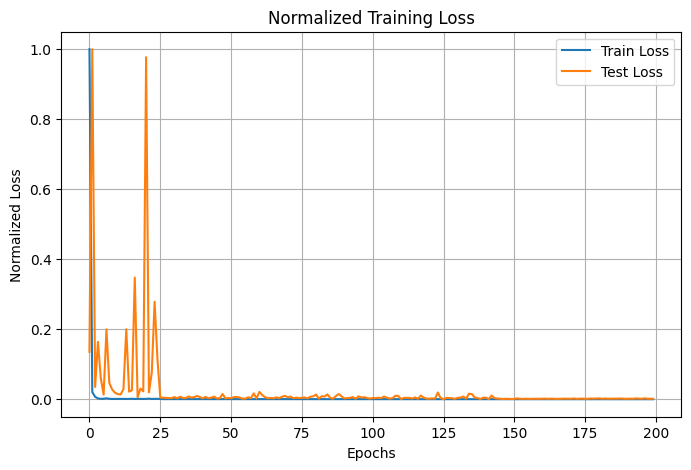

Fold 3
Epoch 0 | Loss train: 890.342944 | Loss test: 22.161534 | lr = 0.01
Epoch 10 | Loss train: 0.592381 | Loss test: 0.603365 | lr = 0.01
Epoch 20 | Loss train: 0.583816 | Loss test: 0.931624 | lr = 0.01
Epoch 30 | Loss train: 0.552748 | Loss test: 0.581670 | lr = 0.01
Epoch 40 | Loss train: 0.738692 | Loss test: 0.605143 | lr = 0.01
Epoch 50 | Loss train: 0.446015 | Loss test: 0.572815 | lr = 0.01
Epoch 60 | Loss train: 0.425970 | Loss test: 0.536701 | lr = 0.01
Epoch 70 | Loss train: 0.230418 | Loss test: 0.357118 | lr = 0.001
Epoch 80 | Loss train: 0.204380 | Loss test: 0.340600 | lr = 0.001
Epoch 90 | Loss train: 0.202614 | Loss test: 0.301559 | lr = 0.001
Epoch 100 | Loss train: 0.186088 | Loss test: 0.306660 | lr = 0.001
Epoch 110 | Loss train: 0.178935 | Loss test: 0.322802 | lr = 0.001
Epoch 120 | Loss train: 0.169486 | Loss test: 0.297751 | lr = 0.001
Epoch 130 | Loss train: 0.169984 | Loss test: 0.303368 | lr = 0.001
Epoch 140 | Loss train: 0.154300 | Loss test: 0.314676 |

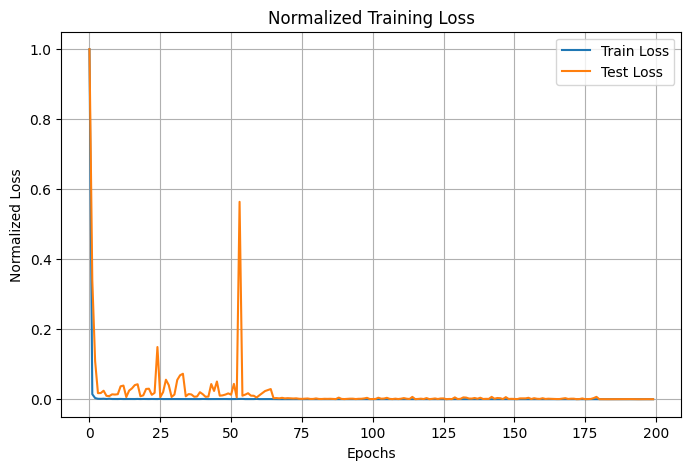

Fold 4
Epoch 0 | Loss train: 396.456304 | Loss test: 6.391212 | lr = 0.01
Epoch 10 | Loss train: 1.007202 | Loss test: 0.705624 | lr = 0.01
Epoch 20 | Loss train: 0.657384 | Loss test: 0.585487 | lr = 0.01
Epoch 30 | Loss train: 0.713934 | Loss test: 0.547741 | lr = 0.01
Epoch 40 | Loss train: 0.399033 | Loss test: 0.365538 | lr = 0.001
Epoch 50 | Loss train: 0.266740 | Loss test: 0.272711 | lr = 0.001
Epoch 60 | Loss train: 0.231043 | Loss test: 0.307699 | lr = 0.001
Epoch 70 | Loss train: 0.221916 | Loss test: 0.247670 | lr = 0.001
Epoch 80 | Loss train: 0.201971 | Loss test: 0.265804 | lr = 0.001
Epoch 90 | Loss train: 0.196396 | Loss test: 0.251618 | lr = 0.001
Epoch 100 | Loss train: 0.178314 | Loss test: 0.265433 | lr = 0.001
Epoch 110 | Loss train: 0.168274 | Loss test: 0.296209 | lr = 0.001
Epoch 120 | Loss train: 0.175191 | Loss test: 0.262999 | lr = 0.001
Epoch 130 | Loss train: 0.172863 | Loss test: 0.310903 | lr = 0.001
Epoch 140 | Loss train: 0.143784 | Loss test: 0.238171

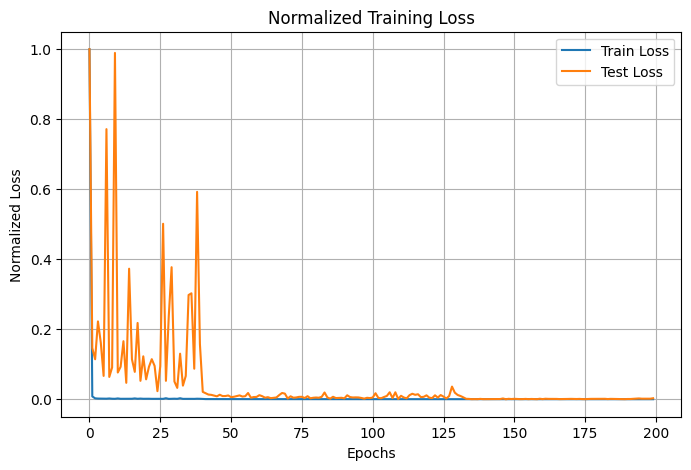

Fold 5
Epoch 0 | Loss train: 401.393494 | Loss test: 5.655953 | lr = 0.01
Epoch 10 | Loss train: 0.599590 | Loss test: 0.722820 | lr = 0.01
Epoch 20 | Loss train: 0.527737 | Loss test: 0.698929 | lr = 0.01
Epoch 30 | Loss train: 0.504750 | Loss test: 0.780101 | lr = 0.001
Epoch 40 | Loss train: 0.262109 | Loss test: 0.338024 | lr = 0.001
Epoch 50 | Loss train: 0.234643 | Loss test: 0.330799 | lr = 0.001
Epoch 60 | Loss train: 0.220458 | Loss test: 0.292224 | lr = 0.001
Epoch 70 | Loss train: 0.193050 | Loss test: 0.285579 | lr = 0.001
Epoch 80 | Loss train: 0.188591 | Loss test: 0.314395 | lr = 0.001
Epoch 90 | Loss train: 0.190457 | Loss test: 0.281054 | lr = 0.001
Epoch 100 | Loss train: 0.171095 | Loss test: 0.325400 | lr = 0.001
Epoch 110 | Loss train: 0.164313 | Loss test: 0.310222 | lr = 0.001
Epoch 120 | Loss train: 0.155003 | Loss test: 0.270027 | lr = 0.001
Epoch 130 | Loss train: 0.156904 | Loss test: 0.276685 | lr = 0.001
Epoch 140 | Loss train: 0.121863 | Loss test: 0.26123

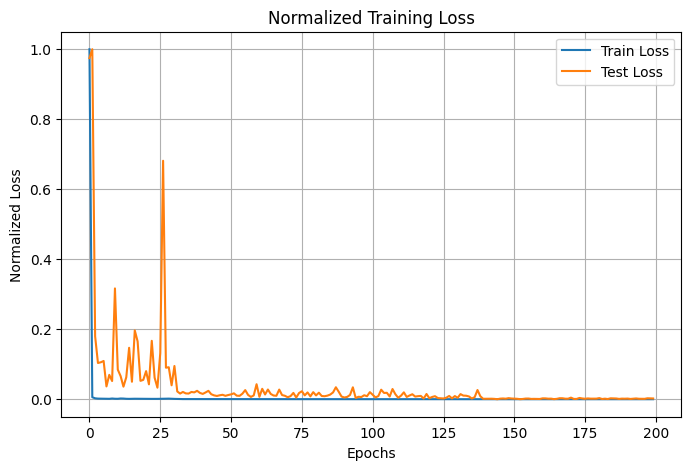

Cross-Validation finished with mean error across 5 subsets = 0.25946669028628444, evaluating final model...
Epoch 0 | Loss train: 416.295033 | lr = 0.01
Epoch 10 | Loss train: 0.673310 | lr = 0.01
Epoch 20 | Loss train: 0.545327 | lr = 0.01
Epoch 30 | Loss train: 0.691419 | lr = 0.01
Epoch 40 | Loss train: 0.826676 | lr = 0.01
Epoch 50 | Loss train: 0.532822 | lr = 0.01
Epoch 60 | Loss train: 0.230655 | lr = 0.001
Epoch 70 | Loss train: 0.218064 | lr = 0.001
Epoch 80 | Loss train: 0.202382 | lr = 0.001
Epoch 90 | Loss train: 0.192208 | lr = 0.001
Epoch 100 | Loss train: 0.177056 | lr = 0.001
Epoch 110 | Loss train: 0.213783 | lr = 0.001
Epoch 120 | Loss train: 0.166578 | lr = 0.001
Epoch 130 | Loss train: 0.162542 | lr = 0.001
Epoch 140 | Loss train: 0.154087 | lr = 0.001
Epoch 150 | Loss train: 0.154364 | lr = 0.001
Epoch 160 | Loss train: 0.157619 | lr = 0.001
Epoch 170 | Loss train: 0.155261 | lr = 0.001
Epoch 180 | Loss train: 0.133305 | lr = 0.0001
Epoch 190 | Loss train: 0.133370

In [31]:
loss_fn = nn.MSELoss()
optim = torch.optim.RMSprop
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu_2_rms = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= LeakyReLUModel2_RMS, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

### Αρχιτεκτονική 4

#### Dropout LeakyReLU

Θα προσθέσουμε ένα άλλο επίπεδο που συνίσταται σε μοντέλα με μικρά datasets, το ```Dropout```. Αυτό, με πιθανότητα p "νεκρώνει" έναν νευρώνα, βοηθώντας έτσι το μοντέλο να κατανοήσει γενικότερα συμπεράσματα για τα δεδομένα που του δίνουμε.

In [32]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 256):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units/2)),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= int(hidden_units/2), out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 2.036023 | Loss test: 0.979637 | lr = 0.01
Epoch 10 | Loss train: 0.476140 | Loss test: 0.555890 | lr = 0.01
Epoch 20 | Loss train: 0.480737 | Loss test: 0.521544 | lr = 0.001
Epoch 30 | Loss train: 0.403753 | Loss test: 0.469279 | lr = 0.001
Epoch 40 | Loss train: 0.321663 | Loss test: 0.448530 | lr = 0.001
Epoch 50 | Loss train: 0.286326 | Loss test: 0.399252 | lr = 0.001
Epoch 60 | Loss train: 0.288392 | Loss test: 0.358495 | lr = 0.001
Epoch 70 | Loss train: 0.267133 | Loss test: 0.334573 | lr = 0.001
Epoch 80 | Loss train: 0.246546 | Loss test: 0.331681 | lr = 0.001
Epoch 90 | Loss train: 0.213666 | Loss test: 0.303202 | lr = 0.001
Epoch 100 | Loss train: 0.224464 | Loss test: 0.288907 | lr = 0.001
Epoch 110 | Loss train: 0.194862 | Loss test: 0.287959 | lr = 0.0001
Epoch 120 | Loss train: 0.194815 | Loss test: 0.295132 | lr = 0.0001
Epoch 130 | Loss train: 0.188306 | Loss test: 0.287509 | lr = 1e-05
Epoch 140 | Loss train: 0.185389 | Loss test: 0.2867

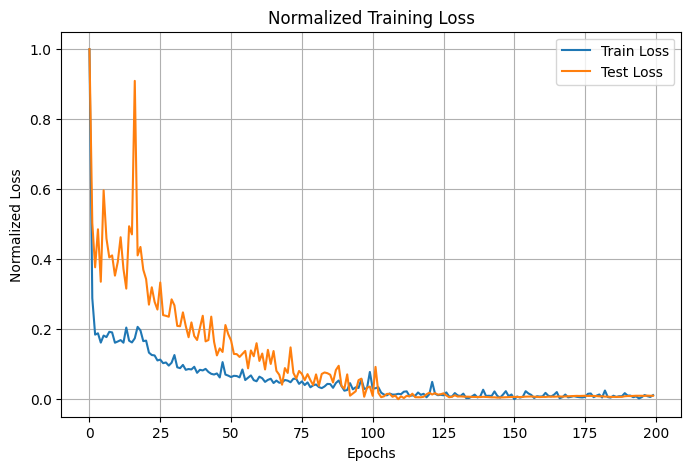

Fold 2
Epoch 0 | Loss train: 1.082124 | Loss test: 0.441364 | lr = 0.01
Epoch 10 | Loss train: 0.496521 | Loss test: 0.463532 | lr = 0.01
Epoch 20 | Loss train: 0.557409 | Loss test: 0.439377 | lr = 0.01
Epoch 30 | Loss train: 0.386535 | Loss test: 0.293549 | lr = 0.001
Epoch 40 | Loss train: 0.341773 | Loss test: 0.280581 | lr = 0.001
Epoch 50 | Loss train: 0.323174 | Loss test: 0.256432 | lr = 0.001
Epoch 60 | Loss train: 0.276433 | Loss test: 0.296409 | lr = 0.001
Epoch 70 | Loss train: 0.293288 | Loss test: 0.300452 | lr = 0.001
Epoch 80 | Loss train: 0.257844 | Loss test: 0.238758 | lr = 0.0001
Epoch 90 | Loss train: 0.242831 | Loss test: 0.244146 | lr = 0.0001
Epoch 100 | Loss train: 0.232303 | Loss test: 0.245408 | lr = 1e-05
Epoch 110 | Loss train: 0.245003 | Loss test: 0.243532 | lr = 1e-05
Epoch 120 | Loss train: 0.262106 | Loss test: 0.242718 | lr = 1e-05
Epoch 130 | Loss train: 0.223108 | Loss test: 0.241918 | lr = 1e-05
Epoch 140 | Loss train: 0.226568 | Loss test: 0.24331

Fold 3
Epoch 0 | Loss train: 1.904597 | Loss test: 0.714031 | lr = 0.01
Epoch 10 | Loss train: 0.504400 | Loss test: 0.528031 | lr = 0.01
Epoch 20 | Loss train: 0.454913 | Loss test: 0.415595 | lr = 0.01
Epoch 30 | Loss train: 0.390205 | Loss test: 0.374821 | lr = 0.001
Epoch 40 | Loss train: 0.351931 | Loss test: 0.328514 | lr = 0.001
Epoch 50 | Loss train: 0.319153 | Loss test: 0.310120 | lr = 0.001
Epoch 60 | Loss train: 0.296811 | Loss test: 0.290050 | lr = 0.001
Epoch 70 | Loss train: 0.273666 | Loss test: 0.292963 | lr = 0.001
Epoch 80 | Loss train: 0.268316 | Loss test: 0.305763 | lr = 0.001
Epoch 90 | Loss train: 0.282701 | Loss test: 0.297853 | lr = 0.001
Epoch 100 | Loss train: 0.231296 | Loss test: 0.286434 | lr = 0.001
Epoch 110 | Loss train: 0.232872 | Loss test: 0.268806 | lr = 0.001
Epoch 120 | Loss train: 0.212187 | Loss test: 0.247672 | lr = 0.0001
Epoch 130 | Loss train: 0.191377 | Loss test: 0.247279 | lr = 0.0001
Epoch 140 | Loss train: 0.198522 | Loss test: 0.24915

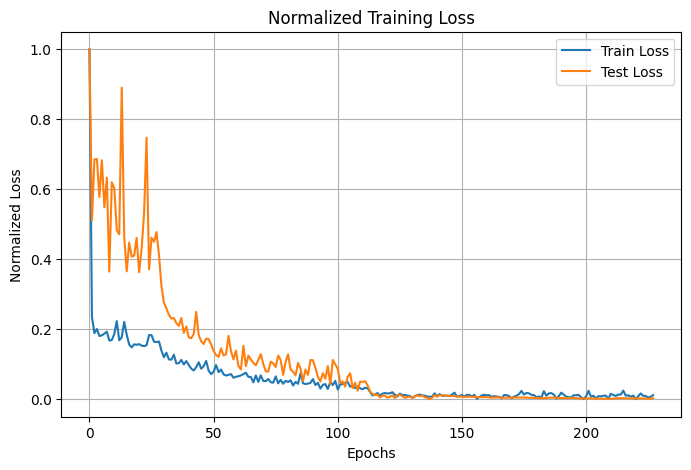

Fold 4
Epoch 0 | Loss train: 1.198546 | Loss test: 1.451586 | lr = 0.01
Epoch 10 | Loss train: 0.494079 | Loss test: 0.508437 | lr = 0.01
Epoch 20 | Loss train: 0.470964 | Loss test: 0.546160 | lr = 0.01
Epoch 30 | Loss train: 0.525370 | Loss test: 0.518833 | lr = 0.001
Epoch 40 | Loss train: 0.390298 | Loss test: 0.369685 | lr = 0.001
Epoch 50 | Loss train: 0.358194 | Loss test: 0.327469 | lr = 0.001
Epoch 60 | Loss train: 0.308510 | Loss test: 0.290046 | lr = 0.001
Epoch 70 | Loss train: 0.295700 | Loss test: 0.297107 | lr = 0.001
Epoch 80 | Loss train: 0.283695 | Loss test: 0.332273 | lr = 0.001
Epoch 90 | Loss train: 0.288464 | Loss test: 0.289776 | lr = 0.001
Epoch 100 | Loss train: 0.279200 | Loss test: 0.241922 | lr = 0.001
Epoch 110 | Loss train: 0.258367 | Loss test: 0.280993 | lr = 0.001
Epoch 120 | Loss train: 0.241261 | Loss test: 0.252716 | lr = 0.001
Epoch 130 | Loss train: 0.223539 | Loss test: 0.234062 | lr = 0.0001
Epoch 140 | Loss train: 0.233469 | Loss test: 0.224567

Fold 5
Epoch 0 | Loss train: 1.234217 | Loss test: 0.636567 | lr = 0.01
Epoch 10 | Loss train: 0.451521 | Loss test: 0.409185 | lr = 0.01
Epoch 20 | Loss train: 0.372700 | Loss test: 0.369315 | lr = 0.001
Epoch 30 | Loss train: 0.344365 | Loss test: 0.355943 | lr = 0.001
Epoch 40 | Loss train: 0.308581 | Loss test: 0.326103 | lr = 0.001
Epoch 50 | Loss train: 0.297635 | Loss test: 0.324066 | lr = 0.001
Epoch 60 | Loss train: 0.286623 | Loss test: 0.327789 | lr = 0.001
Epoch 70 | Loss train: 0.278516 | Loss test: 0.289953 | lr = 0.001
Epoch 80 | Loss train: 0.273574 | Loss test: 0.280160 | lr = 0.001
Epoch 90 | Loss train: 0.272210 | Loss test: 0.294543 | lr = 0.001
Epoch 100 | Loss train: 0.246595 | Loss test: 0.265701 | lr = 0.001
Epoch 110 | Loss train: 0.240864 | Loss test: 0.263097 | lr = 0.001
Epoch 120 | Loss train: 0.208347 | Loss test: 0.259668 | lr = 0.001
Epoch 130 | Loss train: 0.210756 | Loss test: 0.274000 | lr = 0.001
Epoch 140 | Loss train: 0.180077 | Loss test: 0.231552

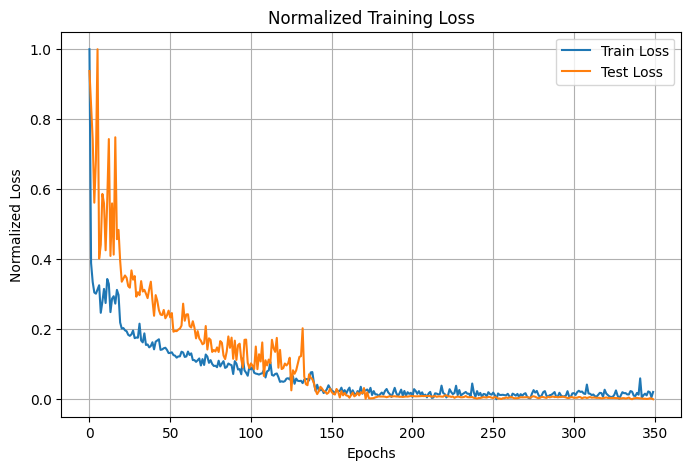

Cross-Validation finished with mean error across 5 subsets = 0.23821875186903135, evaluating final model...
Epoch 0 | Loss train: 0.956568 | lr = 0.01
Epoch 10 | Loss train: 0.487958 | lr = 0.01
Epoch 20 | Loss train: 0.456125 | lr = 0.01
Epoch 30 | Loss train: 0.356906 | lr = 0.001
Epoch 40 | Loss train: 0.335234 | lr = 0.001
Epoch 50 | Loss train: 0.324557 | lr = 0.001
Epoch 60 | Loss train: 0.283794 | lr = 0.001
Epoch 70 | Loss train: 0.270393 | lr = 0.001
Epoch 80 | Loss train: 0.272002 | lr = 0.001
Epoch 90 | Loss train: 0.235484 | lr = 0.001
Epoch 100 | Loss train: 0.229453 | lr = 0.001
Epoch 110 | Loss train: 0.328844 | lr = 0.001
Epoch 120 | Loss train: 0.219252 | lr = 0.001
Epoch 130 | Loss train: 0.222382 | lr = 0.0001
Epoch 140 | Loss train: 0.199604 | lr = 0.0001
Epoch 150 | Loss train: 0.189209 | lr = 0.0001
Epoch 160 | Loss train: 0.180973 | lr = 0.0001
Epoch 170 | Loss train: 0.181665 | lr = 0.0001
Epoch 180 | Loss train: 0.193230 | lr = 1e-05
Epoch 190 | Loss train: 0.1

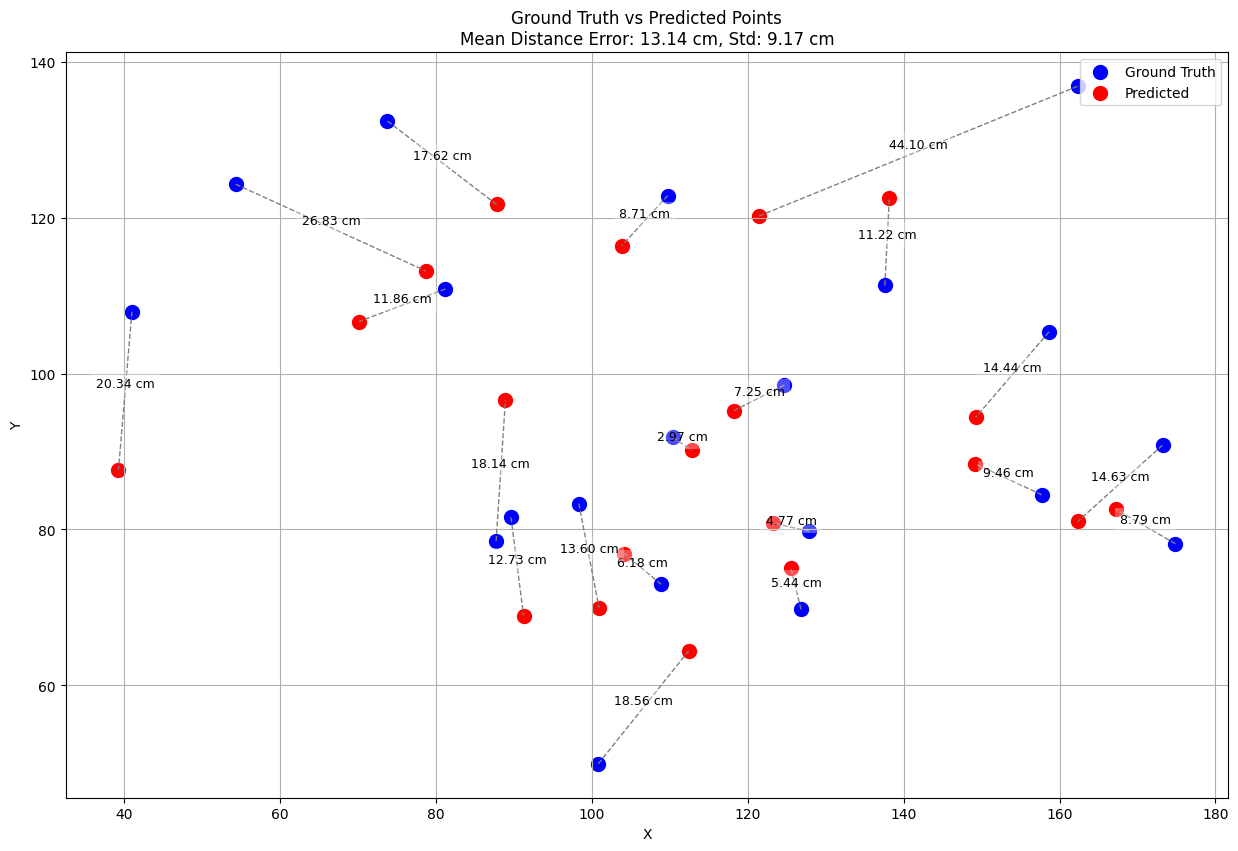

In [33]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2, 'weight_decay': 1e-4}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 128}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 350

dropout_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= LeakyReLUModelDropout, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [34]:
dropout_model

{'model_name': 'LeakyReLUModelDropout',
 'mean_distance_error_cm': 13.139785766601562,
 'std': 9.16575813293457}

#### Dropout ReLU

In [35]:
class ReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 256):
        super(ReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units)),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features= int(hidden_units), out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 0.807758 | Loss test: 0.499492 | lr = 0.01
Epoch 10 | Loss train: 0.173899 | Loss test: 0.213684 | lr = 0.01
Epoch 20 | Loss train: 0.150024 | Loss test: 0.232792 | lr = 0.01
Epoch 30 | Loss train: 0.151073 | Loss test: 0.185279 | lr = 0.01
Epoch 40 | Loss train: 0.134329 | Loss test: 0.211808 | lr = 0.01
Epoch 50 | Loss train: 0.124227 | Loss test: 0.136074 | lr = 0.01
Epoch 60 | Loss train: 0.135568 | Loss test: 0.147911 | lr = 0.01
Epoch 70 | Loss train: 0.120871 | Loss test: 0.170483 | lr = 0.001
Epoch 80 | Loss train: 0.090239 | Loss test: 0.119301 | lr = 0.001
Epoch 90 | Loss train: 0.083038 | Loss test: 0.116054 | lr = 0.001
Epoch 100 | Loss train: 0.081226 | Loss test: 0.118997 | lr = 0.001
Epoch 110 | Loss train: 0.085130 | Loss test: 0.115945 | lr = 0.001
Epoch 120 | Loss train: 0.079645 | Loss test: 0.115997 | lr = 0.0001
Epoch 130 | Loss train: 0.084224 | Loss test: 0.116058 | lr = 1e-05
Epoch 140 | Loss train: 0.078006 | Loss test: 0.116123 | l

Fold 2
Epoch 0 | Loss train: 0.652758 | Loss test: 0.214055 | lr = 0.01
Epoch 10 | Loss train: 0.194090 | Loss test: 0.150078 | lr = 0.01
Epoch 20 | Loss train: 0.159262 | Loss test: 0.170698 | lr = 0.01
Epoch 30 | Loss train: 0.136008 | Loss test: 0.189366 | lr = 0.01
Epoch 40 | Loss train: 0.133120 | Loss test: 0.120354 | lr = 0.01
Epoch 50 | Loss train: 0.116311 | Loss test: 0.121038 | lr = 0.01
Epoch 60 | Loss train: 0.096282 | Loss test: 0.117958 | lr = 0.001
Epoch 70 | Loss train: 0.095731 | Loss test: 0.113001 | lr = 0.001
Epoch 80 | Loss train: 0.100253 | Loss test: 0.113403 | lr = 0.0001
Epoch 90 | Loss train: 0.098916 | Loss test: 0.112995 | lr = 1e-05
Epoch 100 | Loss train: 0.089242 | Loss test: 0.113509 | lr = 1e-05
Epoch 110 | Loss train: 0.092370 | Loss test: 0.113345 | lr = 1e-05
Epoch 120 | Loss train: 0.100747 | Loss test: 0.113397 | lr = 1e-05
Epoch 130 | Loss train: 0.094615 | Loss test: 0.113377 | lr = 1e-05
Epoch 140 | Loss train: 0.089996 | Loss test: 0.113589 | 

Fold 3
Epoch 0 | Loss train: 0.844208 | Loss test: 0.308789 | lr = 0.01
Epoch 10 | Loss train: 0.183151 | Loss test: 0.218127 | lr = 0.01
Epoch 20 | Loss train: 0.174169 | Loss test: 0.160557 | lr = 0.01
Epoch 30 | Loss train: 0.154975 | Loss test: 0.149491 | lr = 0.01
Epoch 40 | Loss train: 0.145806 | Loss test: 0.161333 | lr = 0.01
Epoch 50 | Loss train: 0.138514 | Loss test: 0.146717 | lr = 0.001
Epoch 60 | Loss train: 0.107423 | Loss test: 0.126899 | lr = 0.001
Epoch 70 | Loss train: 0.095237 | Loss test: 0.123959 | lr = 0.001
Epoch 80 | Loss train: 0.094680 | Loss test: 0.122988 | lr = 0.001
Epoch 90 | Loss train: 0.095166 | Loss test: 0.123498 | lr = 0.0001
Epoch 100 | Loss train: 0.085563 | Loss test: 0.122571 | lr = 0.0001
Epoch 110 | Loss train: 0.092280 | Loss test: 0.122475 | lr = 1e-05
Epoch 120 | Loss train: 0.086852 | Loss test: 0.122433 | lr = 1e-05
Epoch 130 | Loss train: 0.085430 | Loss test: 0.122477 | lr = 1e-05
Epoch 140 | Loss train: 0.084322 | Loss test: 0.122510 

Fold 4
Epoch 0 | Loss train: 0.913069 | Loss test: 0.304306 | lr = 0.01
Epoch 10 | Loss train: 0.179513 | Loss test: 0.169789 | lr = 0.01
Epoch 20 | Loss train: 0.142748 | Loss test: 0.146870 | lr = 0.01
Epoch 30 | Loss train: 0.150177 | Loss test: 0.180189 | lr = 0.01
Epoch 40 | Loss train: 0.129109 | Loss test: 0.136116 | lr = 0.001
Epoch 50 | Loss train: 0.116230 | Loss test: 0.137444 | lr = 0.001
Epoch 60 | Loss train: 0.106693 | Loss test: 0.133442 | lr = 0.001
Epoch 70 | Loss train: 0.104326 | Loss test: 0.139139 | lr = 0.001
Epoch 80 | Loss train: 0.095707 | Loss test: 0.133123 | lr = 0.001
Epoch 90 | Loss train: 0.105738 | Loss test: 0.130812 | lr = 0.001
Epoch 100 | Loss train: 0.097771 | Loss test: 0.131842 | lr = 0.0001
Epoch 110 | Loss train: 0.097093 | Loss test: 0.131483 | lr = 1e-05
Epoch 120 | Loss train: 0.095391 | Loss test: 0.131128 | lr = 1e-05
Epoch 130 | Loss train: 0.093685 | Loss test: 0.130871 | lr = 1e-05
Epoch 140 | Loss train: 0.099396 | Loss test: 0.130829 

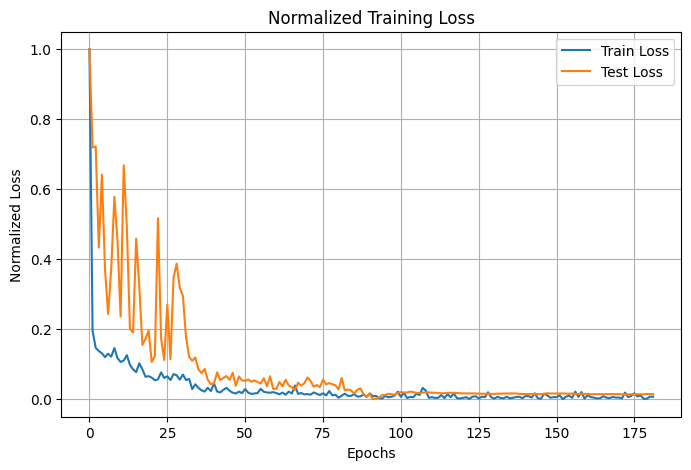

Fold 5
Epoch 0 | Loss train: 1.061066 | Loss test: 0.253264 | lr = 0.01
Epoch 10 | Loss train: 0.168385 | Loss test: 0.187664 | lr = 0.01
Epoch 20 | Loss train: 0.143370 | Loss test: 0.170159 | lr = 0.01
Epoch 30 | Loss train: 0.131457 | Loss test: 0.155099 | lr = 0.01
Epoch 40 | Loss train: 0.140734 | Loss test: 0.138891 | lr = 0.01
Epoch 50 | Loss train: 0.137657 | Loss test: 0.162649 | lr = 0.01
Epoch 60 | Loss train: 0.118490 | Loss test: 0.132983 | lr = 0.01
Epoch 70 | Loss train: 0.103625 | Loss test: 0.139190 | lr = 0.01
Epoch 80 | Loss train: 0.108236 | Loss test: 0.130781 | lr = 0.01
Epoch 90 | Loss train: 0.108825 | Loss test: 0.130348 | lr = 0.001
Epoch 100 | Loss train: 0.082645 | Loss test: 0.114957 | lr = 0.001
Epoch 110 | Loss train: 0.085023 | Loss test: 0.112553 | lr = 0.001
Epoch 120 | Loss train: 0.077659 | Loss test: 0.112972 | lr = 0.0001
Epoch 130 | Loss train: 0.079927 | Loss test: 0.112941 | lr = 0.0001
Epoch 140 | Loss train: 0.077248 | Loss test: 0.112573 | lr

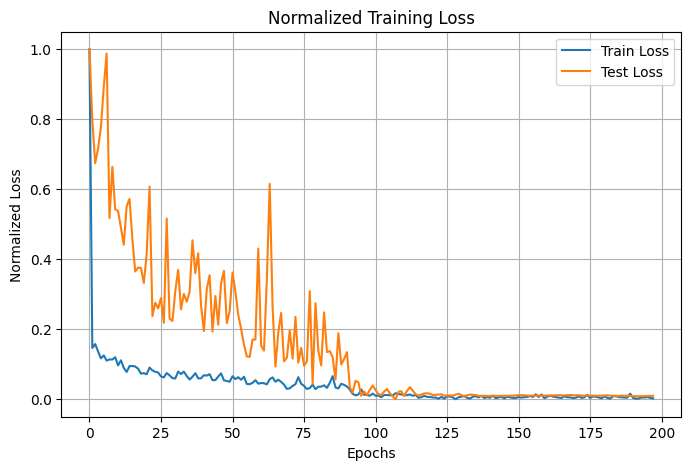

Cross-Validation finished with mean error across 5 subsets = 0.11694335955239477, evaluating final model...
Epoch 0 | Loss train: 0.660822 | lr = 0.01
Epoch 10 | Loss train: 0.174475 | lr = 0.01
Epoch 20 | Loss train: 0.148893 | lr = 0.01
Epoch 30 | Loss train: 0.149063 | lr = 0.01
Epoch 40 | Loss train: 0.109788 | lr = 0.001
Epoch 50 | Loss train: 0.105581 | lr = 0.001
Epoch 60 | Loss train: 0.102093 | lr = 0.001
Epoch 70 | Loss train: 0.095480 | lr = 0.001
Epoch 80 | Loss train: 0.093486 | lr = 0.001
Epoch 90 | Loss train: 0.095799 | lr = 0.001
Epoch 100 | Loss train: 0.089583 | lr = 0.001
Epoch 110 | Loss train: 0.097435 | lr = 0.001
Epoch 120 | Loss train: 0.088002 | lr = 0.001
Epoch 130 | Loss train: 0.081876 | lr = 0.0001
Epoch 140 | Loss train: 0.084424 | lr = 0.0001
Epoch 150 | Loss train: 0.081586 | lr = 0.0001
Epoch 160 | Loss train: 0.086010 | lr = 1e-05
Epoch 170 | Loss train: 0.088007 | lr = 1e-05
Epoch 180 | Loss train: 0.084615 | lr = 1e-05
Epoch 190 | Loss train: 0.0944

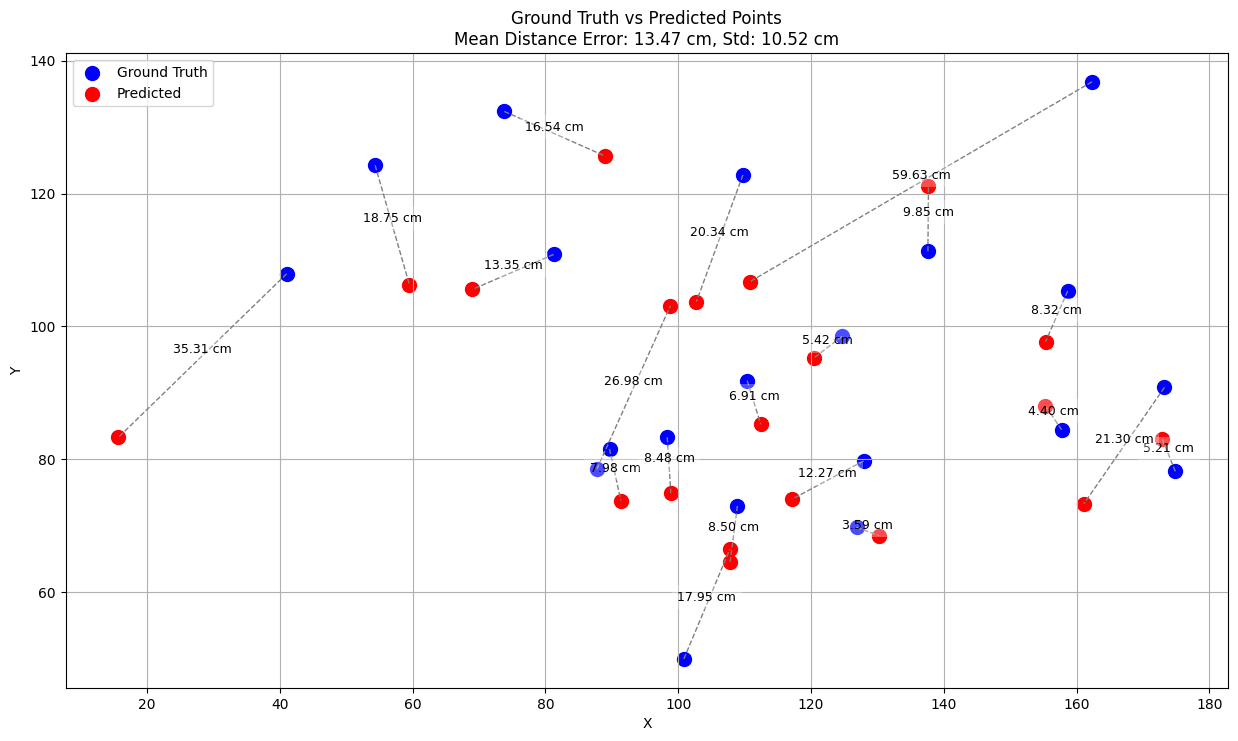

In [36]:
#loss_fn = nn.MSELoss()
loss_fn = nn.HuberLoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 256}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 350

relu_dropout_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= ReLUModelDropout, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [37]:
relu_dropout_model

{'model_name': 'ReLUModelDropout',
 'mean_distance_error_cm': 13.47182846069336,
 'std': 10.516215324401855}

### Αρχιτεκτονική 5

#### XGB

Θα χρησιμοποιήσουμε και τον γνωστό αλγόριθμο για regression XGB, με την βοήθεια του MultiOutputRegressor.

In [38]:
# Train-test split BEFORE reshaping
X_train_raw, X_test_raw, y_train, y_test = train_test_split(info_tensor, rfid_label, test_size=0.2, random_state=42)

# Compute abs max PER FEATURE on training data
abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

# Prevent division by zero
abs_max[abs_max == 0] = 1.0

# Normalize per feature
X_train_norm = X_train_raw / abs_max  # shape (N_train, 500, 4)
X_test_norm = X_test_raw / abs_max    # shape (N_test, 500, 4)

# Now reshape for linear model
X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)


In [39]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.01, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

# Reverse scaling
y_pred_real = scaler_Y.inverse_transform(y_pred)
y_true_real = scaler_Y.inverse_transform(y_test)

xgb_loss = np.mean(np.linalg.norm(y_pred_real - y_true_real, axis=1))
xgb_var = np.std(np.linalg.norm(y_pred_real - y_true_real, axis=1))
xgb_res = {'model_name': 'xgb_model', 'mean_distance_error_cm' : xgb_loss, 'std': xgb_var}

c:\Users\jimka\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:57:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### Αρχιτεκτονική 6

#### Epochs

Θα δοκιμάσουμε επίσης αντί να δημιουργούμε batches να περνάμε τα data απευθείας στο μοντέλο.

Για την δοκιμή αυτή θα χρησιμοποιήσουμε το μοντέλο LeakyReLUModel4 με συνάρτηση ενεργοποίησης την LeakyReLU και 4 επίπεδα.

Δεν δημιουργώ συναρτήσεις αφού είναι μεμονομένη περίπτωση.

In [59]:
# Instantiate the model
model_13 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_13.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr = 1e-5)

In [60]:
# Train-test split BEFORE reshaping
X_train_raw, X_test_raw, y_train, y_test = train_test_split(info_tensor, rfid_label, test_size=0.2, random_state=42)

# Compute abs max PER FEATURE on training data
abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

# Prevent division by zero
abs_max[abs_max == 0] = 1.0

# Normalize per feature
X_train_norm = X_train_raw / abs_max  # shape (N_train, 500, 4)
X_test_norm = X_test_raw / abs_max    # shape (N_test, 500, 4)

# Now reshape for linear model
X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)

In [61]:
# Set seed before defining model and optimizer
torch.manual_seed(42)  

# Move model to device **before** training
model_13.to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

# Set number of epochs
epochs = 1000  

# Training loop
for epoch in range(epochs):
    model_13.train()
    
    # Forward pass
    y_pred = model_13(X_train_tensor)

    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)  

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_13.eval()
    with torch.inference_mode():
        test_logits = model_13(X_test_tensor)
        test_loss = loss_fn(test_logits, y_test_tensor).detach()  # Ensure no gradients


    # Update learning rate scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(test_loss.detach())  
    else:
        scheduler.step()

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")


model_13.eval()
with torch.inference_mode():
    y_pred = model_13(X_test_tensor)
# Reverse scaling
y_pred_real = scaler_Y.inverse_transform(y_pred.cpu())
y_true_real = scaler_Y.inverse_transform(y_test_tensor.cpu())

distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
mean_distance_error = np.mean(distances)
std = np.std(distances)

epoch_res = {'model_name': 'LeakyReLU4_noBatches', 'mean_distance_error_cm' : mean_distance_error.item(), 'std': std.item()}

Epoch: 0 | Train Loss: 1.00588 | Test Loss: 1.56679
Epoch: 100 | Train Loss: 0.22508 | Test Loss: 0.40712
Epoch: 200 | Train Loss: 0.13031 | Test Loss: 0.33673
Epoch: 300 | Train Loss: 0.12999 | Test Loss: 0.33667
Epoch: 400 | Train Loss: 0.12973 | Test Loss: 0.33674
Epoch: 500 | Train Loss: 0.12944 | Test Loss: 0.33670
Epoch: 600 | Train Loss: 0.12913 | Test Loss: 0.33671
Epoch: 700 | Train Loss: 0.12880 | Test Loss: 0.33671
Epoch: 800 | Train Loss: 0.12846 | Test Loss: 0.33663
Epoch: 900 | Train Loss: 0.12810 | Test Loss: 0.33661
Epoch: 1000 | Train Loss: 0.12774 | Test Loss: 0.33655


***

### Αρχιτεκτονική 7

#### 1D CNN

In [40]:
class CNN1DModel(nn.Module):
    def __init__(self, input_channels=4, output_size=2):
        super(CNN1DModel, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=7, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(32, 64, 5, stride=1, padding=2),
            
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool1d(1),  # Output shape: (batch_size, 128, 1)
        )
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(128, output_size)

    def forward(self, x):
        #x = x.permute(0, 2, 1)  # (batch, 500, 4) → (batch, 4, 500)
        x = self.conv_stack(x)  # (batch, 128, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 128)
        return self.fc(self.dropout(x))

In [41]:
def data_func_cnn(input_array, labels, batch_size=32, test_size=0.2):
    # No flattening; keep the input as (samples, 1000, 4)
    y = labels[:, :2]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(input_array, y, test_size=test_size, random_state=42)

    # Compute abs max PER FEATURE on training data
    abs_max = np.abs(X_train).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_scaled = X_train / abs_max  # shape (N_train, 500, 4)
    X_test_scaled = X_test / abs_max    # shape (N_test, 500, 4)
    

    # Scale Y (labels)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors and move channel dim for CNN input (B, C, L)
    # Current: (B, 1000, 4) → CNN wants (B, 4, 1000)
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).permute(0, 2, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).permute(0, 2, 1)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Create datasets
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Data loaders
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [42]:
train_loader_cnn, test_loader_cnn, scaler_rev_cnn = data_func_cnn(info_tensor, rfid_label)

Epoch 0 | Loss train: 0.578771 | Loss test: 0.630536 | lr = 0.01
Epoch 10 | Loss train: 0.407871 | Loss test: 0.420260 | lr = 0.01
Epoch 20 | Loss train: 0.427287 | Loss test: 0.483253 | lr = 0.01
Epoch 30 | Loss train: 0.365594 | Loss test: 0.406192 | lr = 0.01
Epoch 40 | Loss train: 0.338746 | Loss test: 0.385172 | lr = 0.001
Epoch 50 | Loss train: 0.329815 | Loss test: 0.378176 | lr = 0.001
Epoch 60 | Loss train: 0.341148 | Loss test: 0.378456 | lr = 0.001
Epoch 70 | Loss train: 0.332506 | Loss test: 0.372973 | lr = 0.0001
Epoch 80 | Loss train: 0.317636 | Loss test: 0.379592 | lr = 1e-05
Epoch 90 | Loss train: 0.327058 | Loss test: 0.374614 | lr = 1e-05
Epoch 100 | Loss train: 0.316755 | Loss test: 0.380946 | lr = 1e-05
Epoch 110 | Loss train: 0.312903 | Loss test: 0.376760 | lr = 1e-05
Epoch 120 | Loss train: 0.308159 | Loss test: 0.378138 | lr = 1e-05
Epoch 130 | Loss train: 0.338320 | Loss test: 0.374077 | lr = 1e-05
Epoch 140 | Loss train: 0.318939 | Loss test: 0.370172 | lr = 

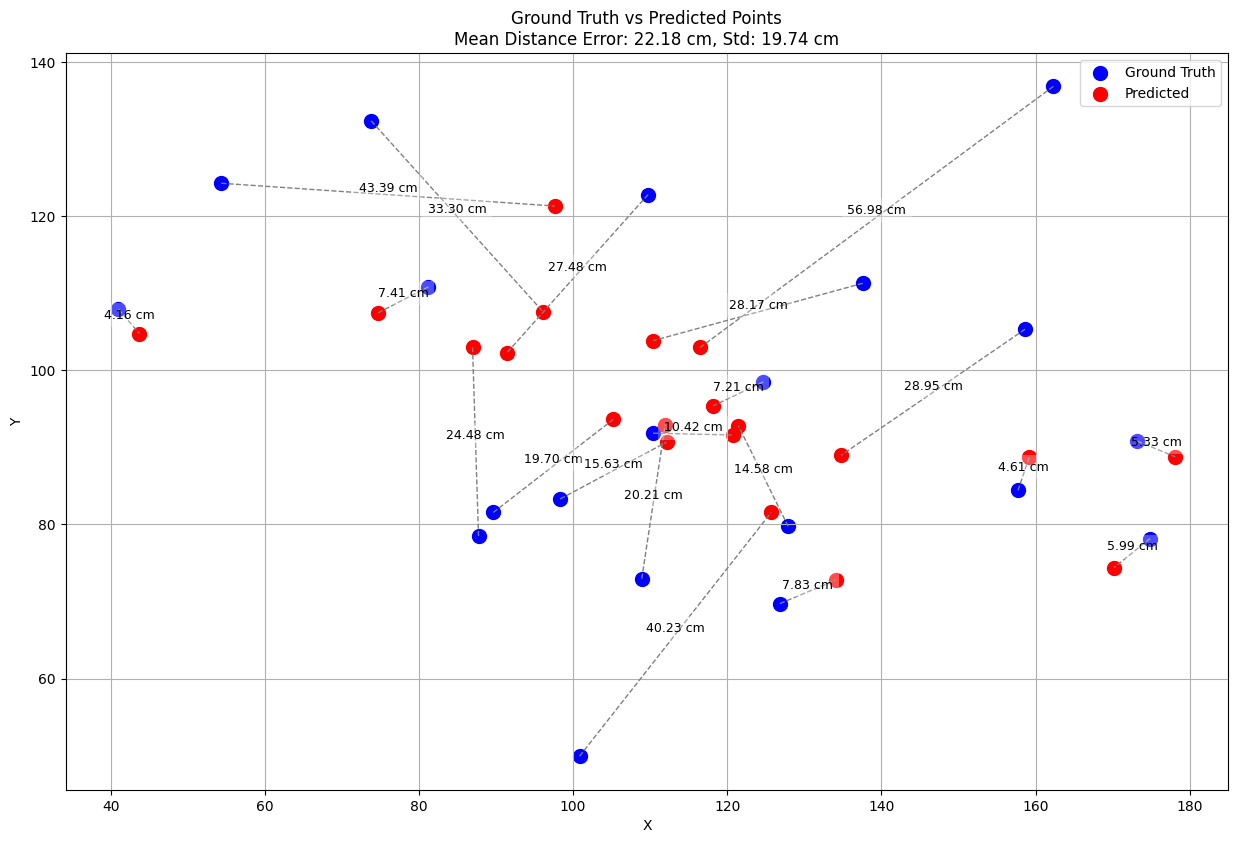

In [43]:
# Instantiate the model
model_16 = CNN1DModel(input_channels=4, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_16.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr= 1e-5)
# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2, irrelevant_1, irrelevant_2 = train_test_model(epoch = 200,model = model_16, train_loader= train_loader_cnn, test_loader= test_loader_cnn, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True)

plot_results(arr1, arr2)

cnn_model = eval_model(model_16, test_loader_cnn, scaler_rev_cnn, device)

In [44]:
cnn_model

{'model_name': 'CNN1DModel',
 'mean_distance_error_cm': 22.175872802734375,
 'std': 19.74294662475586}

## Results

Results for interpolation size = 385

In [47]:
#compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, leakyrelu_2,leakyrelu_2_rms, relu_model,dropout_model, sigmoid_model, tanh_model, cnn_model, relu_dropout_model, relu_model_256, relu_model_64])
compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, leakyrelu_2,leakyrelu_2_rms, relu_model,dropout_model, cnn_model, relu_dropout_model, relu_model_256, relu_model_64])
compare_results = compare_results._append(xgb_res, ignore_index = True)
#compare_results = compare_results._append(epoch_res, ignore_index = True)
compare_results.sort_values(by = 'mean_distance_error_cm', ascending= True, inplace= True)

compare_results

model_name  mean_distance_error_cm        std
4               ReLUModel               12.102048  10.484224
8               ReLUModel               13.043755  12.366007
5   LeakyReLUModelDropout               13.139786   9.165758
9               ReLUModel               13.343581  11.486533
7        ReLUModelDropout               13.471828  10.516215
0          LeakyReLUModel               14.022871  13.459557
2         LeakyReLUModel2               14.510084  12.141258
1         LeakyReLUModel4               14.580082  15.050424
3     LeakyReLUModel2_RMS               14.984437  12.375936
6              CNN1DModel               22.175873  19.742947
10              xgb_model               40.471562  25.162906

In [48]:
# Visualize our model results
compare_results.set_index("model_name")["mean_distance_error_cm"].plot(kind="bar")
plt.xlabel("Model Name")
plt.ylabel("Loss in CM")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***

Results for interpolation size = 700

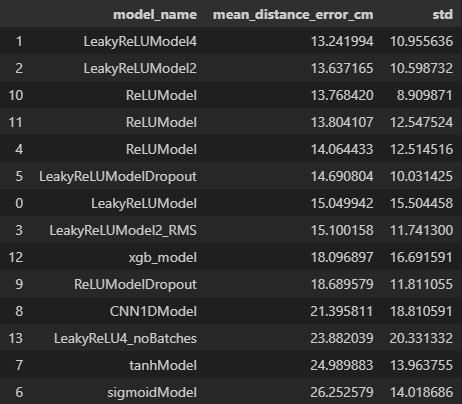

Results for interpolation size = 500

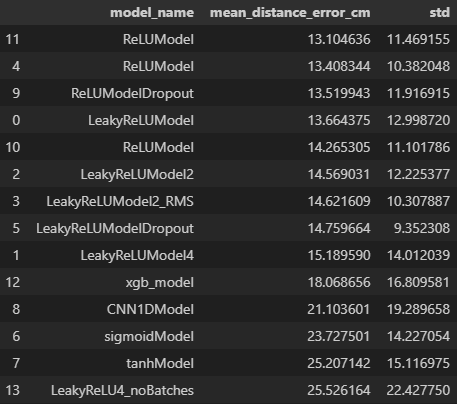

Results for interpolation size = 300

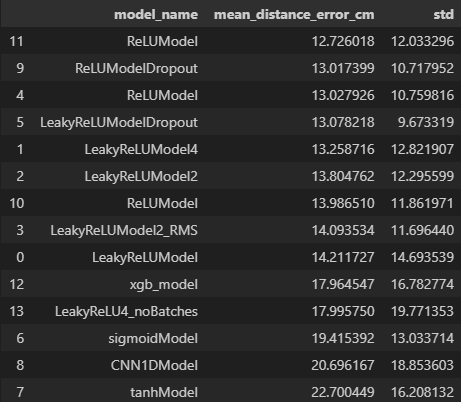

***

# Hyperparameter Tuning

Θα μελετήσουμε ποιες είναι οι βέλτιστες παράμετροι για το μοντέλο ReLU με dropout.

In [13]:
def cross_validation_hyper(input_array, labels, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_class, scheduler_param, early_stopper_param, epochs, device, verbose = True):
    # Hold out 5% of the data for final validation
    X_main, X_holdout, y_main, y_holdout = train_test_split(
        input_array, labels, test_size=0.05, random_state=42
    )

    ################## FOR PHASE RELOCK ################
    global labels_holdout
    global info_holdout
    info_holdout = X_holdout
    labels_holdout = y_holdout
    ####################################################

    y_holdout = y_holdout[:, :2]
    y_main = y_main[:,:2]
    
    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_main)):
        
        print(f"Fold {fold_idx + 1}")

        train_loader, test_loader, _ = data_func_cv(X_main, y_main, train_idx, val_idx, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = scheduler_class(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    
    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = scheduler_class(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result

In [20]:
class ReLUModel_hyper(nn.Module):
    def __init__(self, input_size, output_size, hidden_units=(128, 128)):
        super(ReLUModel_hyper, self).__init__()

        layers = []
        in_features = input_size

        for hidden in hidden_units:
            layers.append(nn.Linear(in_features, hidden))
            layers.append(nn.ReLU())
            in_features = hidden

        layers.append(nn.Linear(in_features, output_size))

        self.linear_stack = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.linear_stack(x)

Θα πειράξουμε lr , optimizer, batch_size


🚀 Testing Config: Batch Size: 16, hidden units: (128, 128)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22756041402044974, evaluating final model...


✅ Finished Batch Size: 16, hidden units: (128, 128) in 150.60s | Mean Error: 13.7905, Std: 14.3970

🚀 Testing Config: Batch Size: 16, hidden units: (770, 385, 192, 96)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.23175131927411527, evaluating final model...


✅ Finished Batch Size: 16, hidden units: (770, 385, 192, 96) in 170.54s | Mean Error: 12.5766, Std: 13.3000

🚀 Testing Config: Batch Size: 32, hidden units: (128, 128)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.23215923323517754, evaluating final model...


✅ Finished Batch Size: 32, hidden units: (128, 128) in 81.68s | Mean Error: 14.2779, Std: 12.9789

🚀 Testing Config: Batch Size: 32, hidden units: (770, 385, 192, 96)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22632052334291597, evaluating final model...


✅ Finished Batch Size: 32, hidden units: (770, 385, 192, 96) in 107.42s | Mean Error: 13.4815, Std: 13.3530

🚀 Testing Config: Batch Size: 64, hidden units: (128, 128)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22464938359335065, evaluating final model...


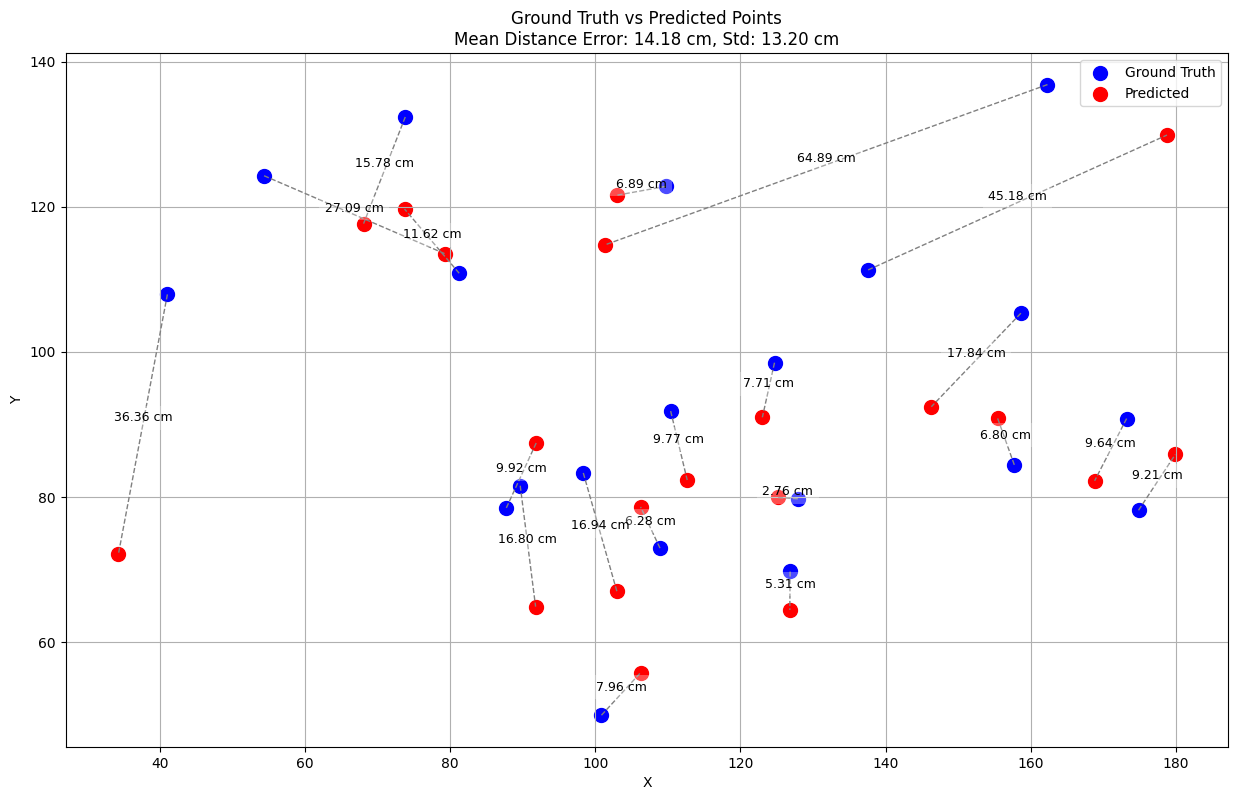

✅ Finished Batch Size: 64, hidden units: (128, 128) in 48.91s | Mean Error: 14.1812, Std: 13.1959

🚀 Testing Config: Batch Size: 64, hidden units: (770, 385, 192, 96)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22743093843261403, evaluating final model...


✅ Finished Batch Size: 64, hidden units: (770, 385, 192, 96) in 56.67s | Mean Error: 13.3179, Std: 12.1769


In [26]:
import time
from collections import defaultdict

# Hyperparameter search space
batch_sizes = [16, 32, 64]
hidden_units_list = [(128,128), (input_len//2, input_len//4, input_len//8, input_len//16)]  # Custom addition: allows tuning hidden units

# Training setup
epochs = 200
num_splits = 5
learning_rate = 1e-3
optimizer = torch.optim.Adam
loss_fn = nn.MSELoss()

optimizer_params = {'lr': learning_rate}

scheduler_params = {
    'mode': 'min',
    'factor': 0.1,
    'patience': 10,
    'min_lr': 1e-5
}

early_stop_params = {
    'patience': 90,
    'min_delta': 1e-5,
    'verbose': False,
    'path': 'temp_model.pth'
}

# Results dictionary
grid_search_results = {}

for batch_size in batch_sizes:
    for hidden_units in hidden_units_list:
        config_name = f"Batch Size: {batch_size}, hidden units: {hidden_units}"
        print(f"\n🚀 Testing Config: {config_name}")

        # Define model class wrapper with current hidden units
        model_params = {
            'input_size': input_len,
            'output_size': output_len,
            'hidden_units': hidden_units
        }

        start_time = time.time()

        try:
            BATCH_SIZE = batch_size
            result = cross_validation_hyper(
                info_tensor,
                rfid_label,
                n_splits=num_splits,
                model=ReLUModel_hyper,
                model_param=model_params,
                loss_fn=loss_fn,
                optimizer_1=optimizer,
                optimizer_param=optimizer_params,
                scheduler_class= lr_scheduler.ReduceLROnPlateau,
                scheduler_param=scheduler_params,
                early_stopper_param=early_stop_params,
                epochs=epochs,
                device=device,
                verbose=False,
            )
            duration = time.time() - start_time
            mean_err = result['mean_distance_error_cm']
            std_err = result['std']

            print(f"✅ Finished {config_name} in {duration:.2f}s | Mean Error: {mean_err:.4f}, Std: {std_err:.4f}")

            grid_search_results[config_name] = {
                'result': result,
                'duration': duration,
                'batch_size': batch_size,
                'hidden_units': hidden_units
            }

        except Exception as e:
            print(f"❌ Failed config: {config_name} due to error: {e}")


In [27]:
# Find config with lowest mean_distance_error_cm error
best_config = min(grid_search_results.items(), key=lambda x: x[1]['result']['mean_distance_error_cm'])
print(f"\nBest Config: {best_config[0]} | mean_distance_error_cm Error: {best_config[1]['result']['mean_distance_error_cm']:.4f} | Std: {best_config[1]['result']['std']:.4f}")



Best Config: Batch Size: 16, hidden units: (770, 385, 192, 96) | mean_distance_error_cm Error: 12.5766 | Std: 13.3000


***

# Phase ReLock

Αρχικά ελέγχουμε τις προβλέψεις του καλύτερου νευρωνικού για τις δύο διαστάσεις όπως προκύπτει από το hyperparameter tuning.

In [61]:
class ReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 256):
        super(ReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units)),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features= int(hidden_units), out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

In [62]:
loss_fn = nn.MSELoss()
optim= torch.optim.Adam
optimizer_params = {'lr':1e-3}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 256}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 2
epoch = 300
BATCH_SIZE = 32

relu_dropout_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= ReLUModelDropout, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose= False)

Fold 1
Fold 2
Cross-Validation finished with mean error across 2 subsets = 0.2773382046725601, evaluating final model...


Τώρα θα ορίσουμε την Phase ReLock ως μέτρο σύγκρισης των αποτελεσμάτων.

Ορίζουμε αρχικά την συνάρτηση προς βελτιστοποίηση όπως φαίνεται παρακάτω αλλά για NA = 1.

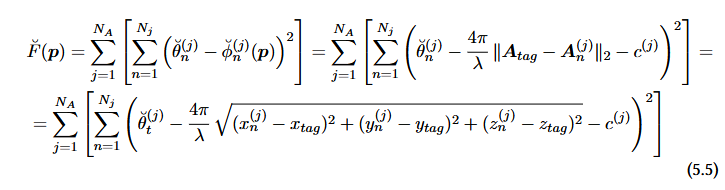

In [63]:
labels_holdout.shape , info_holdout.shape

((51, 3), (51, 385, 4))

In [64]:
def theoretical_2D(x, x_antenna, y_antenna, z_antenna, phase, lamda, z_tag, alpha = 0.1):
    # x[0] = x_tag
    # x[1] = y_tag
    # x[2] = irrelevant c (phase offset)
    
    F = (phase - x[2] - (4*np.pi / lamda) * np.sqrt((x[0]-x_antenna)**2 + (x[1] -y_antenna)**2) + (z_tag - z_antenna))**2

    return F 

Και στην συνέχεια την συνάρτηση που θα την βελτιστοποιήσει, θα χρησιμοποιήσουμε την least_squares.

In [65]:
from scipy.optimize import least_squares

def nonlinear_fit_2D(x_antenna, y_antenna, z_antenna, phase, lamda, start, z_tag):
    start = np.asarray(start, dtype=float)  
    
    # Perform nonlinear least squares optimization
    param = least_squares(theoretical_2D, start, args=(x_antenna, y_antenna, z_antenna, phase, lamda, z_tag), method='trf')

    return param.x[:2]  # Return the optimized parameters

Η ```phase_relock``` δέχεται σαν ορίσματα τον πίνακα με όλα τα tags, και τους πίνακες που κρατήθηκαν έξω από το training set (info, labels),

Μιας και τα labels_holdout έχουν μονο xy πρέπει να γίνει μια αντιστοίχιση με τα ωμά labels για να βρεθεί και το Z αφού απαιτείται από την συνάρτηση βελτιστοποίησης.

In [66]:
def phase_relock(labels_holdout, info_tensor_raw):
    """
    Perform phase relocking by optimizing tag position estimates and comparing with ground truth.
    """
    # Constants
    FREQ = 866e6  # RFID tag frequency (Hz)
    C = 299792458.0  # Speed of light (m/s)
    METERS = 100  # Convert to meters (set to 1 for cm-based optimization)
    LAMBDA_SIGNAL = C / FREQ
    
    # Containers for results
    errors, results, real_tags = [], [], []
    
    # Optimize tag location for each test sample
    for i, info in enumerate(info_tensor_raw):
        x, y, z, phase = info[:, 0] / METERS, info[:, 1] / METERS, info[:, 2] / METERS, info[:, 3]
    
        # Perform nonlinear optimization to estimate tag location
        predicted = nonlinear_fit_2D(x, y, z, phase, lamda=LAMBDA_SIGNAL, start=[1, 0.5, -50],
                                     z_tag=z)
        results.append(predicted)
        
        # Compute Euclidean error between ground truth and predicted position
        error = np.sqrt((labels_holdout[i, 0] / METERS - predicted[0])**2 +
                        (labels_holdout[i, 1] / METERS - predicted[1])**2)
        errors.append(error)
        
        # Store ground truth position
        real_tags.append(labels_holdout[i])
        
    
    # Convert lists to NumPy arrays
    labels_holdout, results, errors = np.array(labels_holdout), np.array(results), np.array(errors)
    
    # Plot results
    plt.figure(figsize=(15, 15))
    num_points = min(20, len(labels_holdout))
    
    plt.scatter(labels_holdout[:num_points, 0], labels_holdout[:num_points, 1], color='blue', label='Ground Truth', s=100)
    plt.scatter(results[:num_points, 0] * METERS, results[:num_points, 1] * METERS, color='red', label='Predicted', s=100)
    
    # Draw connections and annotate errors
    for i in range(num_points):
        gt, pred = labels_holdout[i], results[i] * METERS
        plt.plot([gt[0], pred[0]], [gt[1], pred[1]], color='gray', linestyle='--', linewidth=1)
        plt.text((gt[0] + pred[0]) / 2, (gt[1] + pred[1]) / 2, f'{errors[i] * METERS:.2f} cm',
                 fontsize=9, ha='center', va='bottom', color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.3))
    
    # Formatting
    #plt.gca().set_aspect('equal')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title(f'Phase Relock\nGround Truth vs Predicted Positions\nMean Distance Error: {np.mean(errors) * METERS:.2f} cm, Std: {np.std(errors) * METERS:.2f} cm')
    plt.legend()
    plt.grid(True)
    plt.show()
    return np.mean(errors[:20]), np.std(errors[:20])


In [67]:
phase_relock(labels_holdout, info_holdout)

(np.float64(0.12398475076305351), np.float64(0.13061157017689098))